In [1]:
# This is used to read fits files 
from astropy.io import fits

# Useful for a bunch of stuff
import numpy as np

# Used for Log plots
from matplotlib.colors import LogNorm

# Used to draw ellipses
from matplotlib.patches import Ellipse

# Prettier plots
import seaborn as sns

# Used for median filter to handle noise
from scipy import ndimage

# Used for Gaussian 2D fitting
from scipy import optimize

# Set up matplotlib and use a nicer set of plot parameters
import matplotlib.pyplot as plt 
%matplotlib inline 
%config InlineBackend.figure_formats = ('png', 'retina')

In [2]:
def extract_FITS(filename):
    '''
       Extracts the data cube from the FITS file.
       
       Arguments: 
           filename : name of the file including path
           
       Return variables:
           hdu_list : hdu_list[0].data contains the data cube array in order of wavelength, y, x
           Min      : the starting wavelength value in the cube in Angstroms
           Max      : the ending wavelength value in the cube in Angstroms
           Step     : the step size of the wavelength
           xlen     : the size of the horizontal axis of FOV in arcseconds
           ylen     : the size of the horizontal axis of FOV in arcseconds
    '''
    
    hdu_list = fits.open(filename)
    image, header = fits.getdata(filename, header=True)
    Min = header['CRVAL3']
    step = header['CD3_3']
    Max = Min +  (np.shape(image)[0] - 1) * step
    ypixel = len(hdu_list[0].data[0])
    xpixel = len(hdu_list[0].data[0][0])
    xlen = (header['CD1_1']**2 + header['CD2_1']**2)**(0.5) * xpixel * 3600
    ylen = (header['CD1_2']**2 + header['CD2_2']**2)**(0.5) * ypixel * 3600
    return hdu_list, Min, Max, step, xlen, ylen

def wave2pix(wave, color):
    '''
       Converts a given wavelength value into the corresponding pixel of the specified cube.
       
       Arguments:
           wave     : the wavelength value 
           color    : blue, green, or red
        
       Return variables: 
           pixel    : the pixel value 
    '''
    
    if color == "blue":
        return int((wave - Min_blue) / step_blue)
            
    if color == "green":
        return int((wave - Min_green) / step_green)
            
    if color == "red":
        return int((wave - Min_red) / step_red)
    
def make_sum(start_wv, end_wv, color):
    '''
       Makes a direct sum of a set of images in a specified wavelength span. 
       
       Arguments:
           start_wv : the starting wavelength value  
           end_wv   : the ending wavelength value 
           color    : blue, green, or red
        
       Return variables: 
           sum_img  : the summed image
    '''
    
    sum_img = 0
    start = wave2pix(start_wv, color)
    end = wave2pix(end_wv, color)
    length = -start + end
    
    if color == "blue":
        for i in range(length+1):
            sum_img += hdu_list_blue[0].data[start + i]
            
    if color == "green":
        for i in range(length+1):
            sum_img += hdu_list_green[0].data[start + i]
            
    if color == "red":
        for i in range(length+1):
            sum_img += hdu_list_red[0].data[start + i]
            
    return sum_img

def plot_hist(sum_img, hist_range=0):
    '''
       Displays a histogram of a summed image. Useful for deciding the colorbar. 
       
       Arguments:
           sum_img      : the summed image  
           hist_range   : (optional) specify a particular range for the x-axis
        
       Return variables: 
           none
    '''
    
    plt.figure(figsize=(9,4))
    if hist_range: 
        plt.hist(sum_img.flatten(), 100, range=hist_range)
    else:
        plt.hist(sum_img.flatten(), 100)
    plt.show()
    
    
def plot_sum(sum_img, minpix, maxpix):
    '''
       Plots a summed image.
       
       Arguments:
           sum_img  : the summed image 
           minpix   : the min value of the colorbar 
           maxpix   : the max value of the colorbar
        
       Return variables: 
           none
    '''
    
    plt.imshow(sum_img, cmap='jet', vmin=minpix, vmax=maxpix, extent=[0, xlen, 0, ylen])
    ax = plt.gca();
    ax.set_yticks(np.arange(0, ylen, 2));
    ax.set_xticks(np.arange(0, xlen, 2));
    plt.xlabel('x (\u2033)');
    plt.ylabel('y (\u2033)');
    plt.colorbar()
    
def plot_log(sum_img, minpix, maxpix, tick):
    '''
       Plots a summed image with a log colorbar.
       
       Arguments:
           sum_img  : the summed image 
           minpix   : the min value of the colorbar 
           maxpix   : the max value of the colorbar
           ticks    : (array) set the ticks on the colorbar
        
       Return variables: 
           none
    '''
    
    sum_img_log = np.copy(sum_img)
    for i in range(len(sum_img)):
        for j in range(len(sum_img[0])):
            if sum_img_log[i][j] <= 0:
                sum_img_log[i][j] = 0.01
    plt.imshow(sum_img_log, cmap='jet', vmin=minpix, vmax=maxpix, extent=[0, xlen, 0, ylen], norm=LogNorm())
    ax = plt.gca();
    ax.set_yticks(np.arange(0, ylen, 2));
    ax.set_xticks(np.arange(0, xlen, 2));
    plt.xlabel('x (\u2033)');
    plt.ylabel('y (\u2033)');
    cbar = plt.colorbar(ticks=tick);
    cbar.ax.set_yticklabels(tick);
    
def make_bin(start_wv, end_wv, step, color, minpix, maxpix, cols, size=(10, 50), tick=False):
    '''
       Make multiple plots of summed images given a specified bin and a specified wavelength span. 
       
       Arguments:
           start_wv  : the starting wavelength value 
           end_wv    : the ending wavelength value 
           step      : the binning size of the wavelength  
           color     : blue, green, or red
           minpix    : the min value of the colorbar
           maxpix    : the max value of the colorbar
           cols      : the number of columns of images subplotted
           size      : (optional) the size of the images subplotted
           tick      : (optional) enter array of ticks if log colorbar desired  
        
       Return variables: 
           none
    '''
    
    lst = np.arange(start_wv, end_wv+step, step)
    plt.figure(figsize=size)
    if not tick:
        for i, n in enumerate(lst):
            if (i < len(lst) - 1):
                sum_img = make_sum(lst[i], lst[i+1], color)
                plt.subplot(15, cols, i+1)
                plot_sum(sum_img, minpix, maxpix)
                plt.title('{} - {} ($\AA$)'.format(lst[i], lst[i+1]))
        plt.tight_layout()
        
    else:
        for i, n in enumerate(lst):
            if (i < len(lst) - 1):
                sum_img = make_sum(lst[i], lst[i+1], color)
                plt.subplot(15, cols, i+1)
                plot_log(sum_img, minpix, maxpix, tick)
                plt.title('{} - {} ($\AA$)'.format(lst[i], lst[i+1]))
        plt.tight_layout()
        
def extract_back(sum_img, minpix, maxpix):
    '''
       Extracts the sky background in a summed image. The extracted background is shown
       as a white box.
       
       Arguments:
           sum_img  : the summed image 
           minpix   : the min value of the colorbar 
           maxpix   : the max value of the colorbar
        
       Return variables: 
           median   : the median value of the sky background
           std      : the standard deviation value of the sky background 
    '''
    
    sum_imgc = np.copy(sum_img);
    back = [];
    for i in range(13):
        for j in range(18):
            back.append(sum_img[135 + i][5 + j])
            sum_imgc[135 + i][5 + j] = None
    plot_sum(sum_imgc, minpix, maxpix)
    median = np.median([i for i in back if i > 0])
    std = np.std(back)
    return median, std

def remove_noise(sum_img, minpix, maxpix, num):
    '''
       Removes all pixels that are a specified factor of the standard deviation above the 
       median of the sky background.
       
       Arguments:
           sum_img  : the summed image 
           minpix   : the min value of the colorbar 
           maxpix   : the max value of the colorbar
           num      : the specified factor (median + num * std)
        
       Return variables: 
           sum_img  : the summed image with pixels above the threshold removed
    '''
    
    median, std = extract_back(sum_img, minpix, maxpix)
    plt.show()
    sum_imgc = np.copy(sum_img);
    for i in range(len(sum_img)):
        for j in range(len(sum_img[0])):
            if sum_imgc[i][j] <= median + num * std:
                sum_imgc[i][j] = None
    plot_sum(sum_imgc, minpix, maxpix)
    plt.show()
    return sum_imgc     
    
def find_max_flux(sum_img, minpix, maxpix, nextMax=False):
    '''
       Displays the point of max flux in a given image. 
       
       Arguments:
           sum_img  : the summed image 
           minpix   : the min value of the colorbar 
           maxpix   : the max value of the colorbar
           nextMax  : (optional) set True if second largest flux desired
        
       Return variables: 
           none
    '''   
    xvals = np.linspace(0, xlen, 3*np.shape(sum_img)[1])
    yvals = np.linspace(0, ylen, 3*np.shape(sum_img)[0])

    new_sum_img = np.copy(sum_img)
    [a],[b] = np.where(new_sum_img == np.max(new_sum_img[new_sum_img==new_sum_img]))
    
    if nextMax:
        new_sum_img[a][b] = None
        [a],[b] = np.where(new_sum_img == np.max(new_sum_img[new_sum_img==new_sum_img]))
    
    max_y = round(yvals[-3*a], 4);
    max_x = round(xvals[3*b], 4);
    max_flux = round(np.max(new_sum_img[new_sum_img==new_sum_img]), 4)

    new_sum_img[a][b] = None

    plot_sum(new_sum_img, minpix, maxpix)
    plt.figtext(0.622, 0.01, "({}\u2033, {}\u2033, {})".format(max_y, max_x, str(max_flux)), size='11', horizontalalignment='center')
    circle1 = Ellipse((xvals[3*b+1], yvals[-3*a-2]), 0.45, 0.45, fill=True, lw=2.5, fc='white', ec='black')
    ax = plt.gca()
    ax.add_artist(circle1)
    
def div0(a, b):
    '''
       Division function for arrays that returns None when division by zero is encountered.
       
       Arguments:
           a  : numerator array
           b  : denominator array
        
       Return variables: 
           c  : quotient array
    '''
    with np.errstate(divide='ignore', invalid='ignore'):
        c = np.true_divide(a, b)
        c[~np.isfinite(c)] = None  # -inf inf NaN
    return c

In [3]:
image_blue  = 'surf2018/data/cubes/s_HH32abd-OII3727.fits'
image_green = 'surf2018/data/cubes/s_HH32abd-OIII5007.fits'
image_red   = 'surf2018/data/cubes/s_HH32abd-OI6300.fits'

hdu_list_blue, Min_blue, Max_blue, step_blue, xlen, ylen = extract_FITS(image_blue)
hdu_list_green, Min_green, Max_green, step_green, xlen, ylen = extract_FITS(image_green)
hdu_list_red, Min_red, Max_red, step_red, xlen, ylen = extract_FITS(image_red)

# Update default figure and font size
plt.rcParams["figure.figsize"] = [9, 7]
plt.rcParams.update({'font.size': 10})

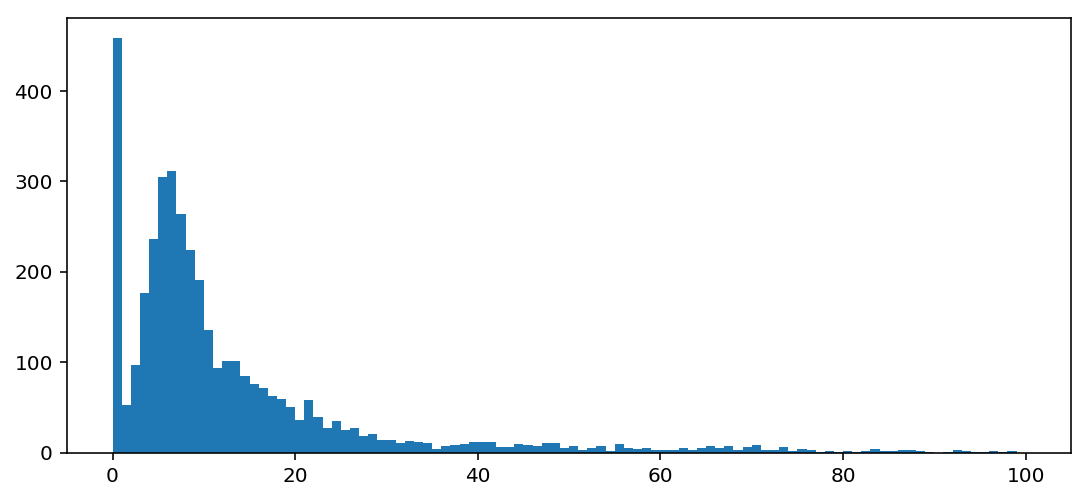

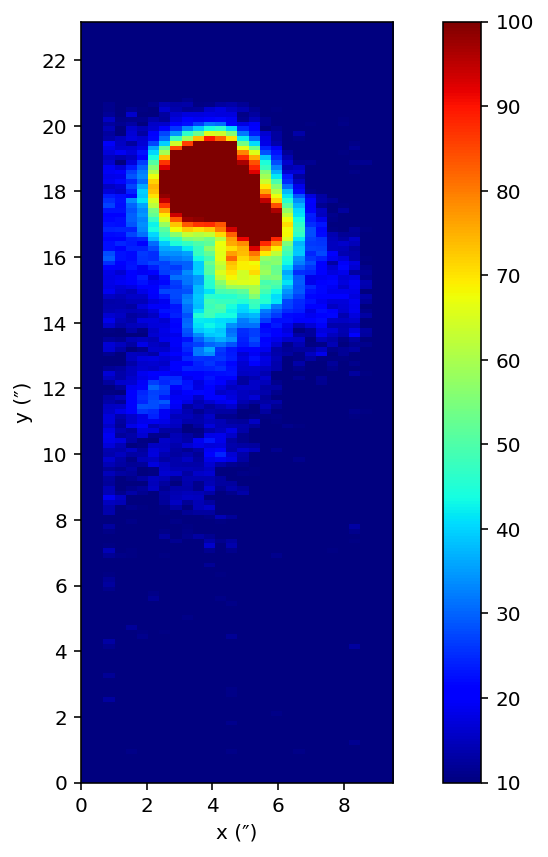

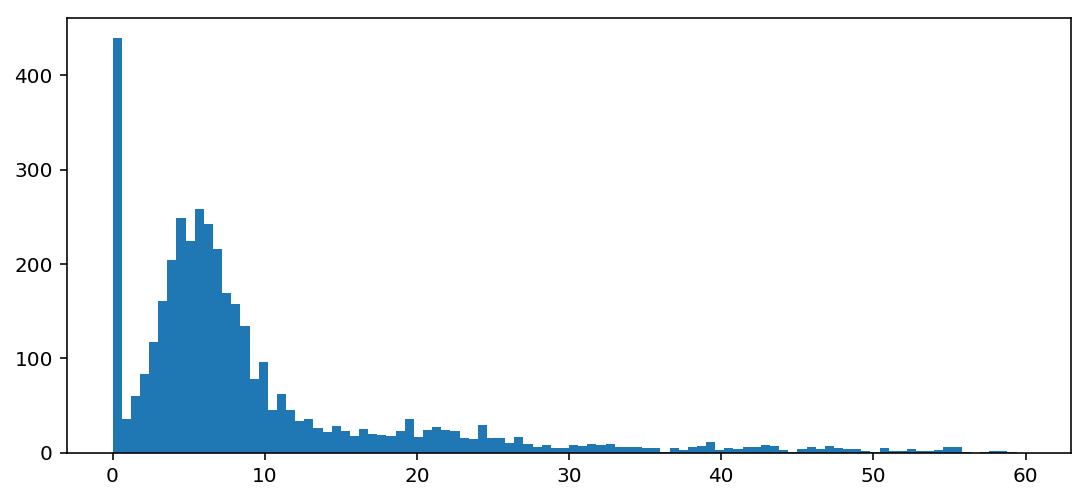

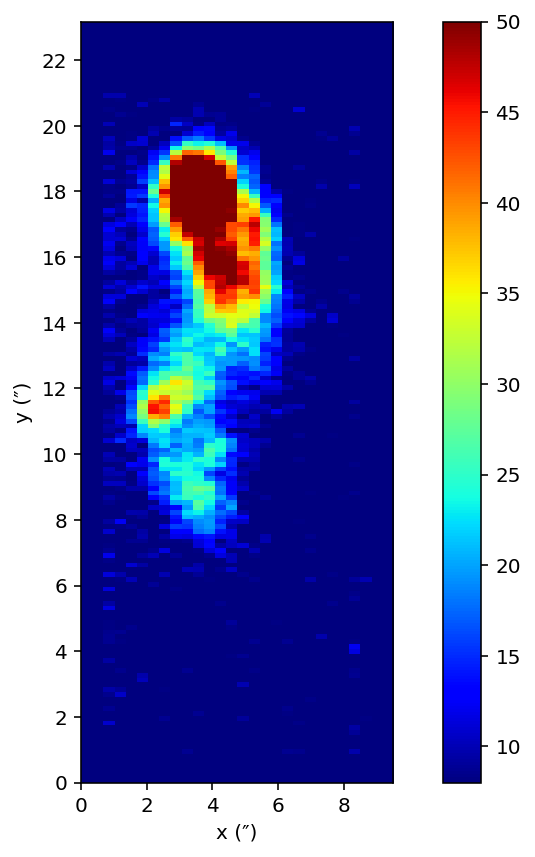

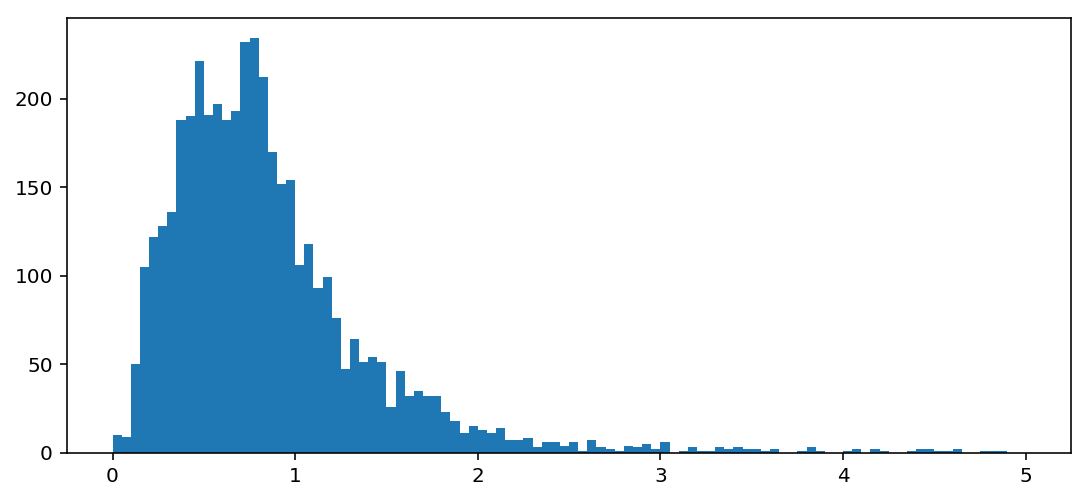

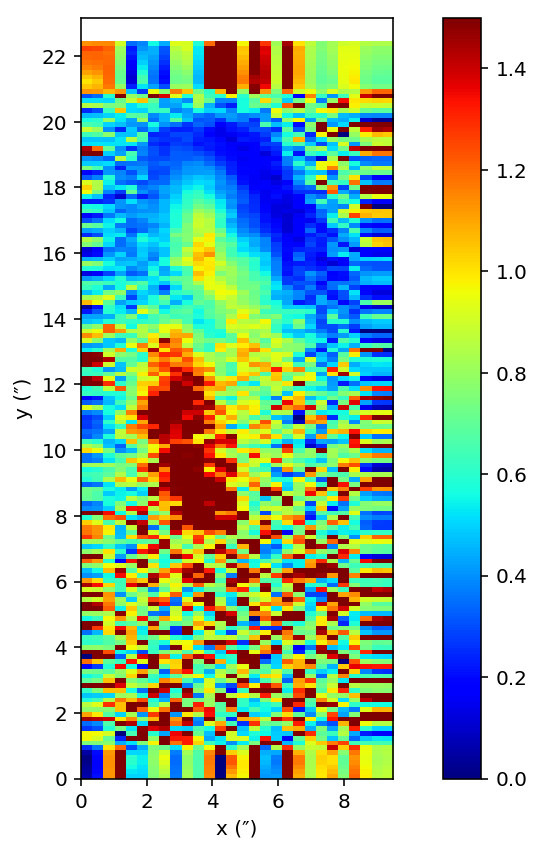

In [4]:
sum_3726 = make_sum(3725.25, 3729.50, "blue")
plot_hist(sum_3726, [0, 100])
plot_sum(sum_3726, 10, 100)

sum_3729 = make_sum(3729.75, 3733.75, "blue")
plot_hist(sum_3729, [0, 60])
plot_sum(sum_3729, 8, 50)

oii_oii = div0(sum_3729, sum_3726)
plot_hist(oii_oii[oii_oii == oii_oii], [0, 5])
plot_sum(oii_oii, 0, 1.5)
plt.show()

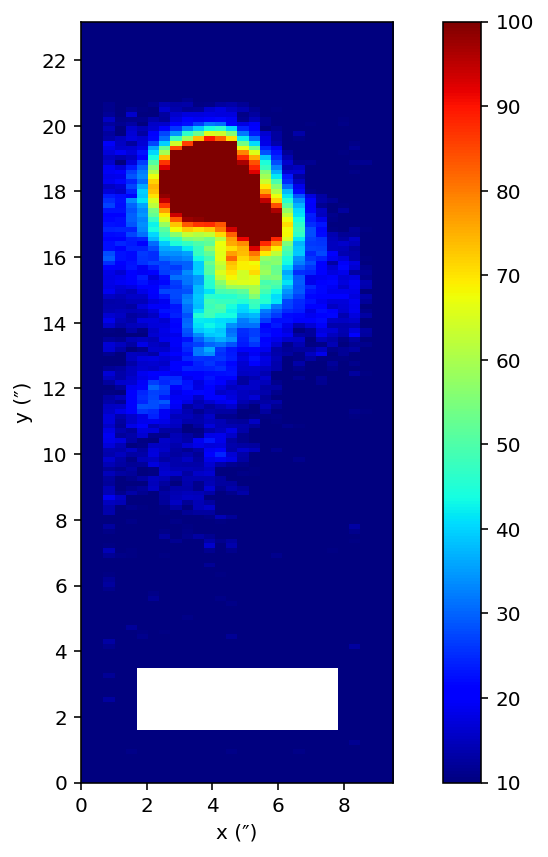

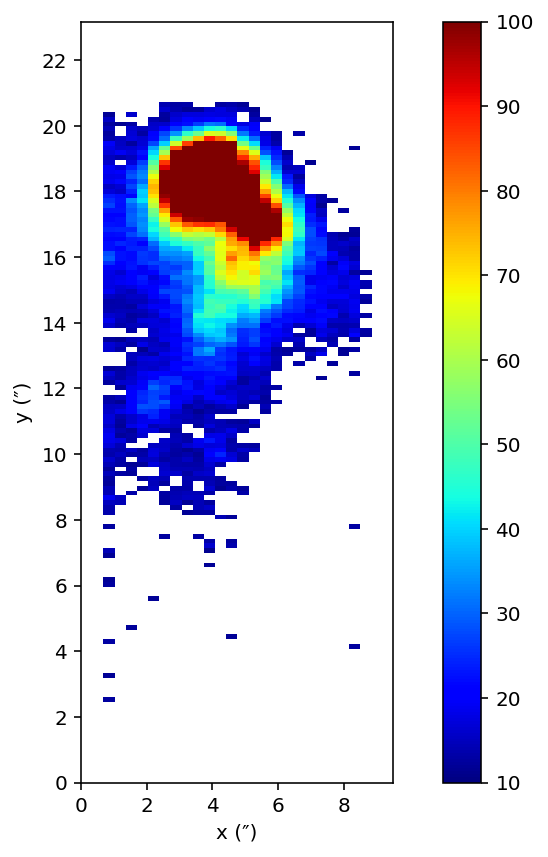

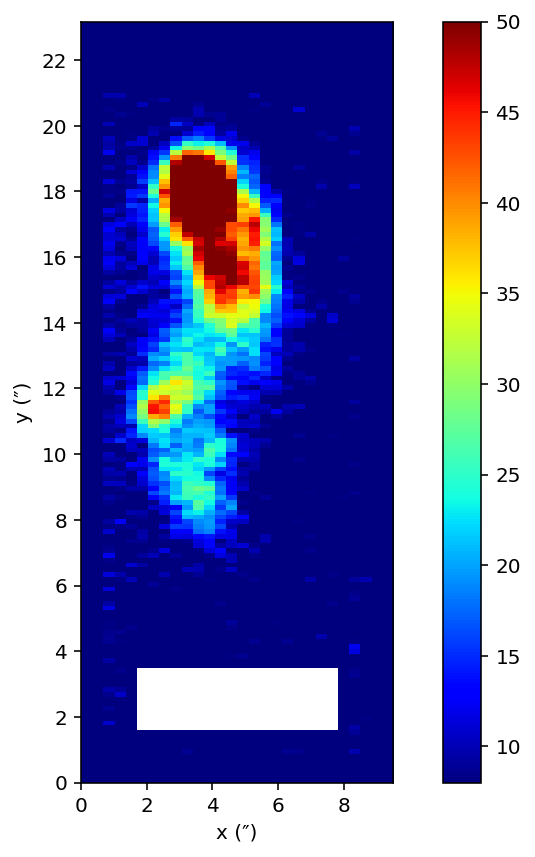

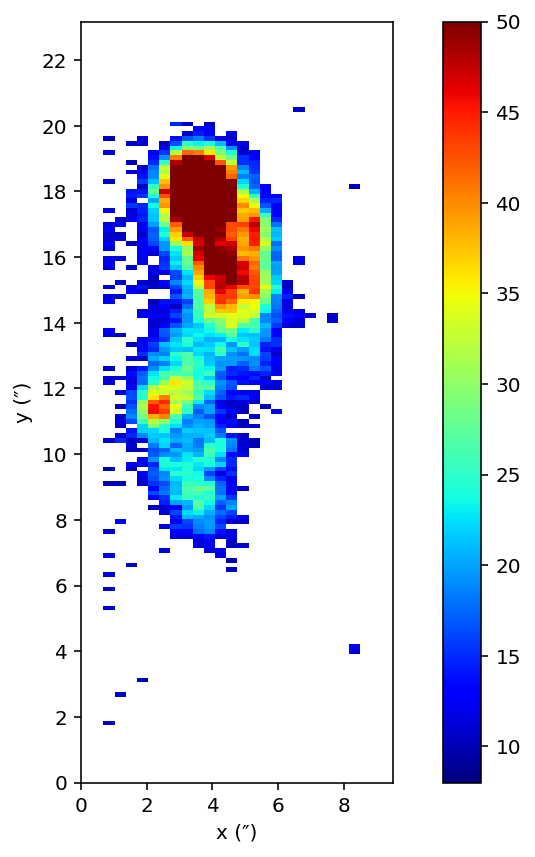

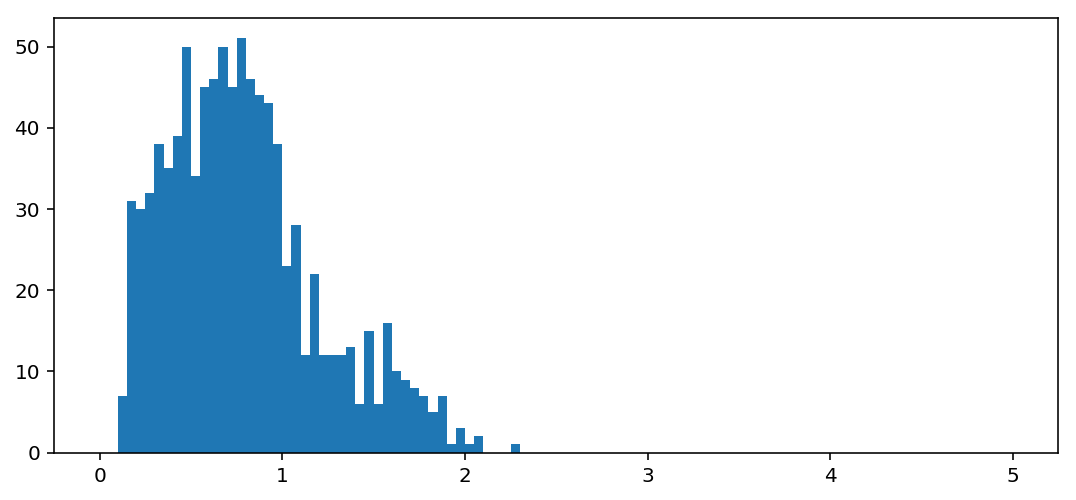

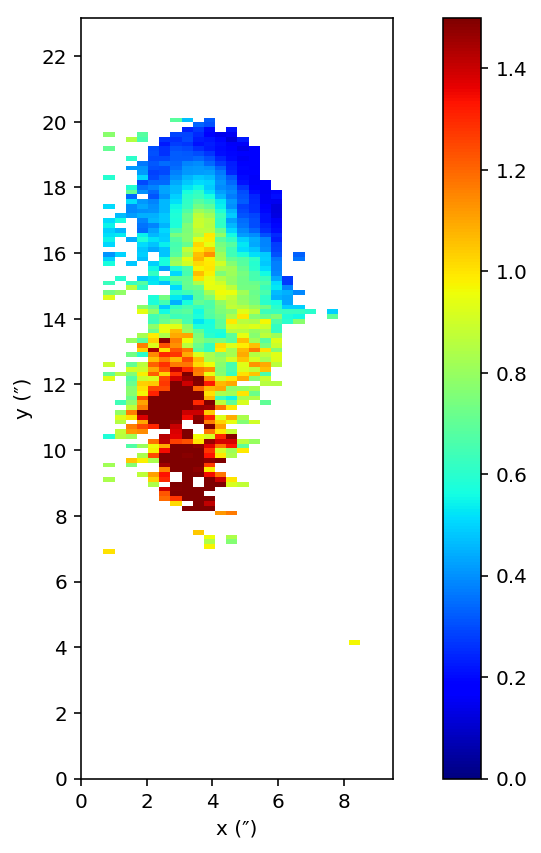

In [5]:
sum_3726 = make_sum(3725.25, 3729.50, "blue")
sum_3726c = remove_noise(sum_3726, 10, 100, 3)

sum_3729 = make_sum(3729.75, 3733.75, "blue")
sum_3729c = remove_noise(sum_3729, 8, 50, 3)

oii_oiic = sum_3729c / sum_3726c
plot_hist(oii_oiic[oii_oiic == oii_oiic], [0, 5])
plot_sum(oii_oiic, 0, 1.5)

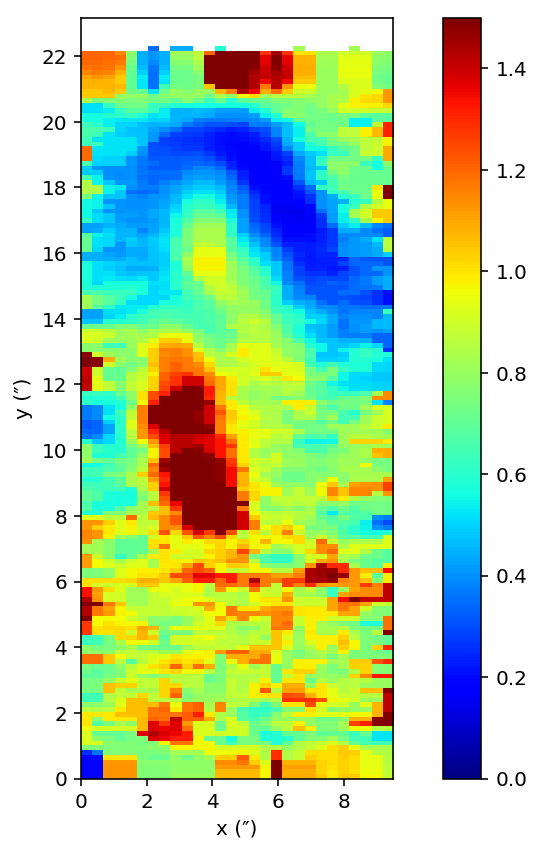

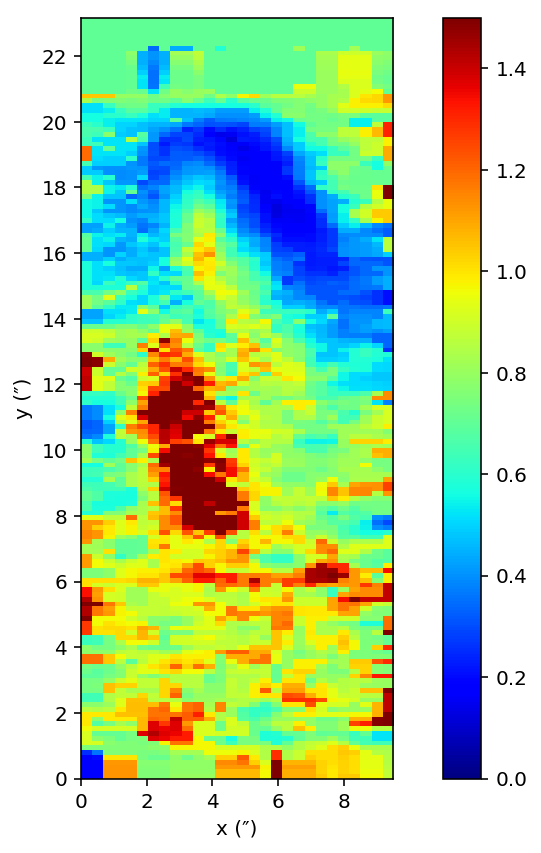

In [6]:
oii_oii_med = ndimage.median_filter(oii_oii, 4)
plot_sum(oii_oii_med, 0, 1.5)
plt.show()

for i in range(16):
    for j in range(len(oii_oii_med[0])):
        if oii_oii_med[i][j] != oii_oii_med[i][j]  or oii_oii_med[i][j] > 1 :
            oii_oii_med[i][j] = 0.7
            
for i in range(len(oii_oii_med)): 
    for j in range(len(oii_oii_med[0])):
        if oii_oiic[i][j] == oii_oiic[i][j]:
            oii_oii_med[i][j] = oii_oiic[i][j]
            
plot_sum(oii_oii_med, 0, 1.5)

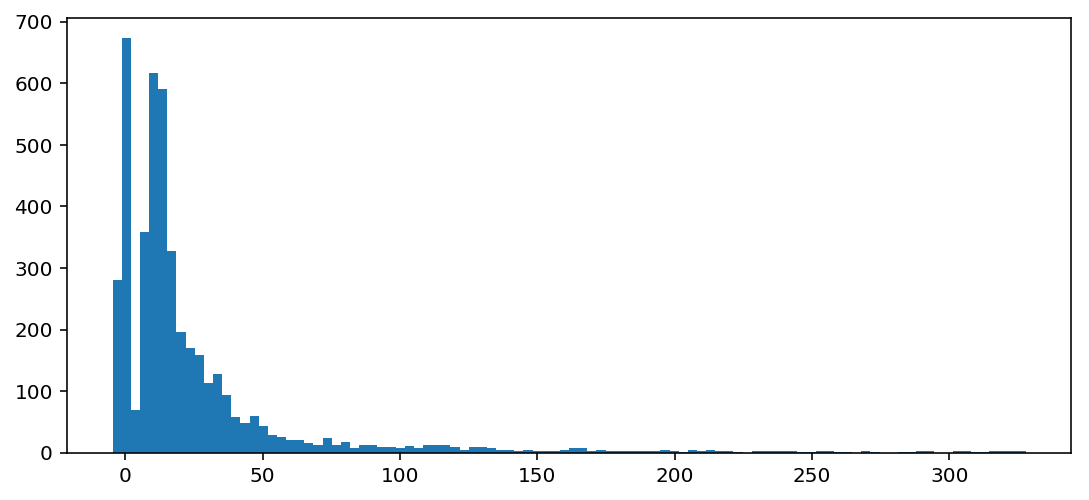

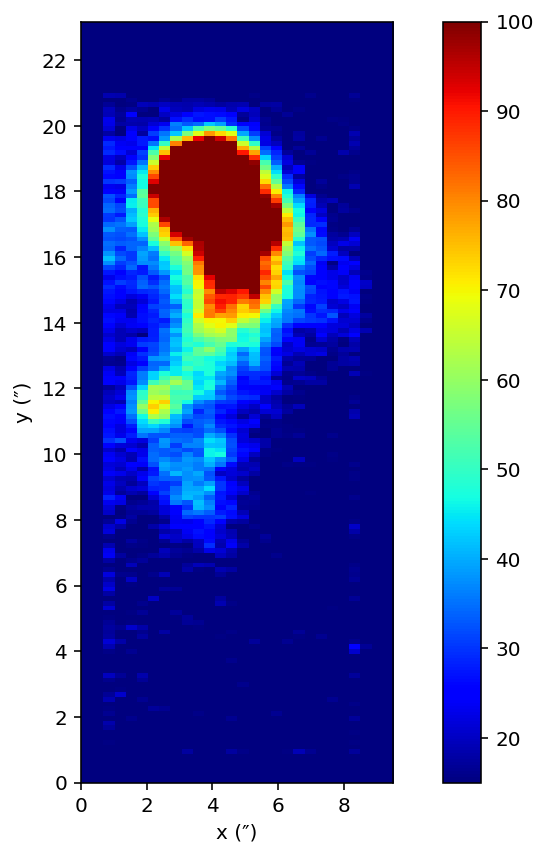

In [7]:
sum_3727 = make_sum(3725.25, 3733.75, "blue")
plot_hist(sum_3727)
plot_sum(sum_3727, 15, 100)

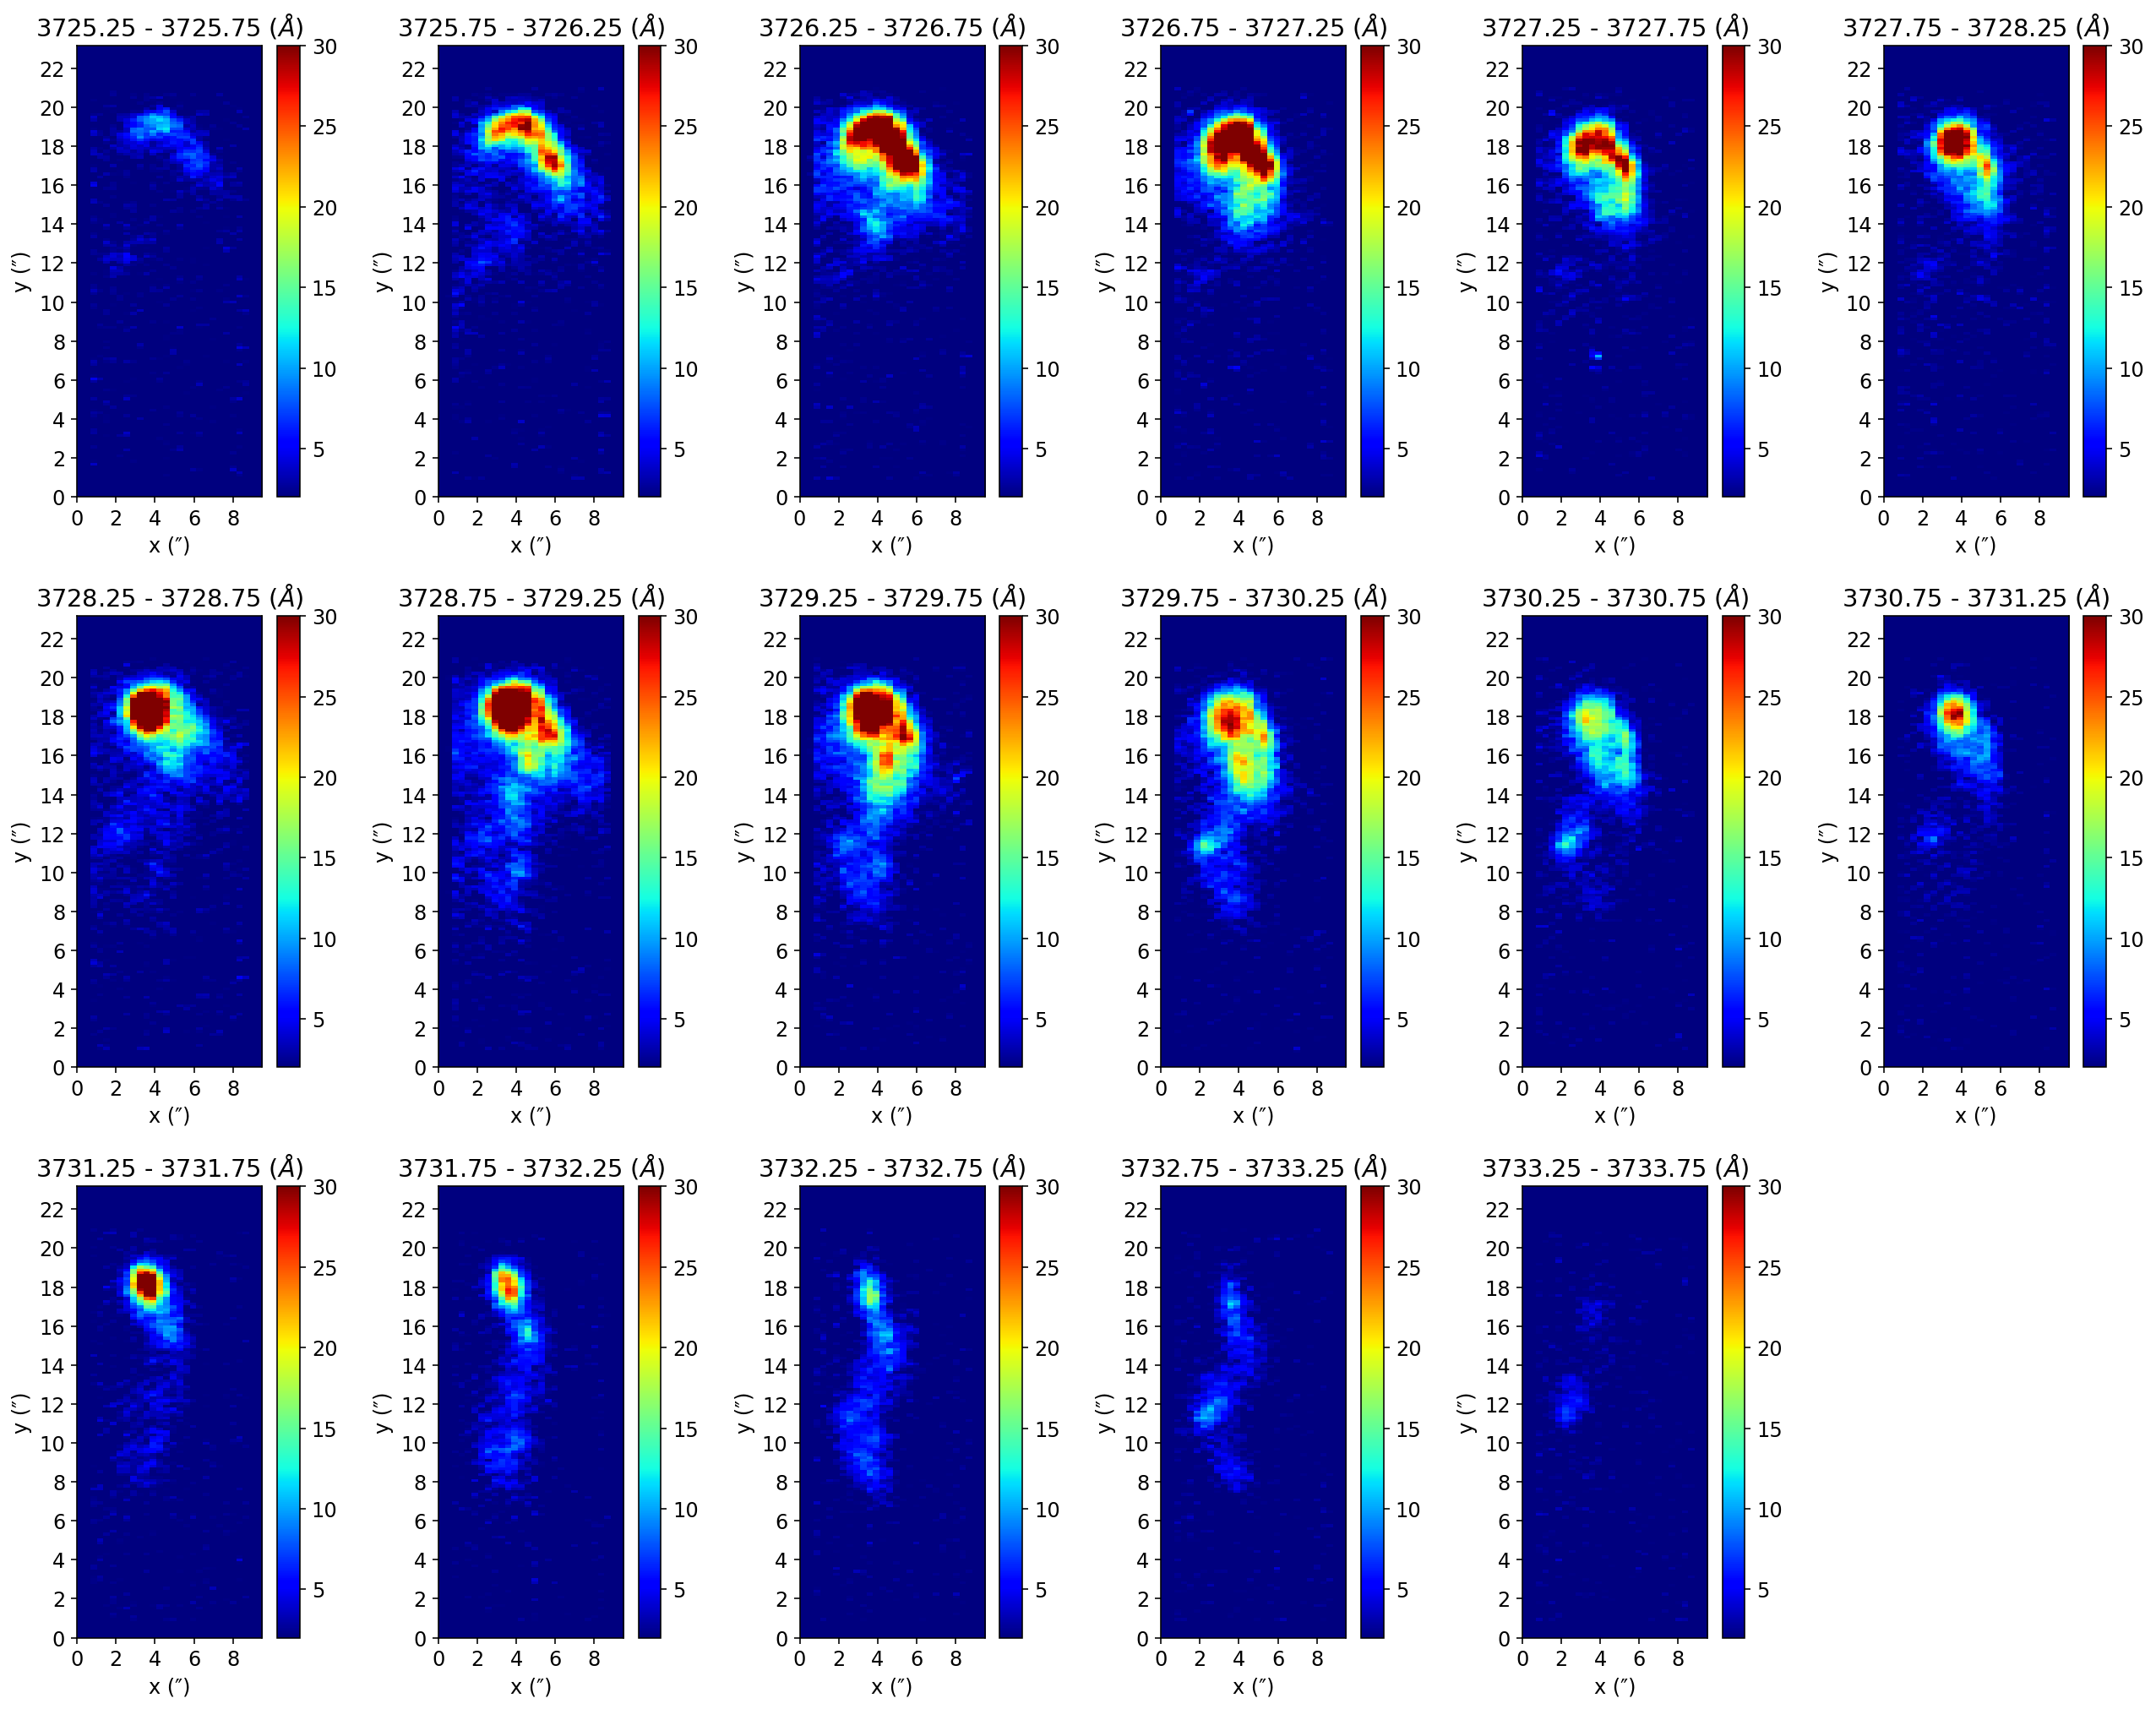

In [8]:
plt.rcParams.update({'font.size': 12})

make_bin(3725.25, 3733.75, 0.5, "blue", 2, 30, 6, (18, 70))

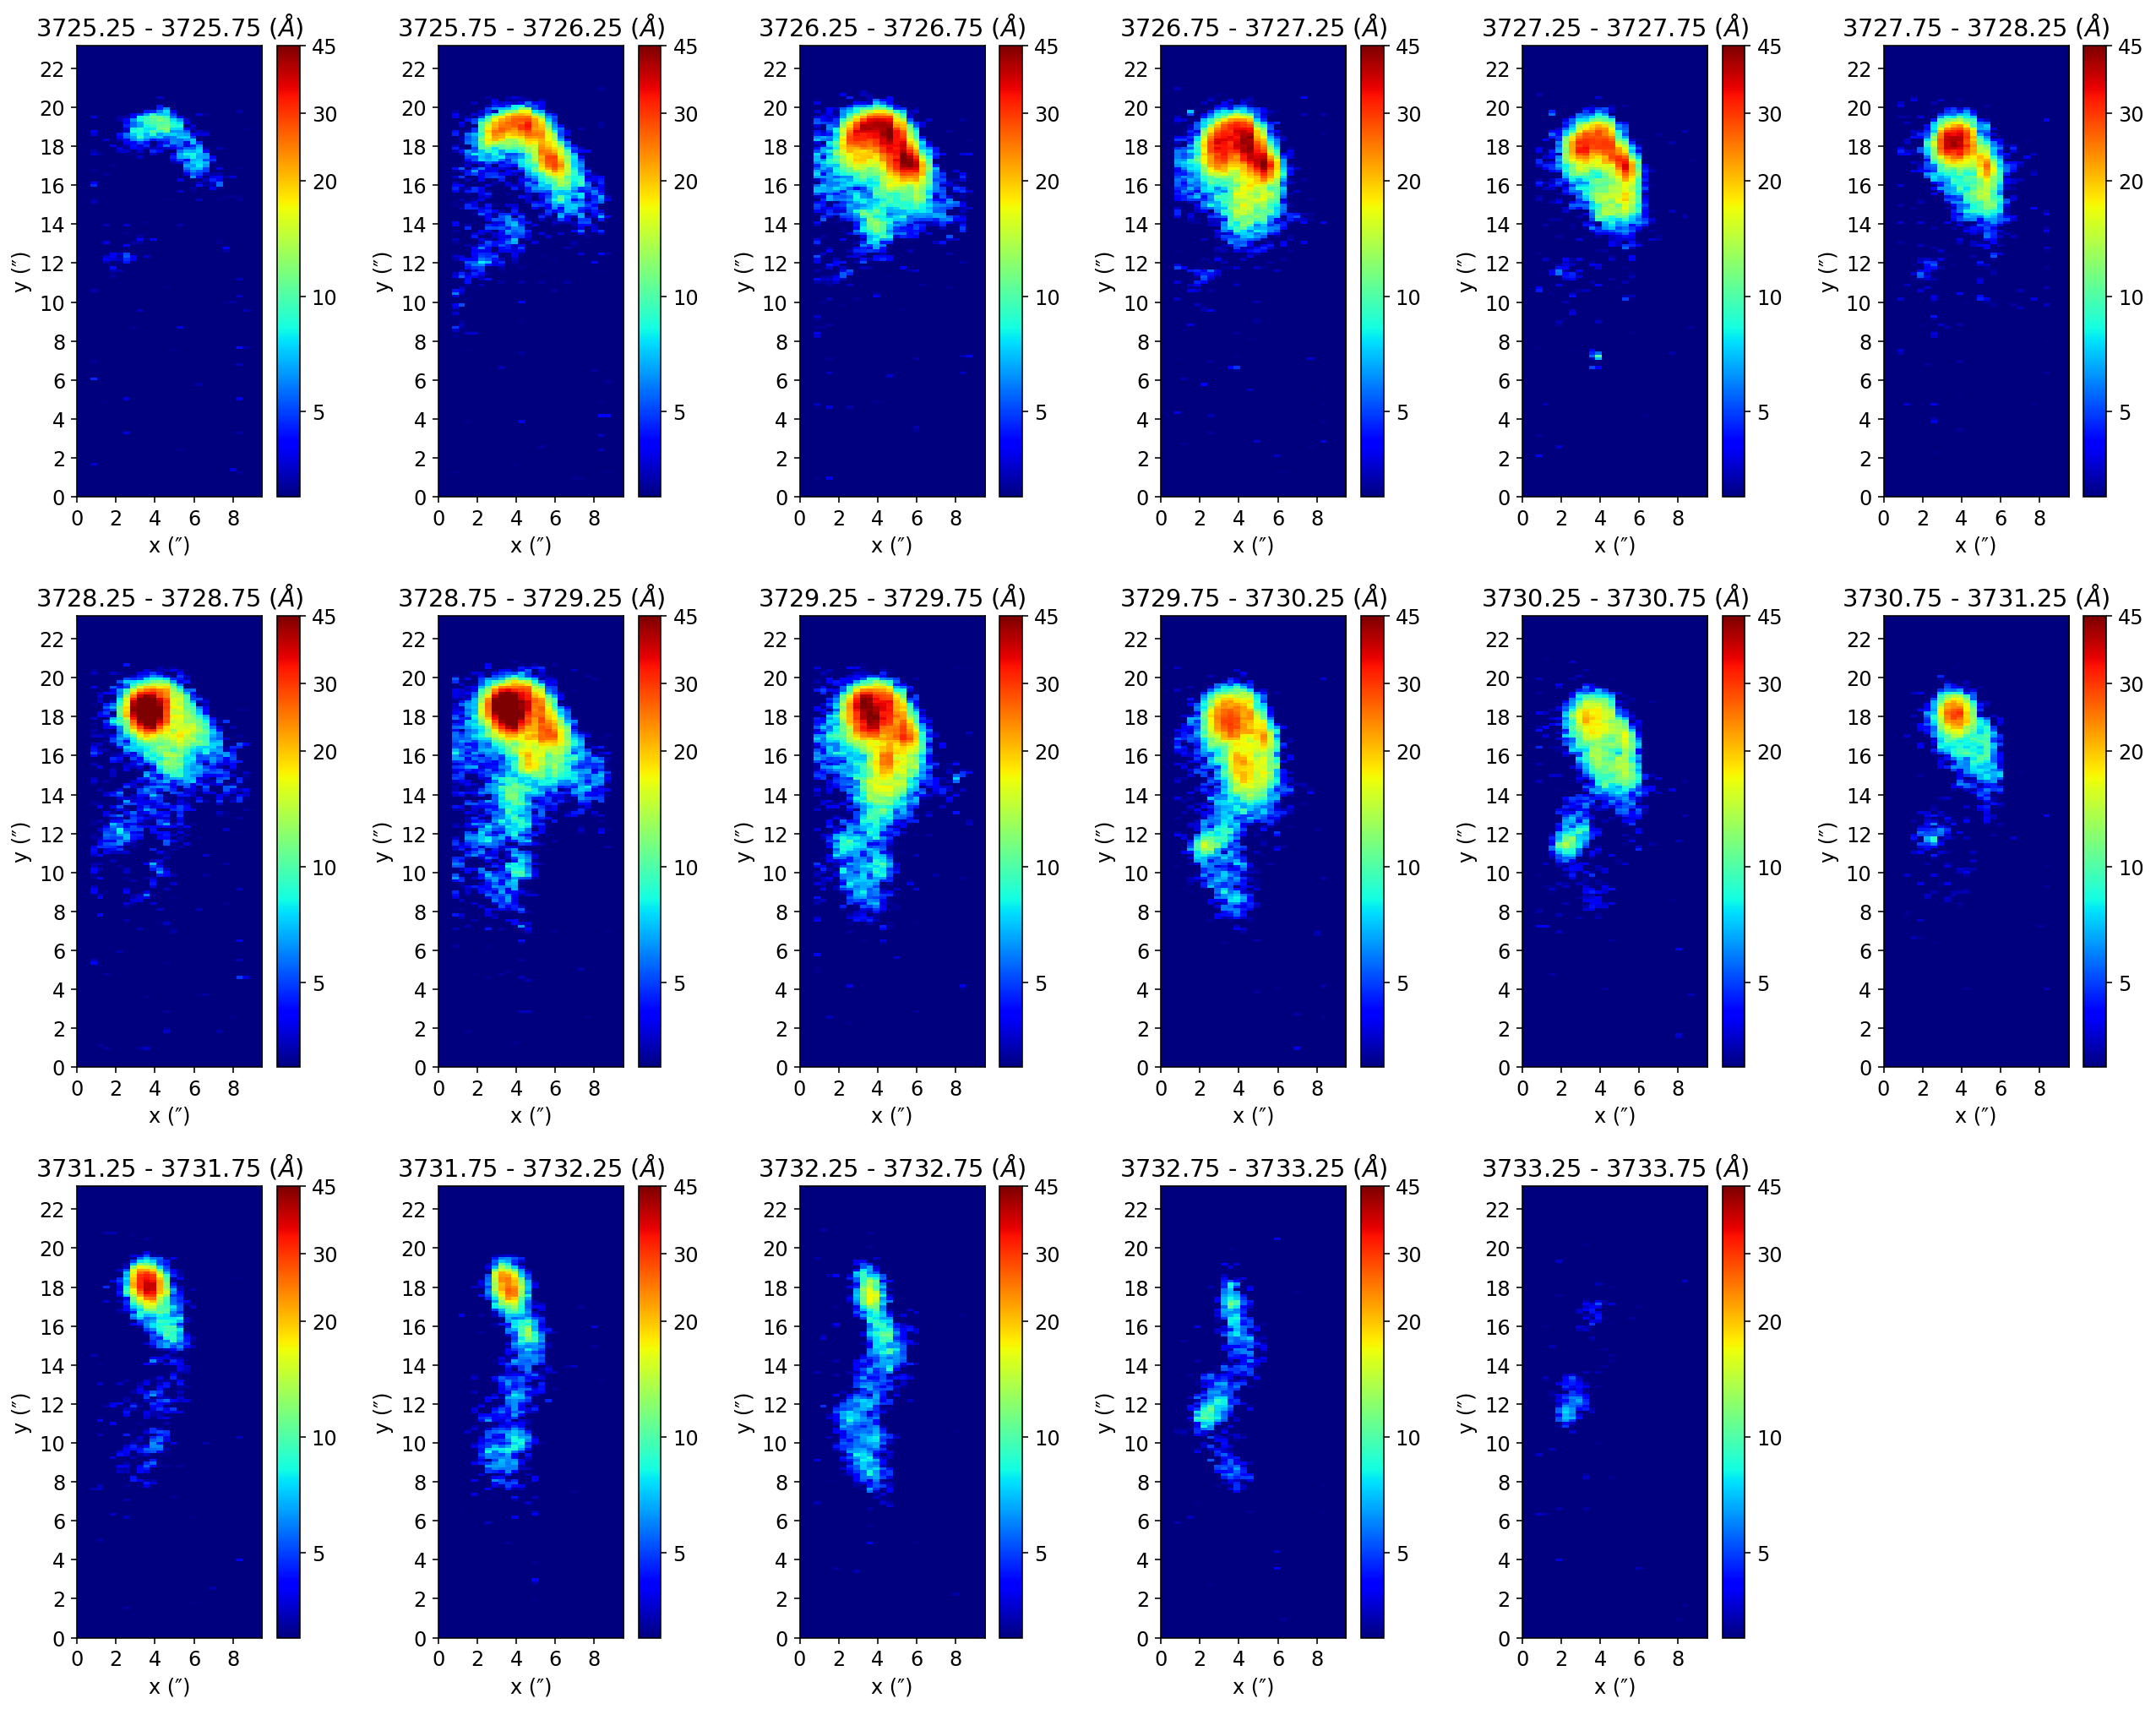

In [9]:
make_bin(3725.25, 3733.75, 0.5, "blue", 3, 45, 6, (18, 70), [5, 10, 20, 30, 45])

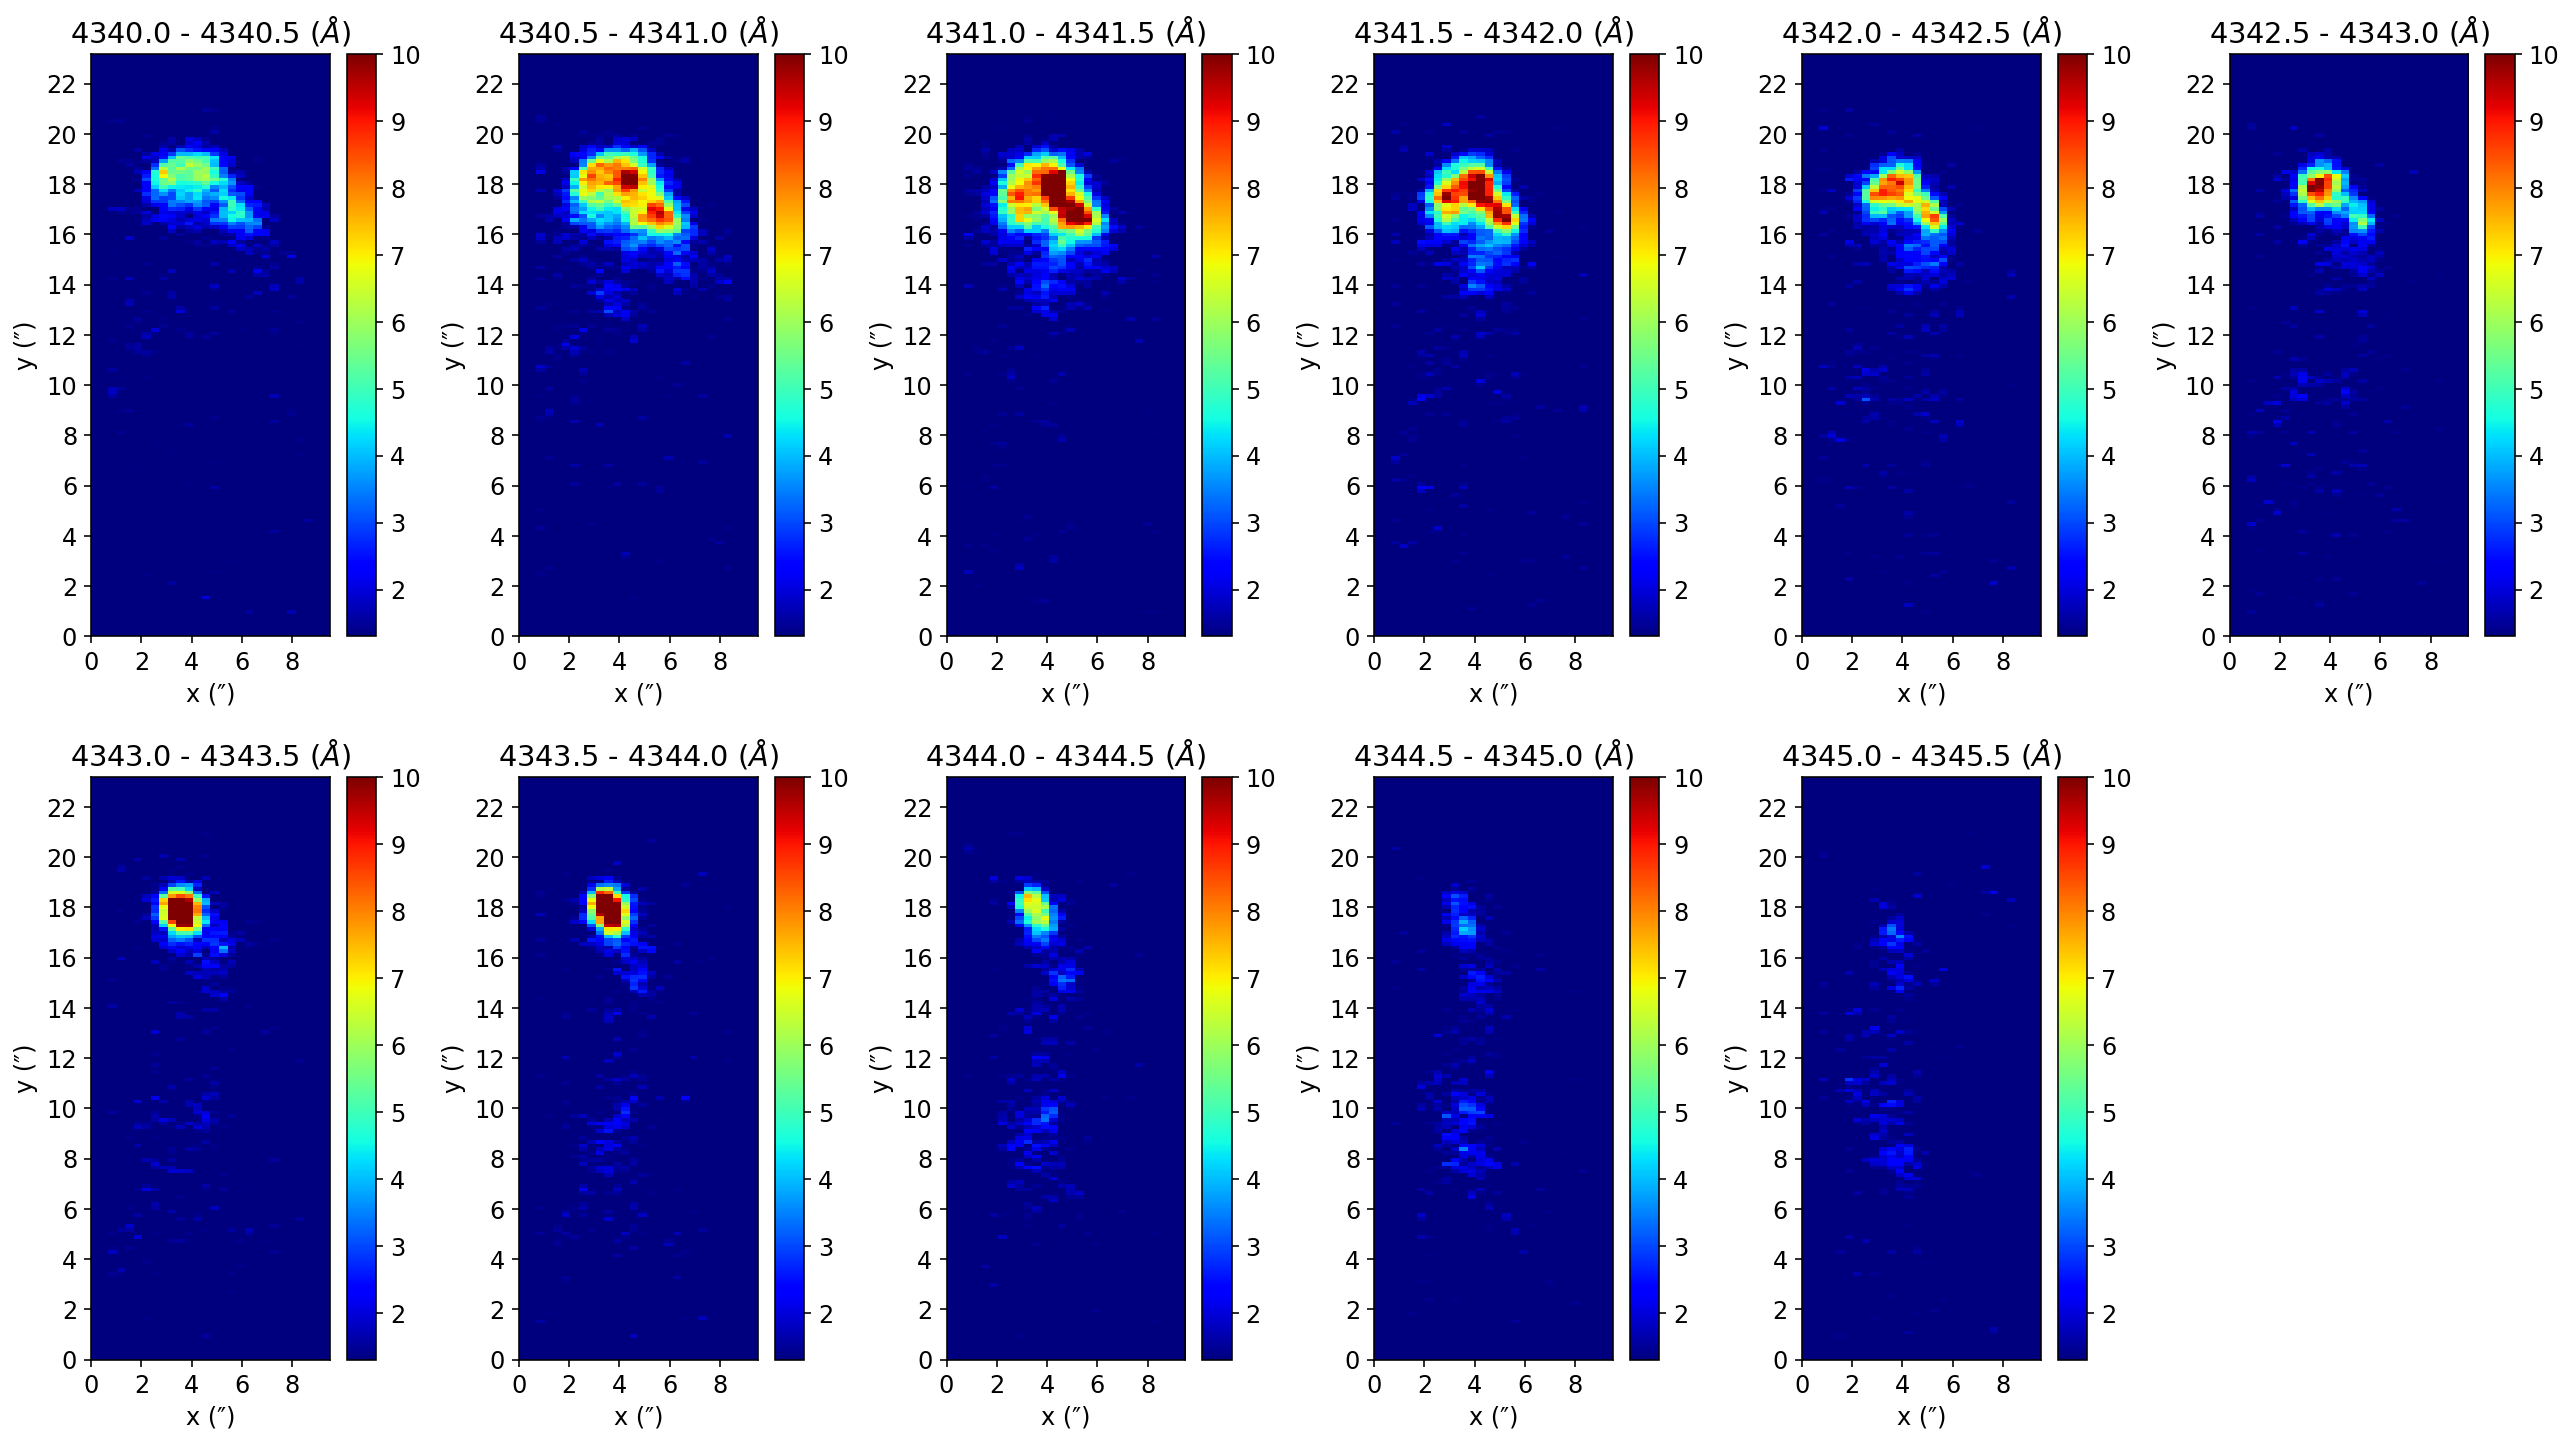

In [10]:
make_bin(4340.00, 4345.25, 0.5, "blue", 1.3, 10, 6, (18, 75))

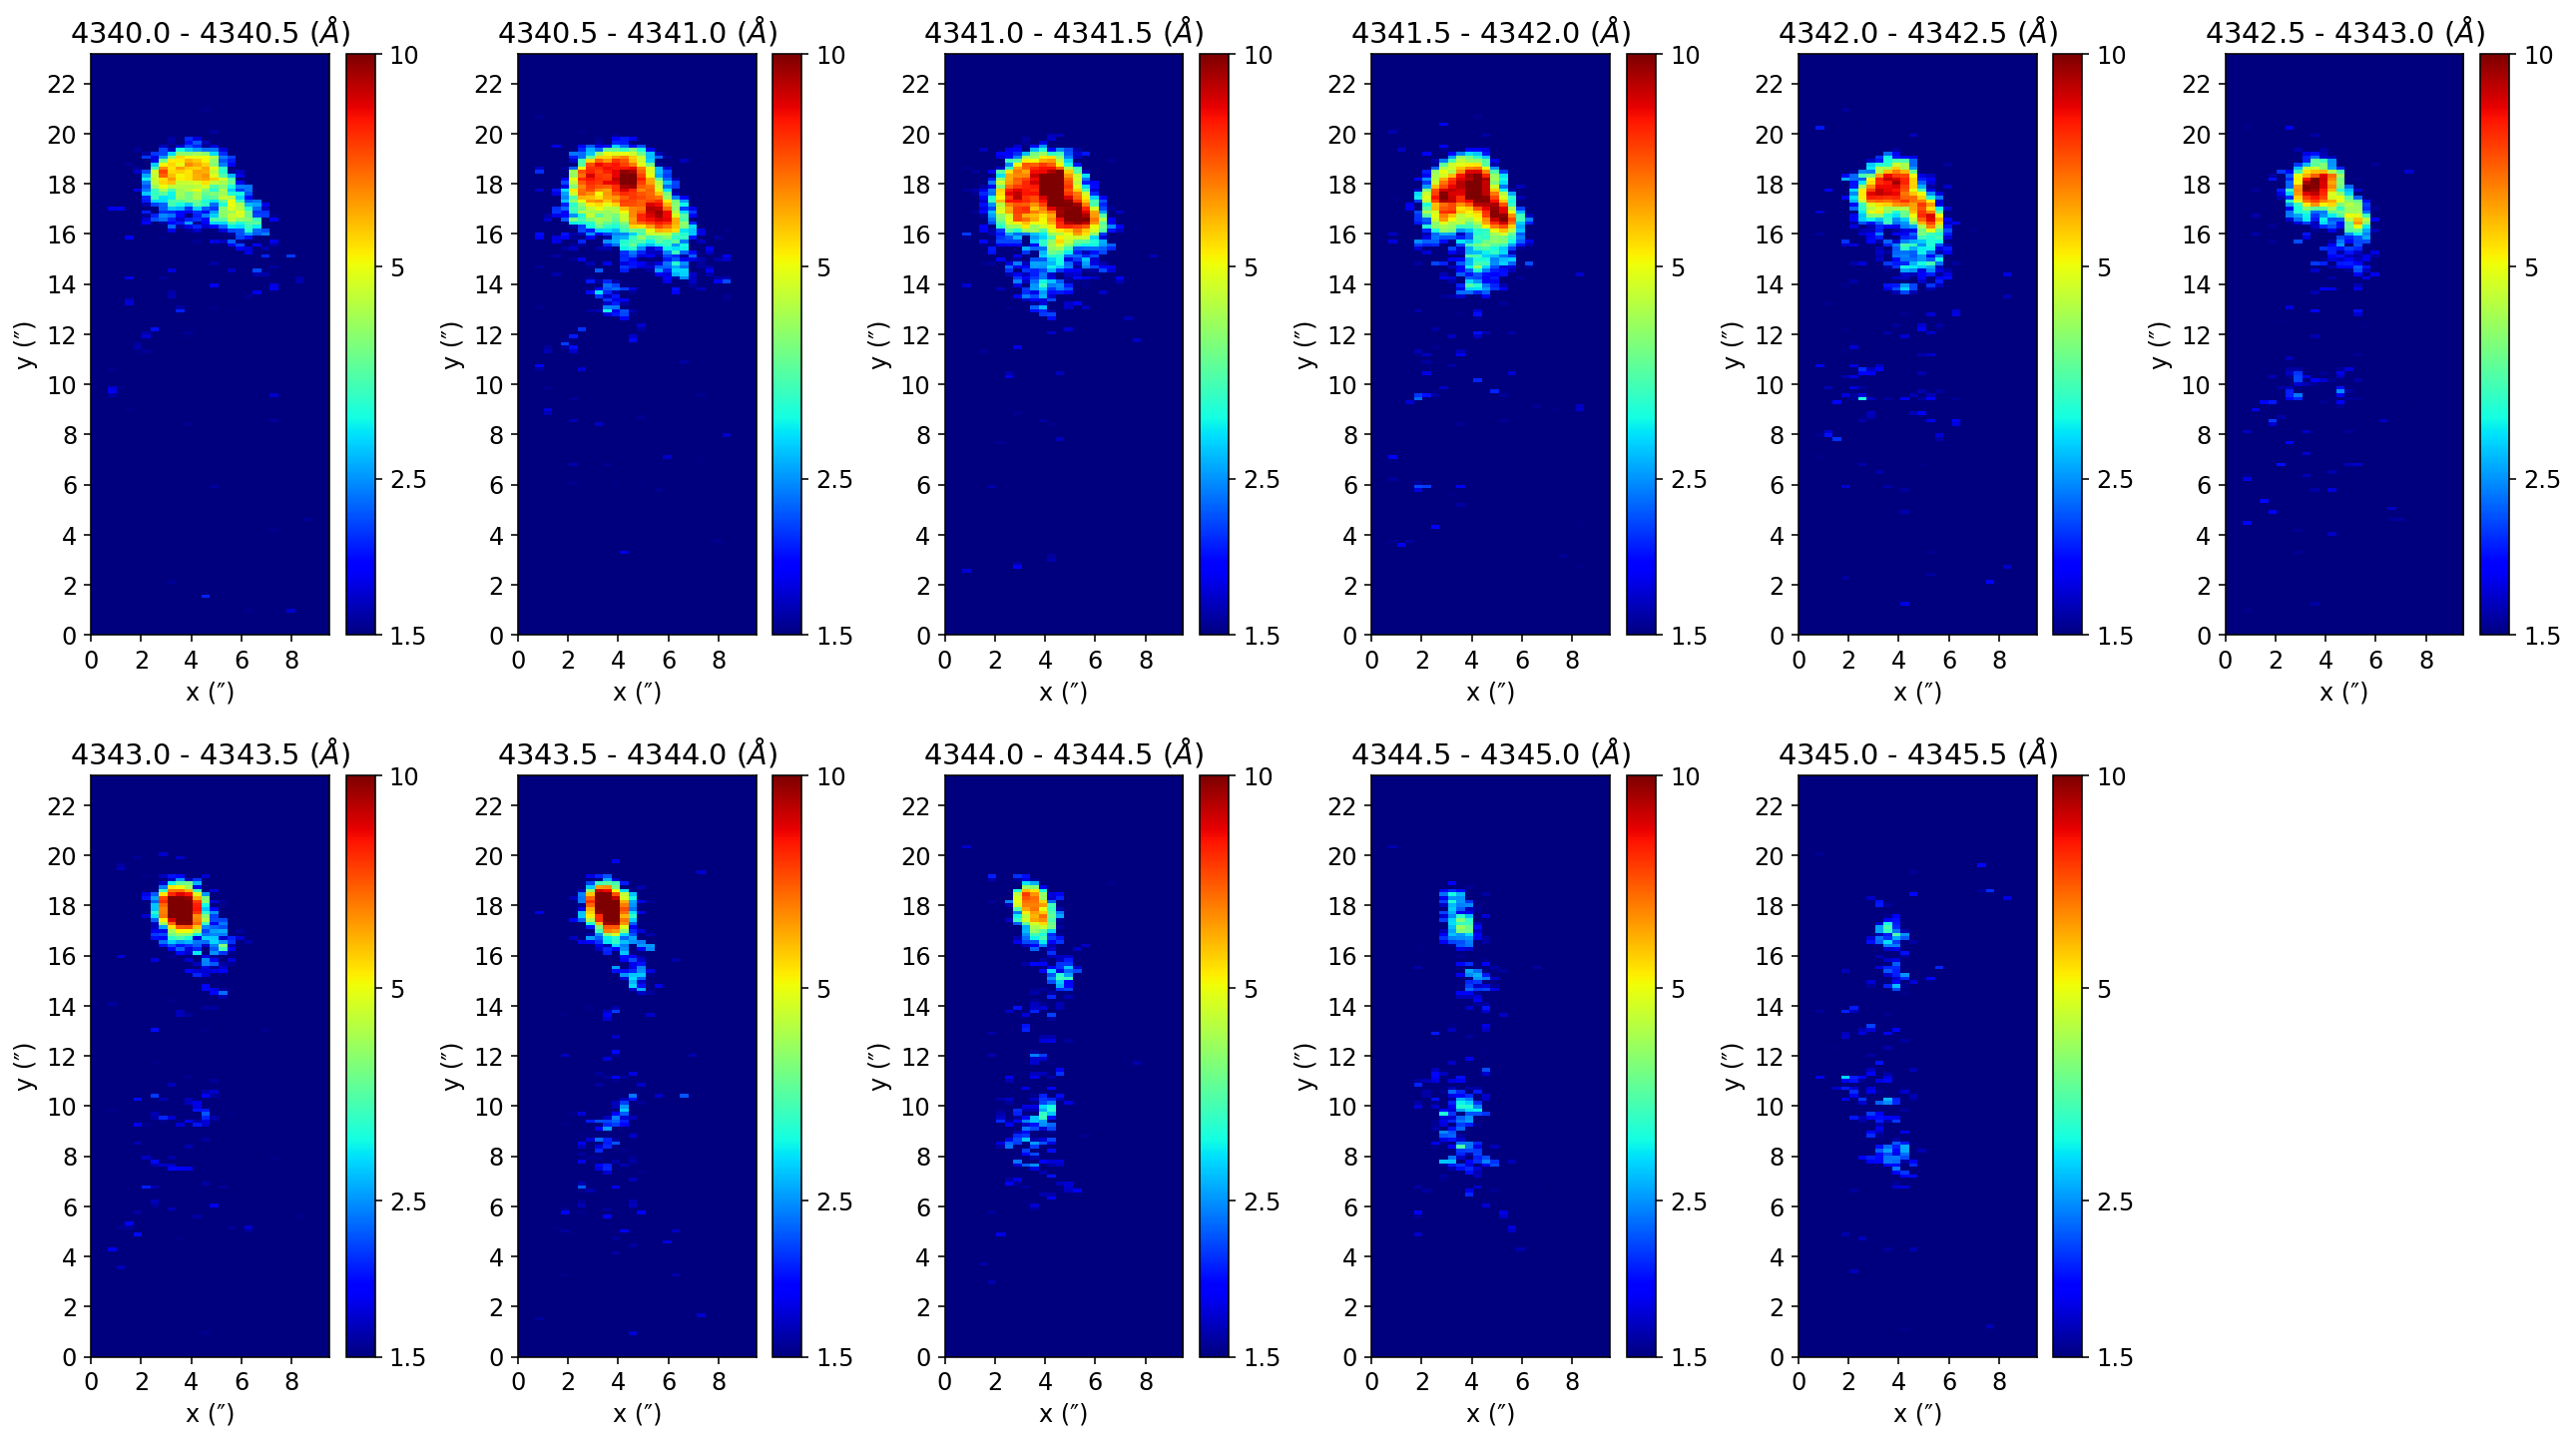

In [11]:
make_bin(4340.00, 4345.25, 0.5, "blue", 1.5, 10, 6, (18, 75), [1.5, 2.5, 5, 10])

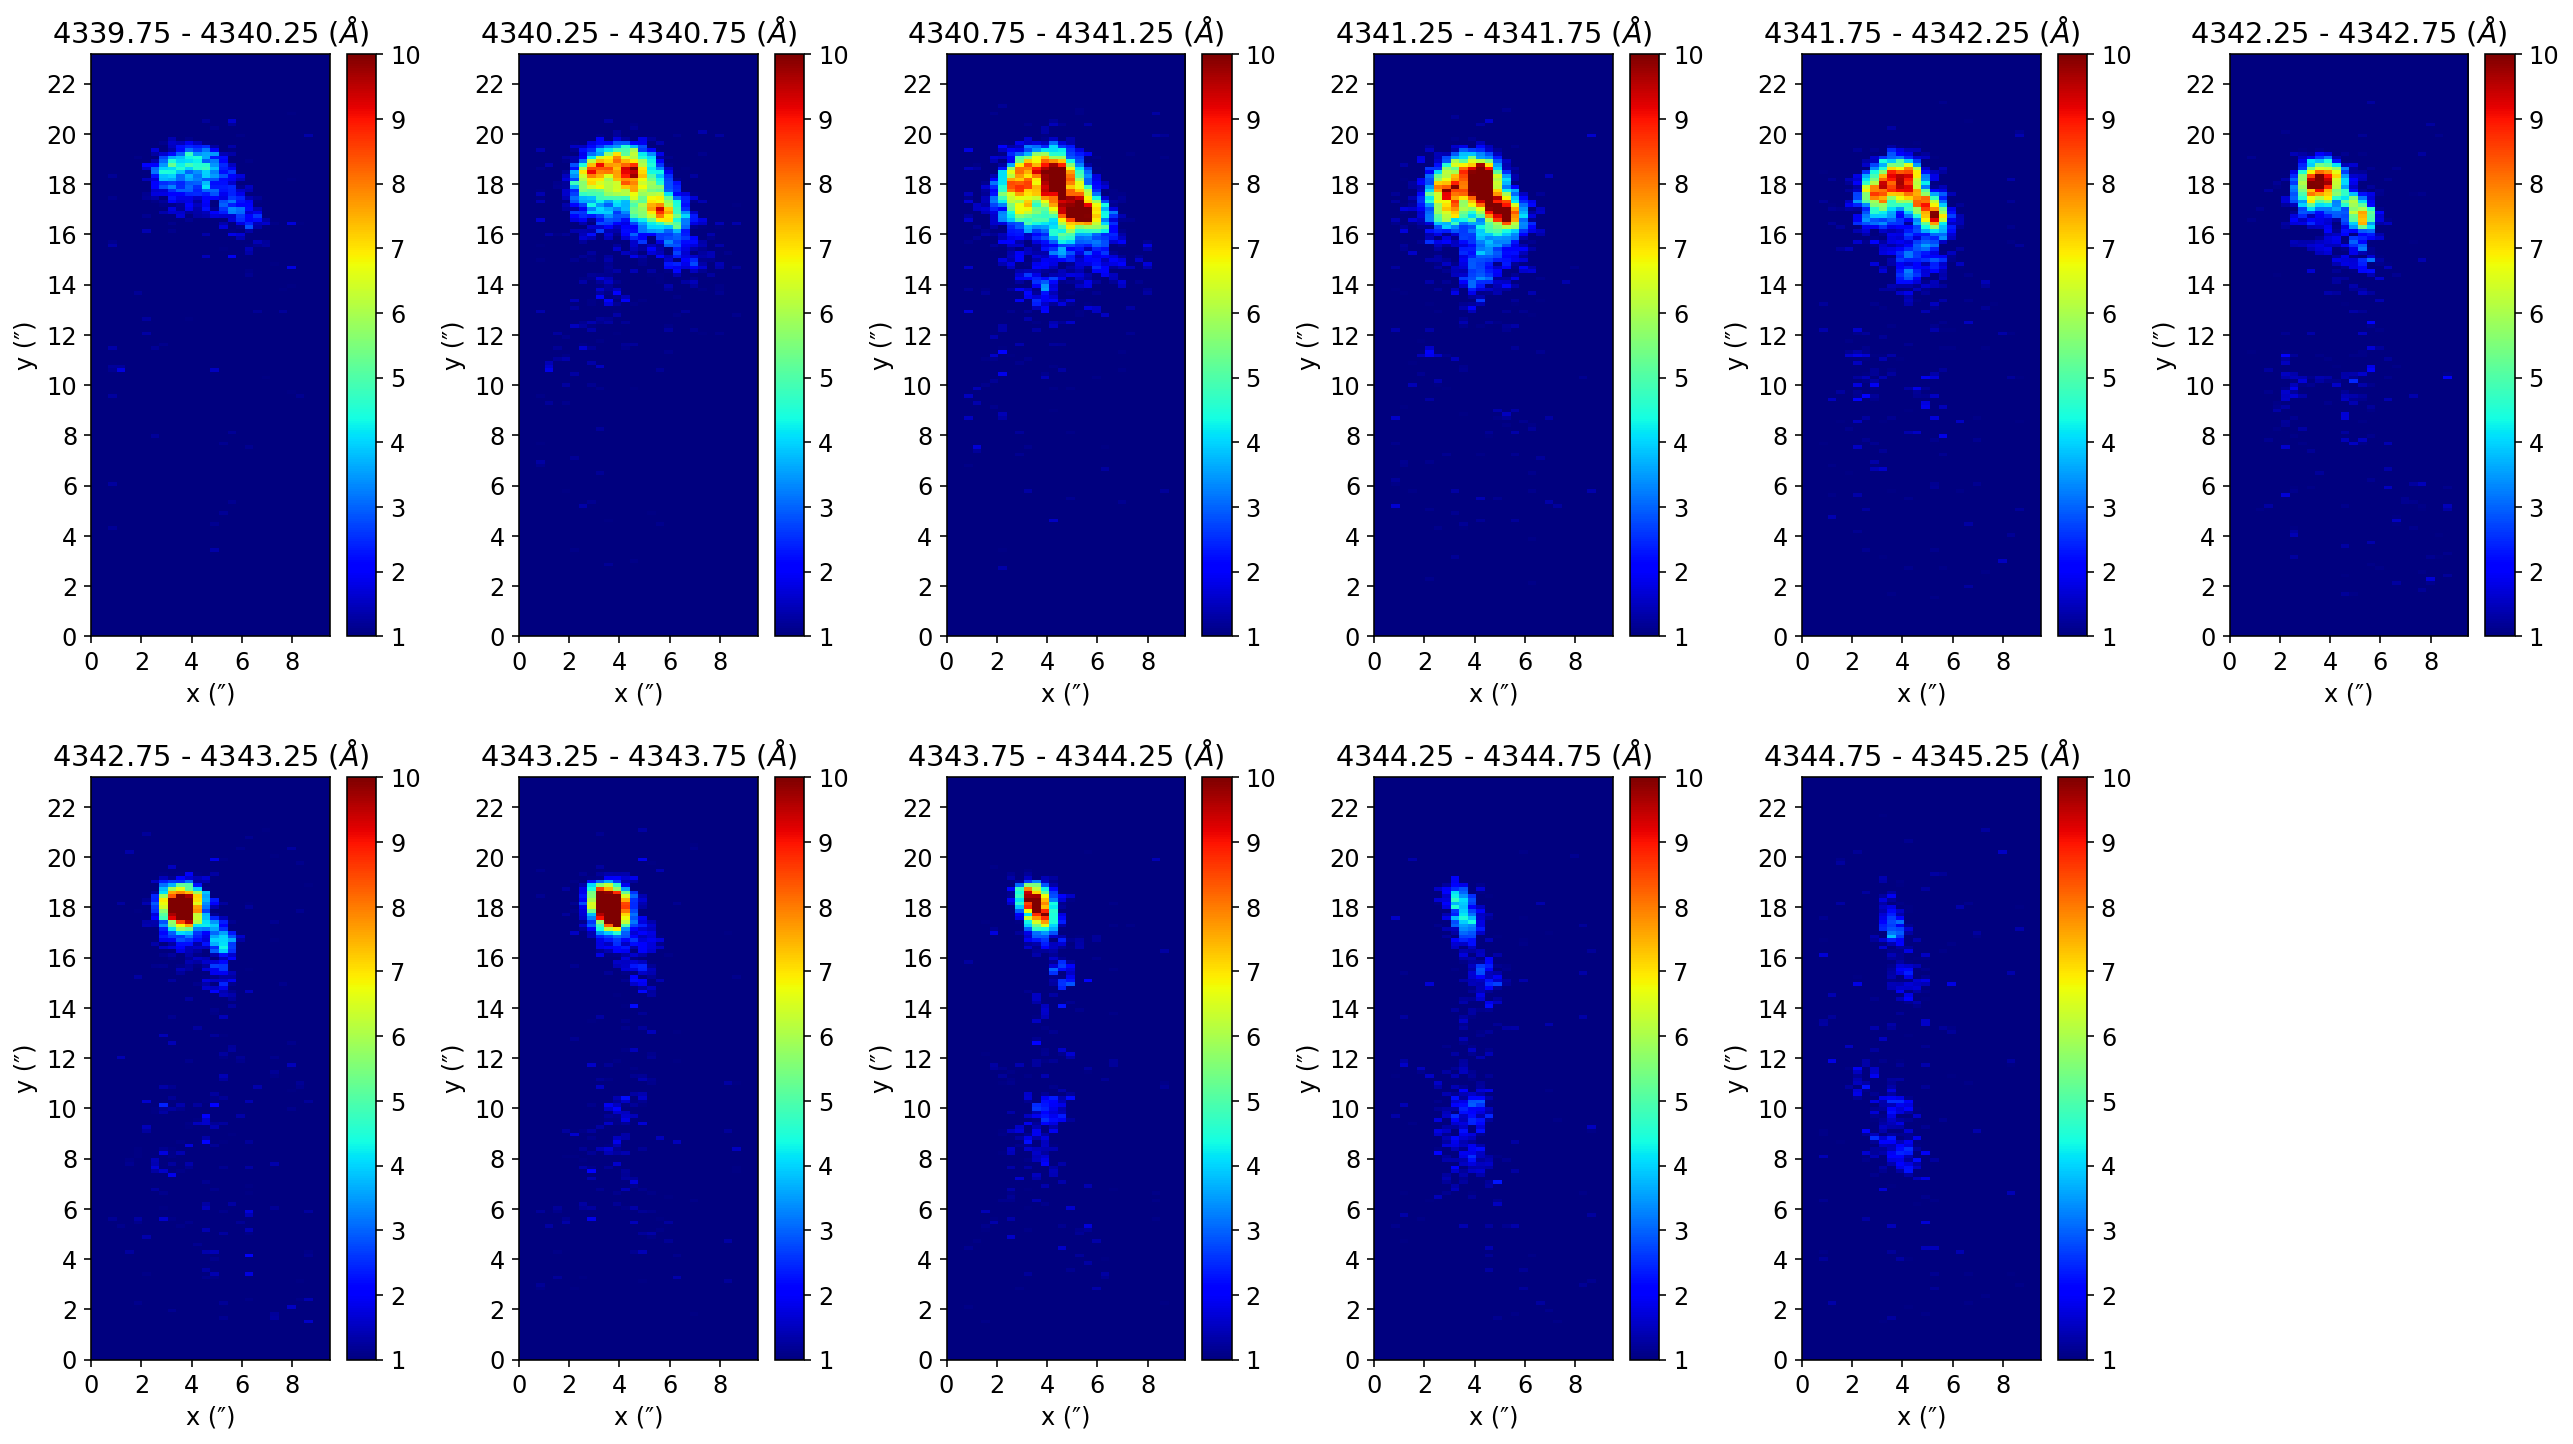

In [12]:
make_bin(4339.75, 4345.25, 0.5, "green", 1, 10, 6, (18, 75))

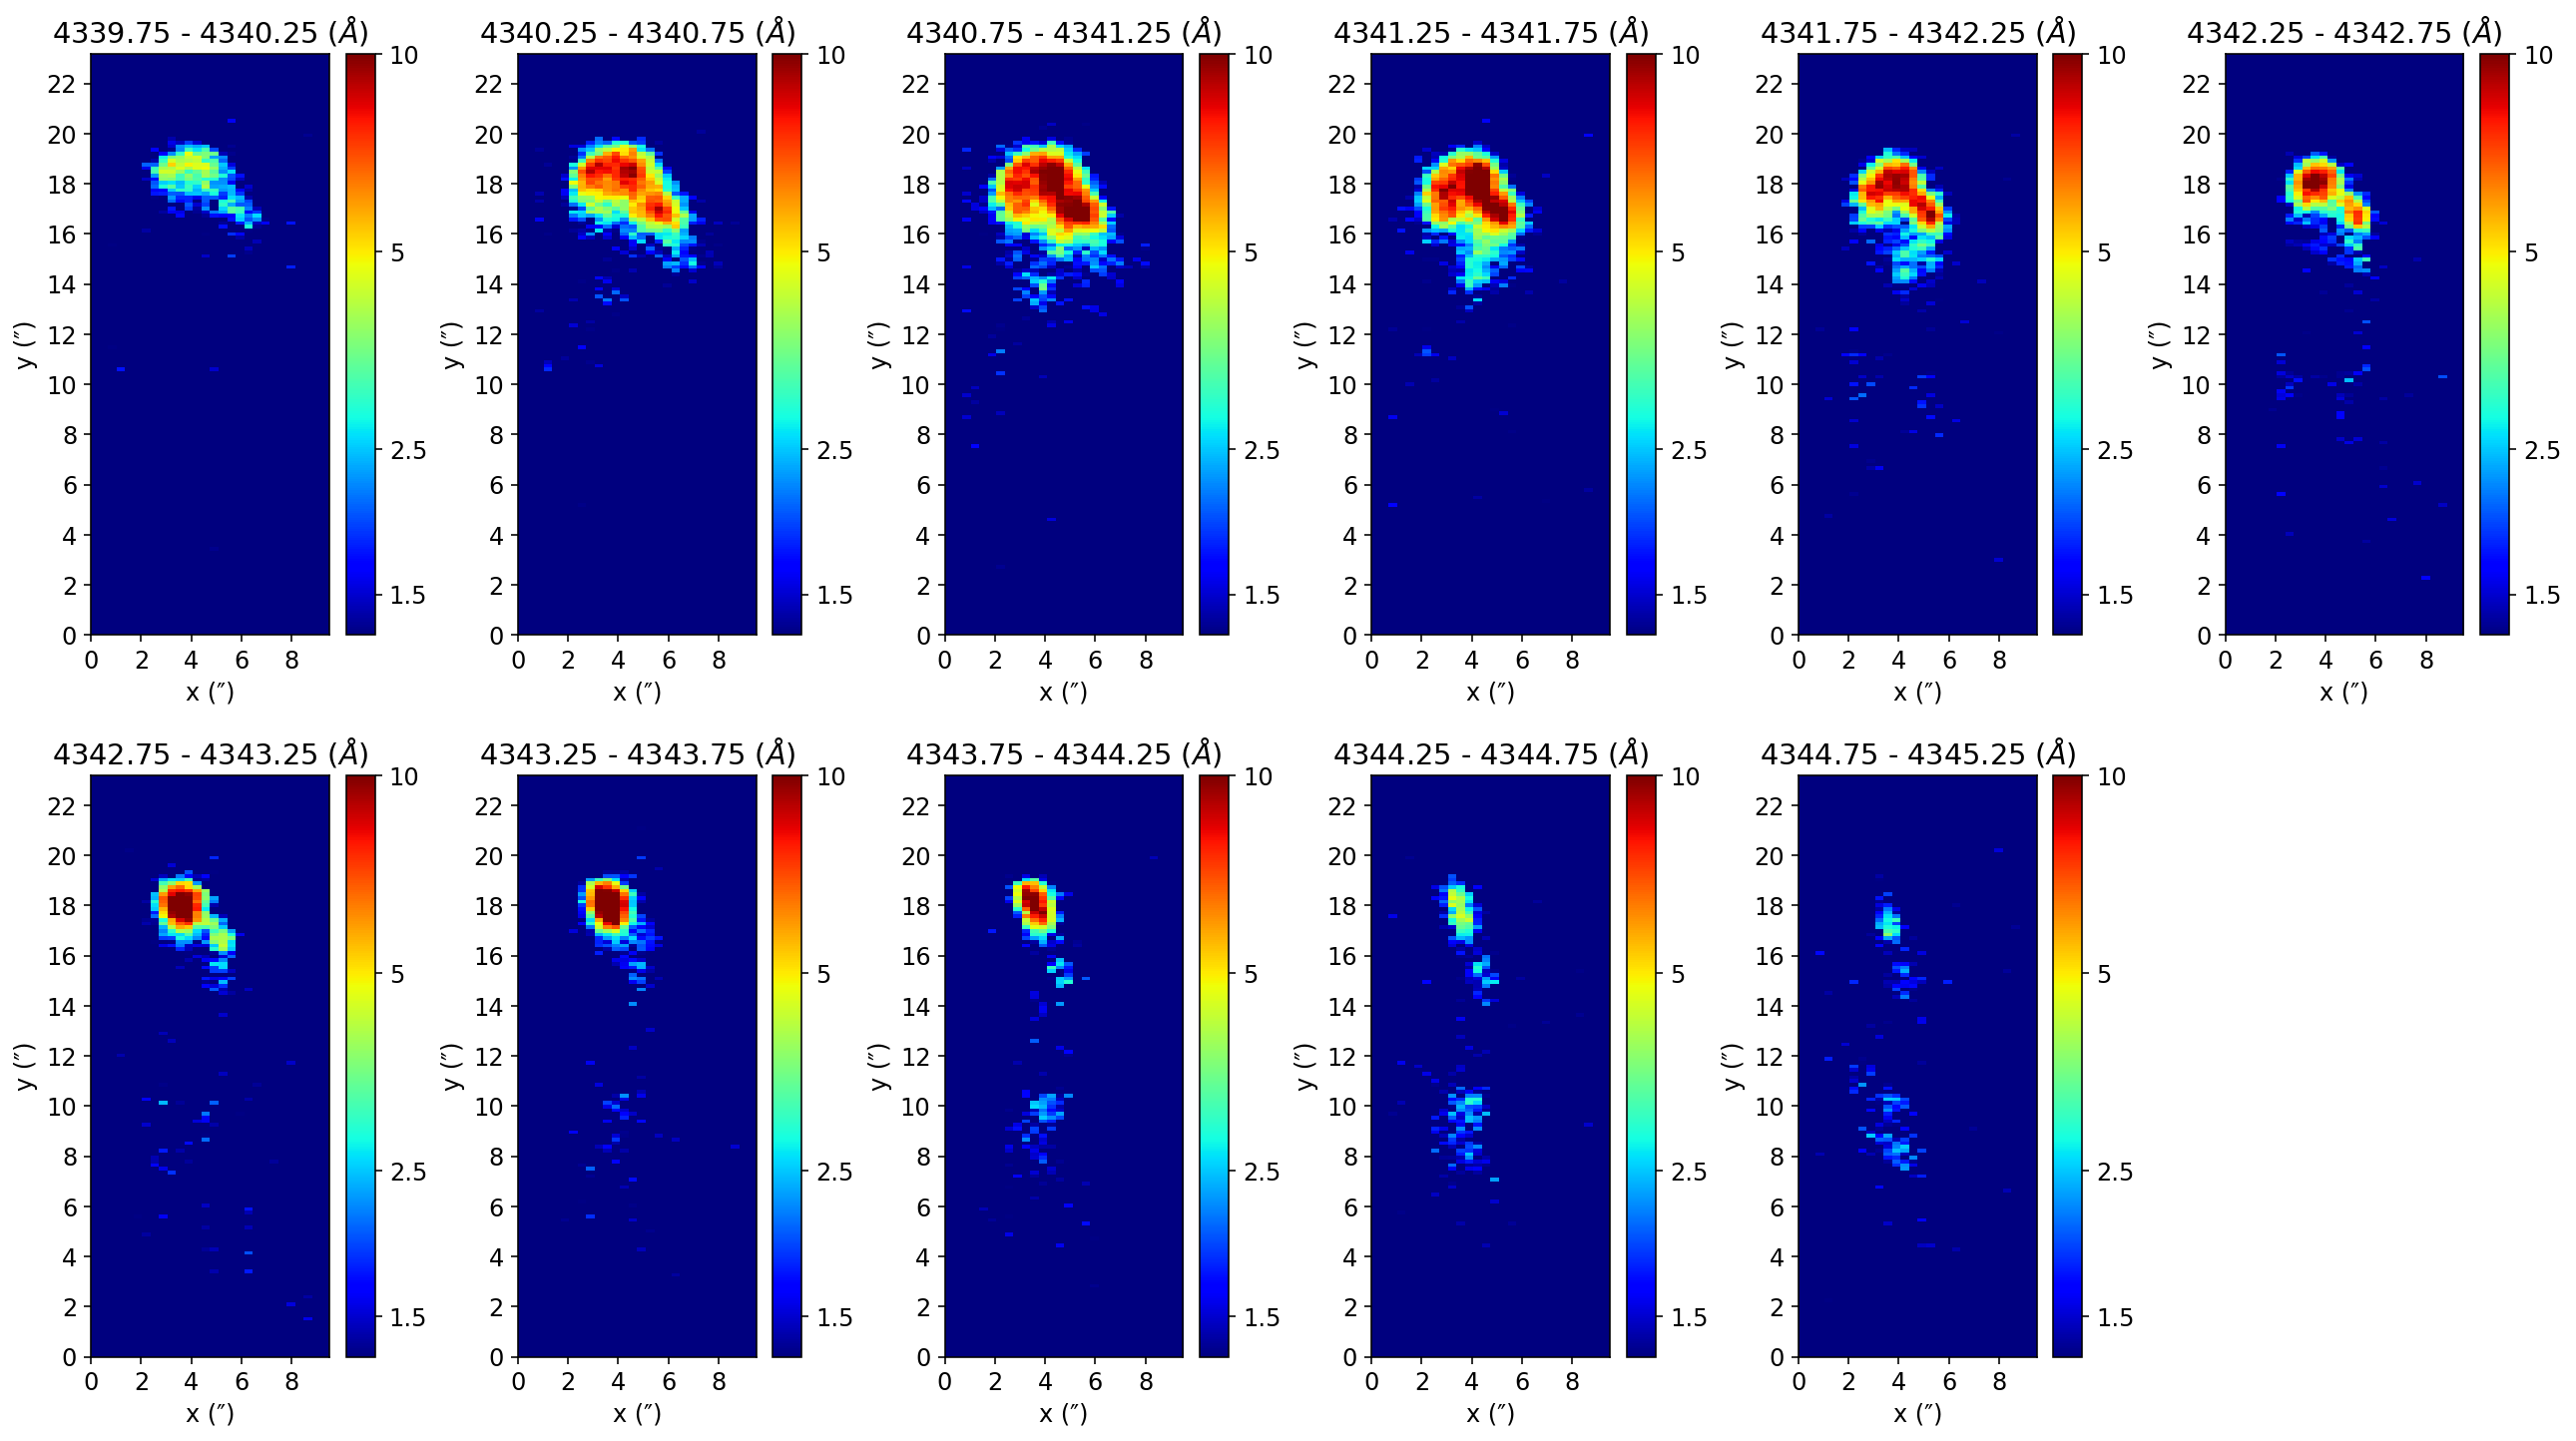

In [13]:
make_bin(4339.75, 4345.25, 0.5, "green", 1.3, 10, 6, (18, 75), [1.5, 2.5, 5, 10])

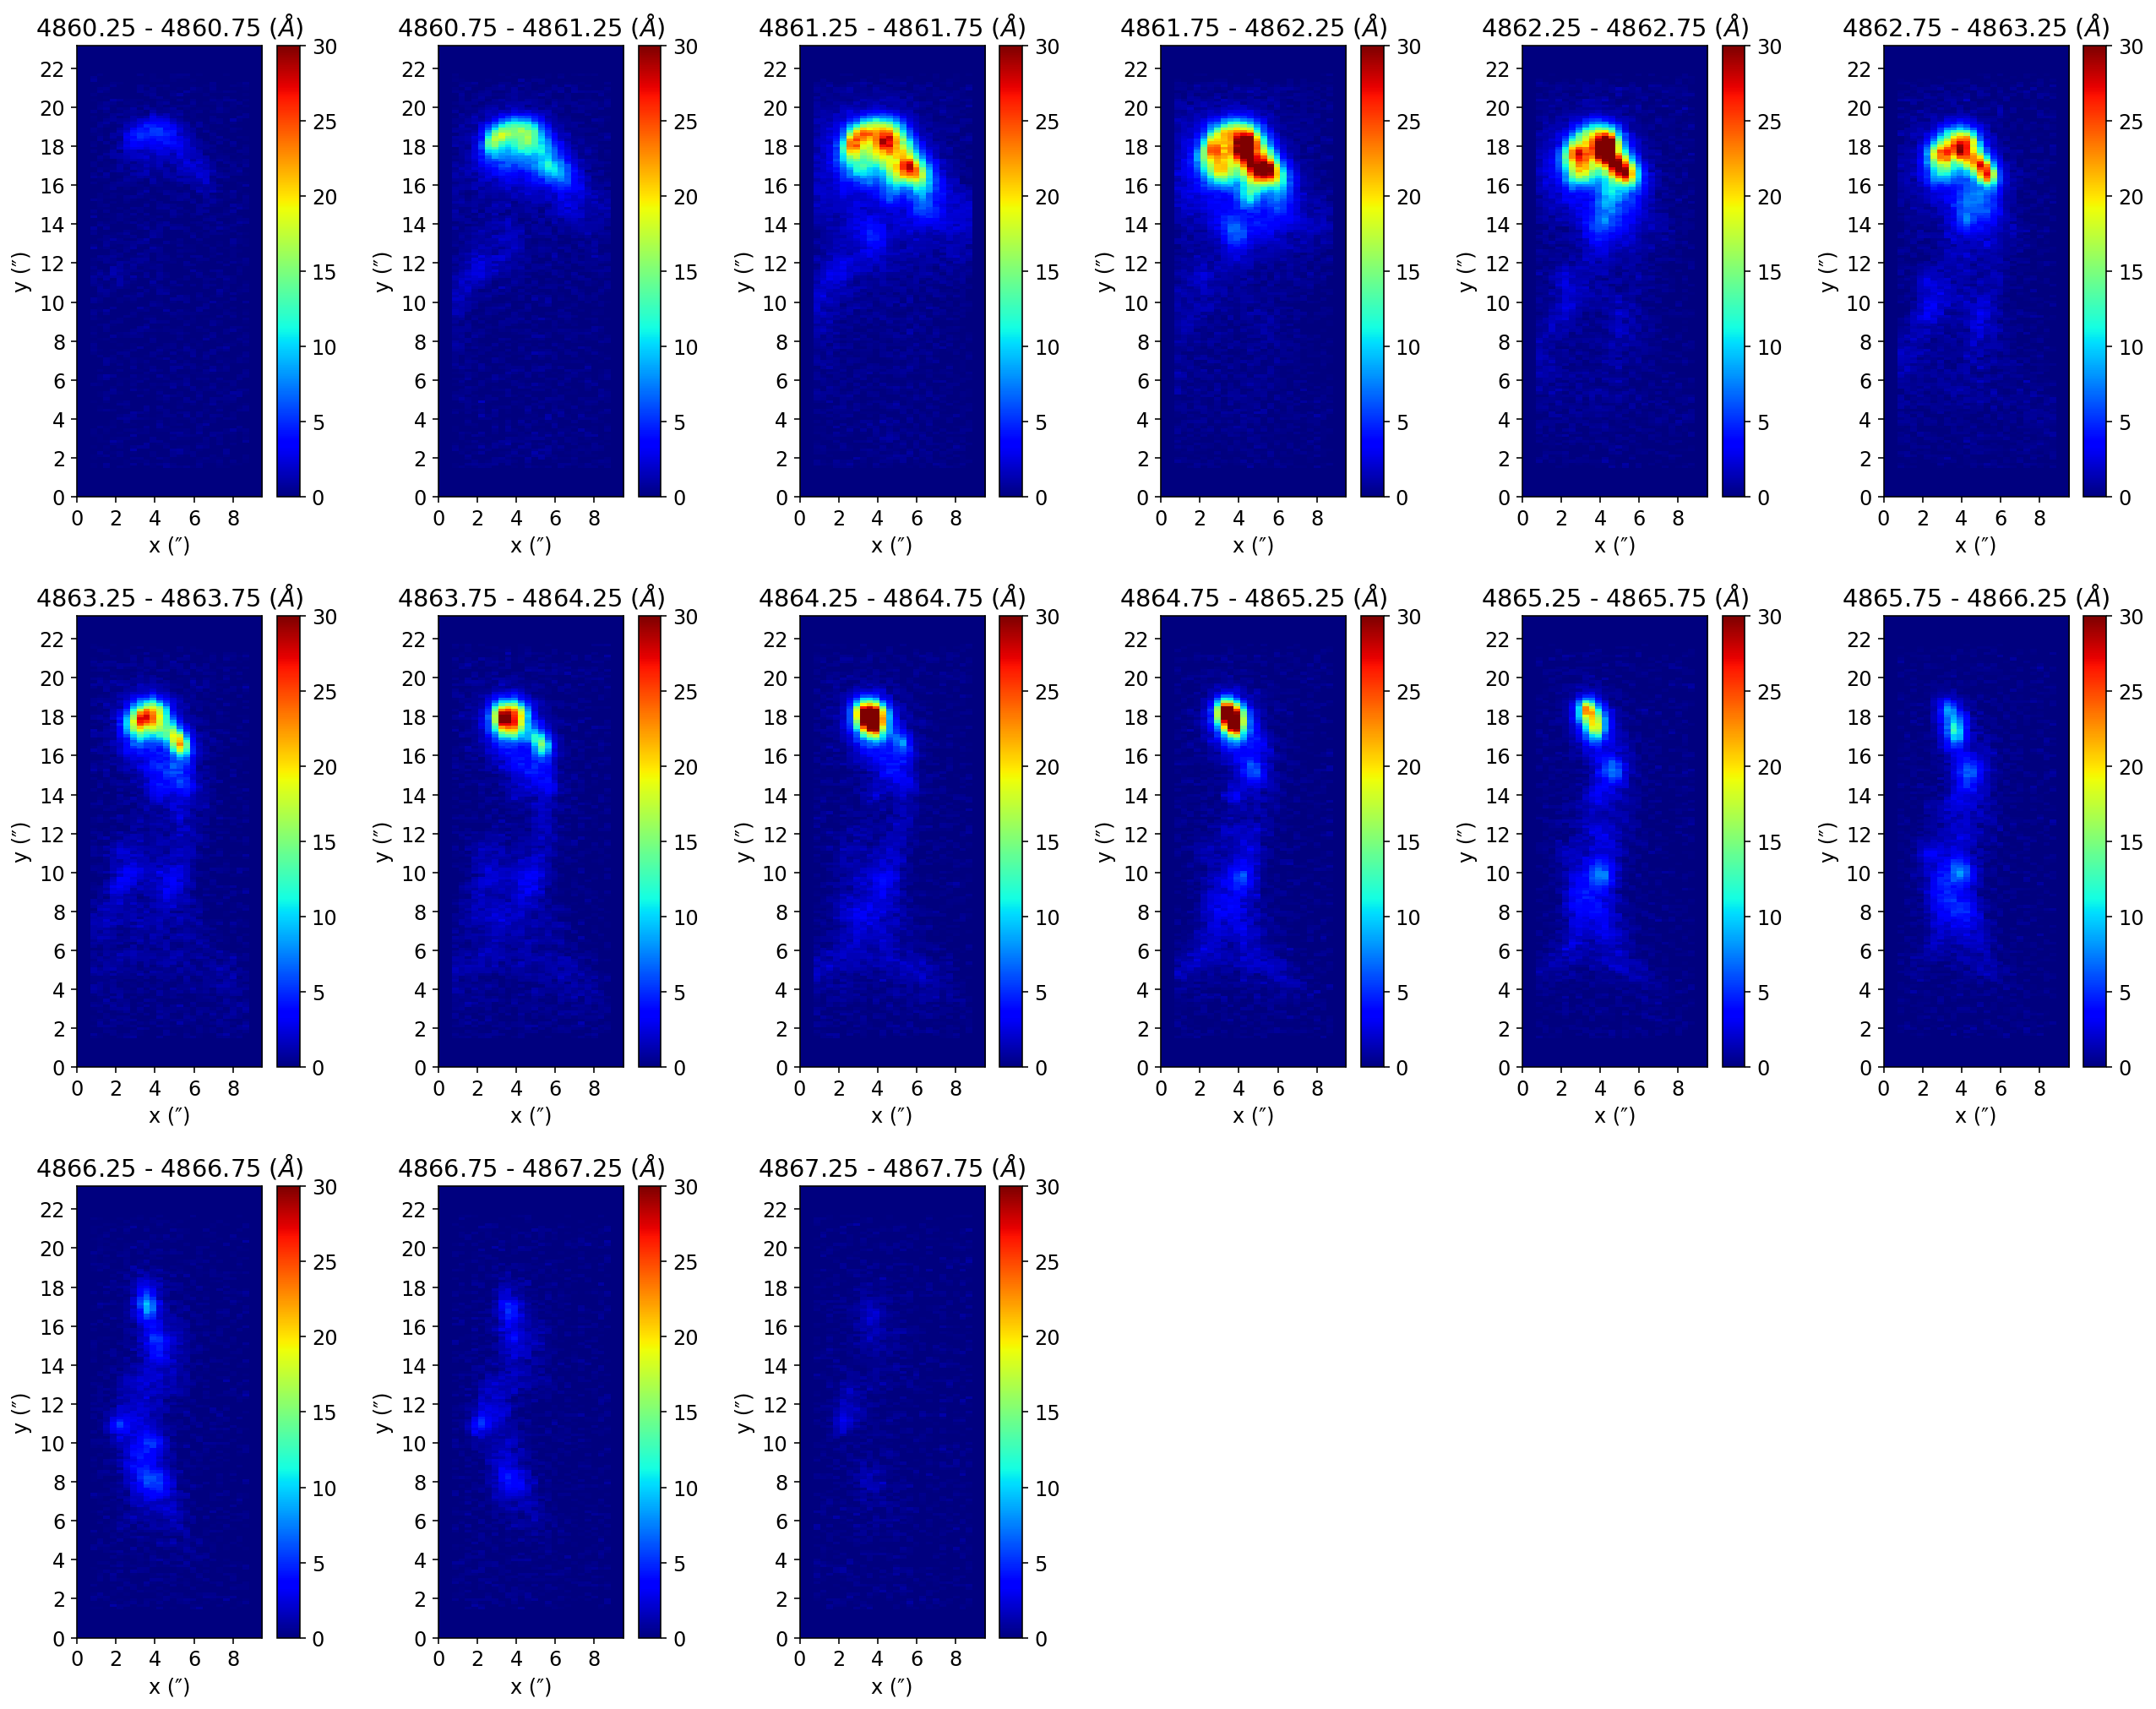

In [14]:
make_bin(4860.25, 4867.50, 0.5, "green", 0, 30, 6, (18, 70))

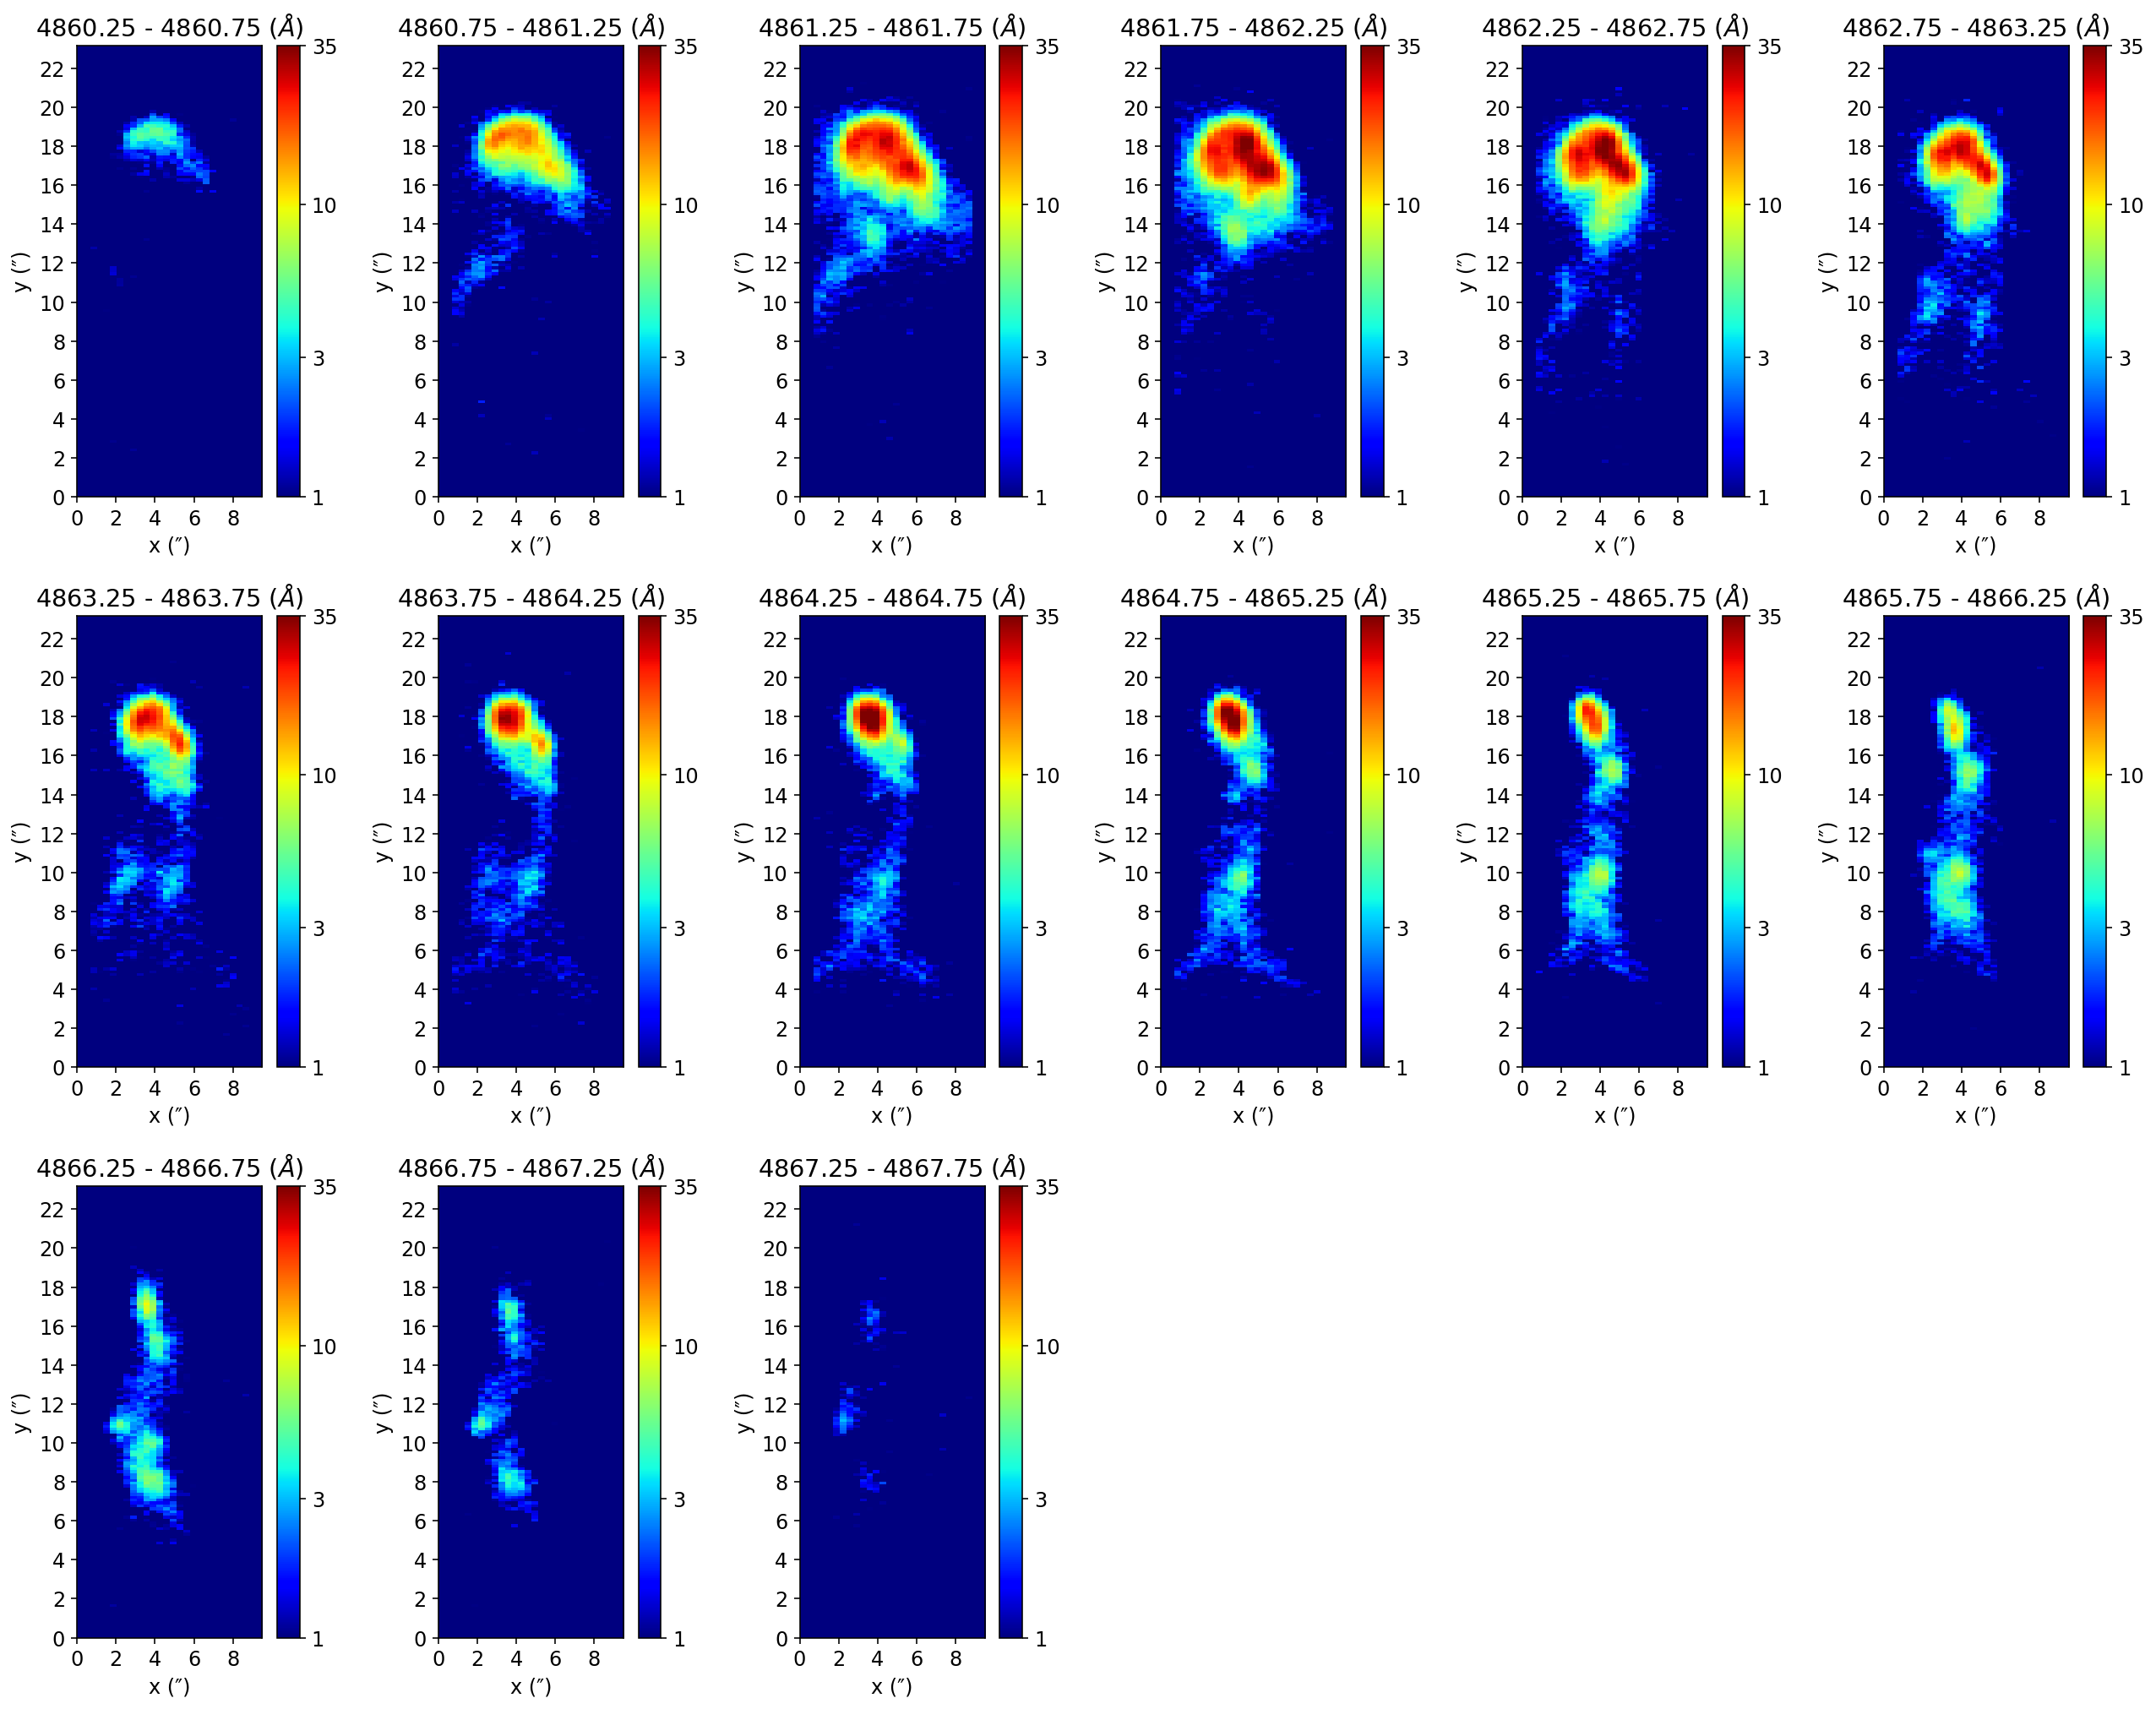

In [15]:
make_bin(4860.25, 4867.50, 0.5, "green", 1, 35, 6, (18, 70), [1, 3, 10, 35])

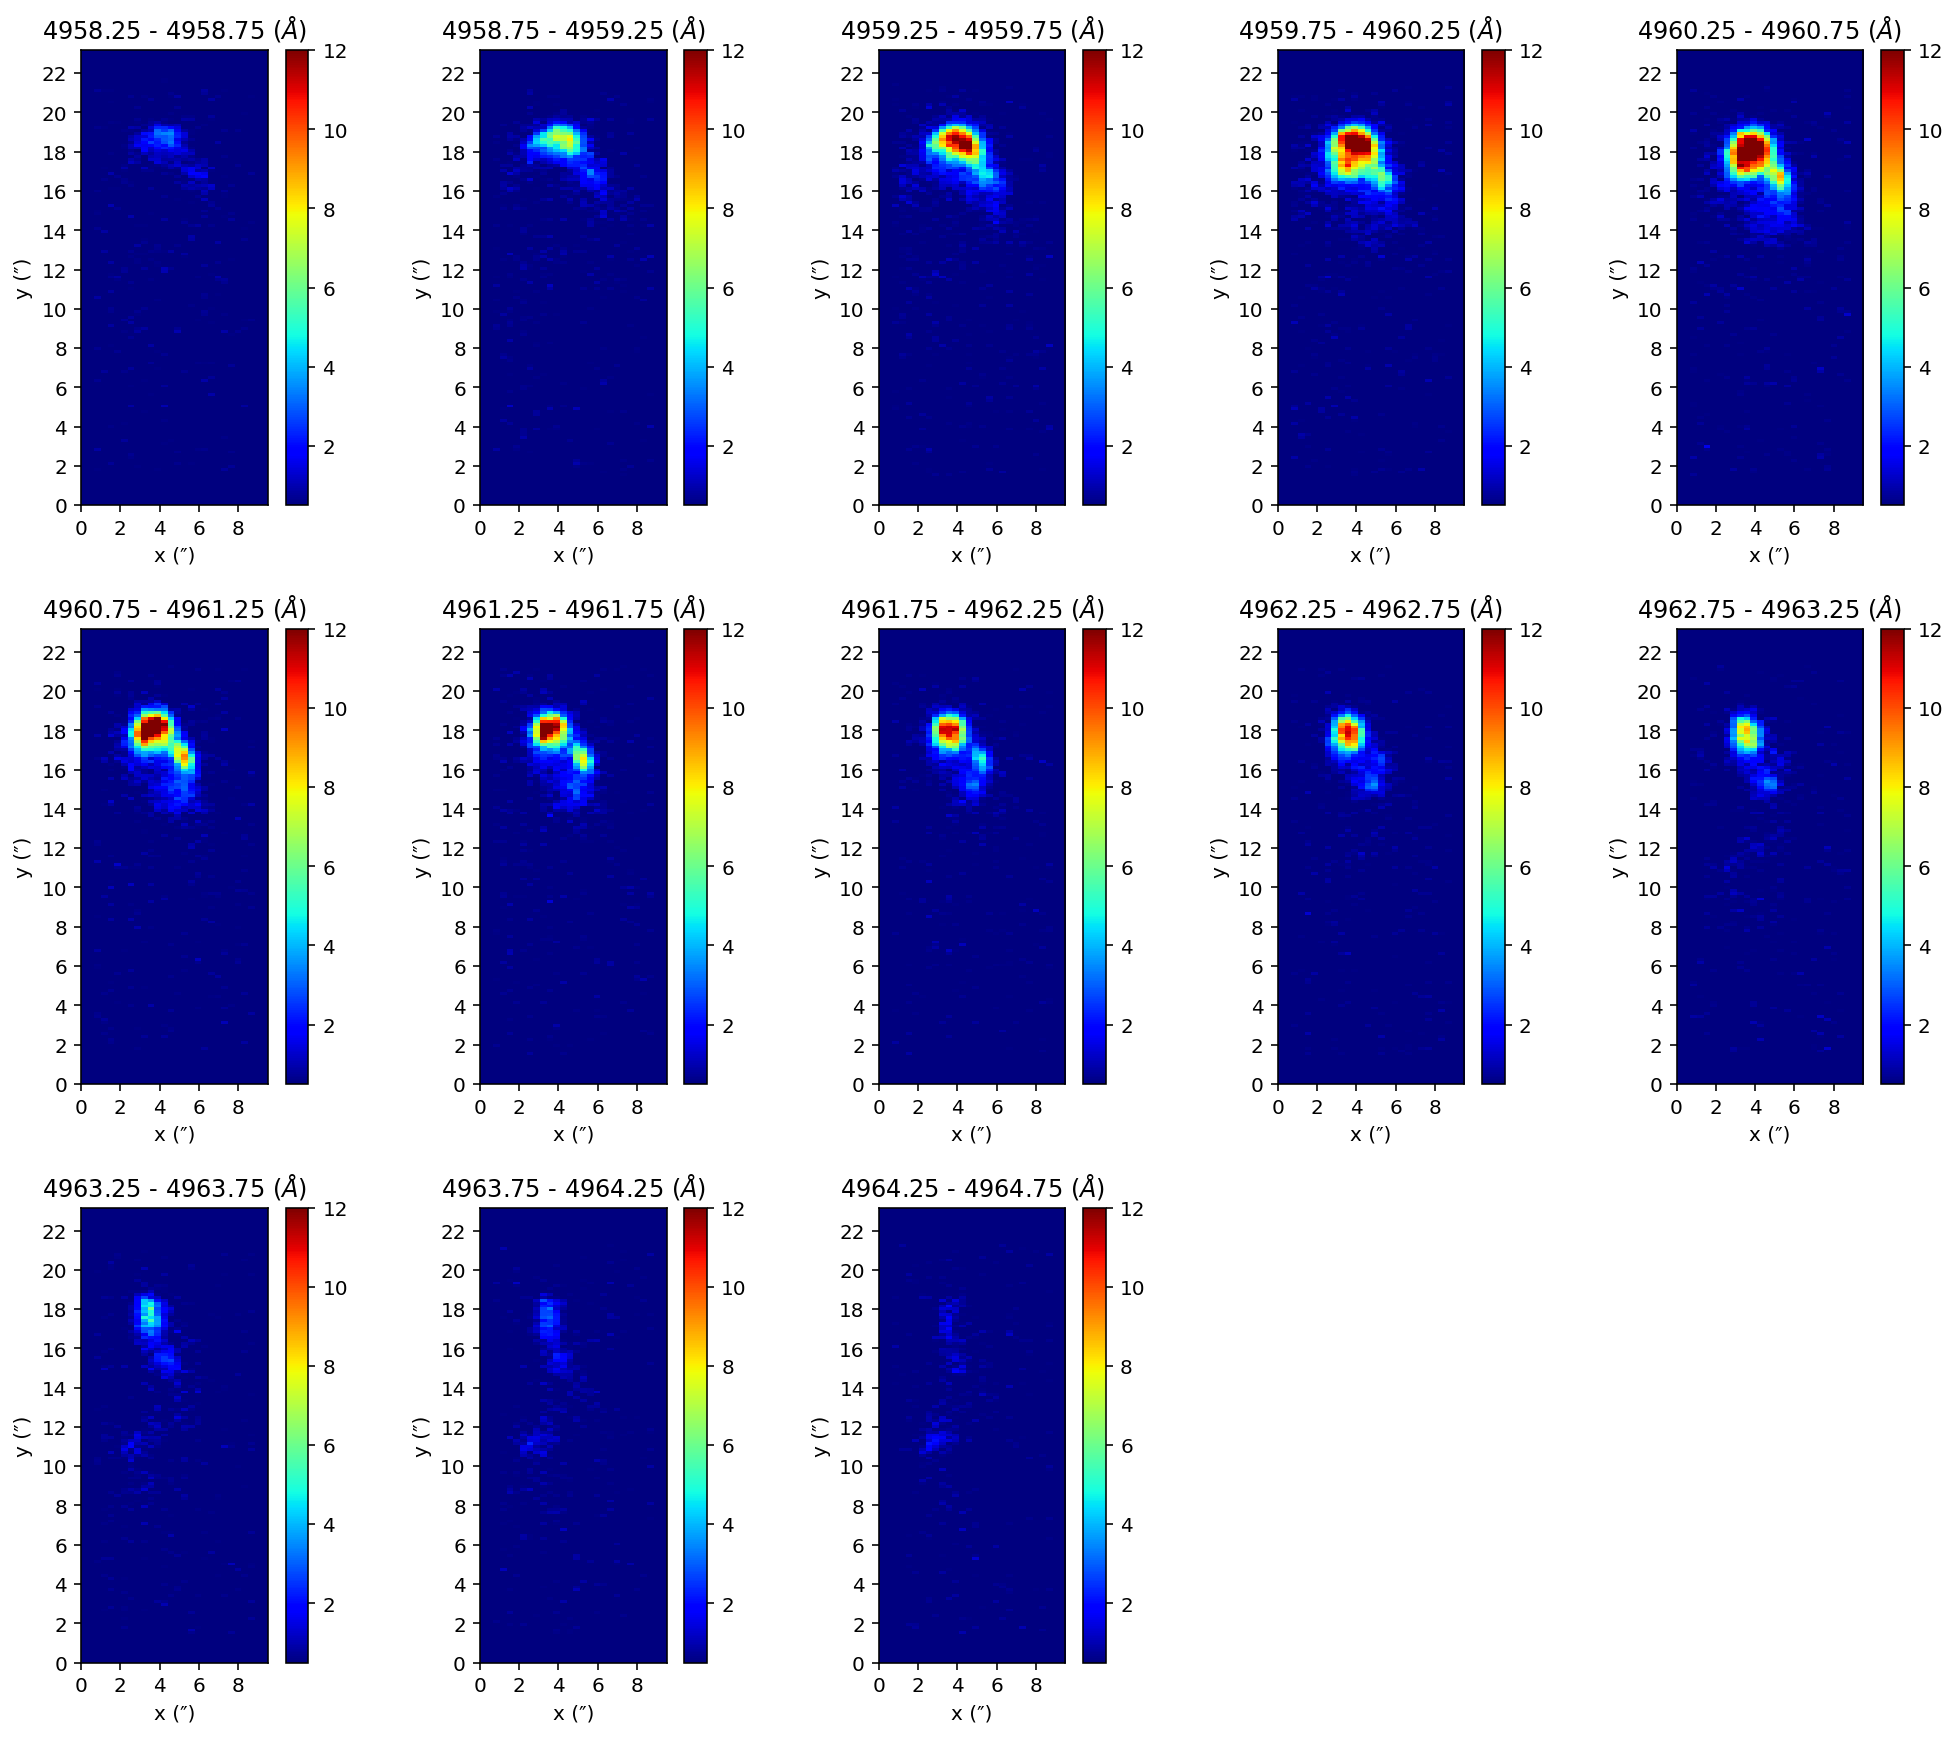

In [16]:
plt.rcParams.update({'font.size': 10})

make_bin(4958.25, 4964.75, 0.5, "green", 0.5, 12, 5, (14, 60))

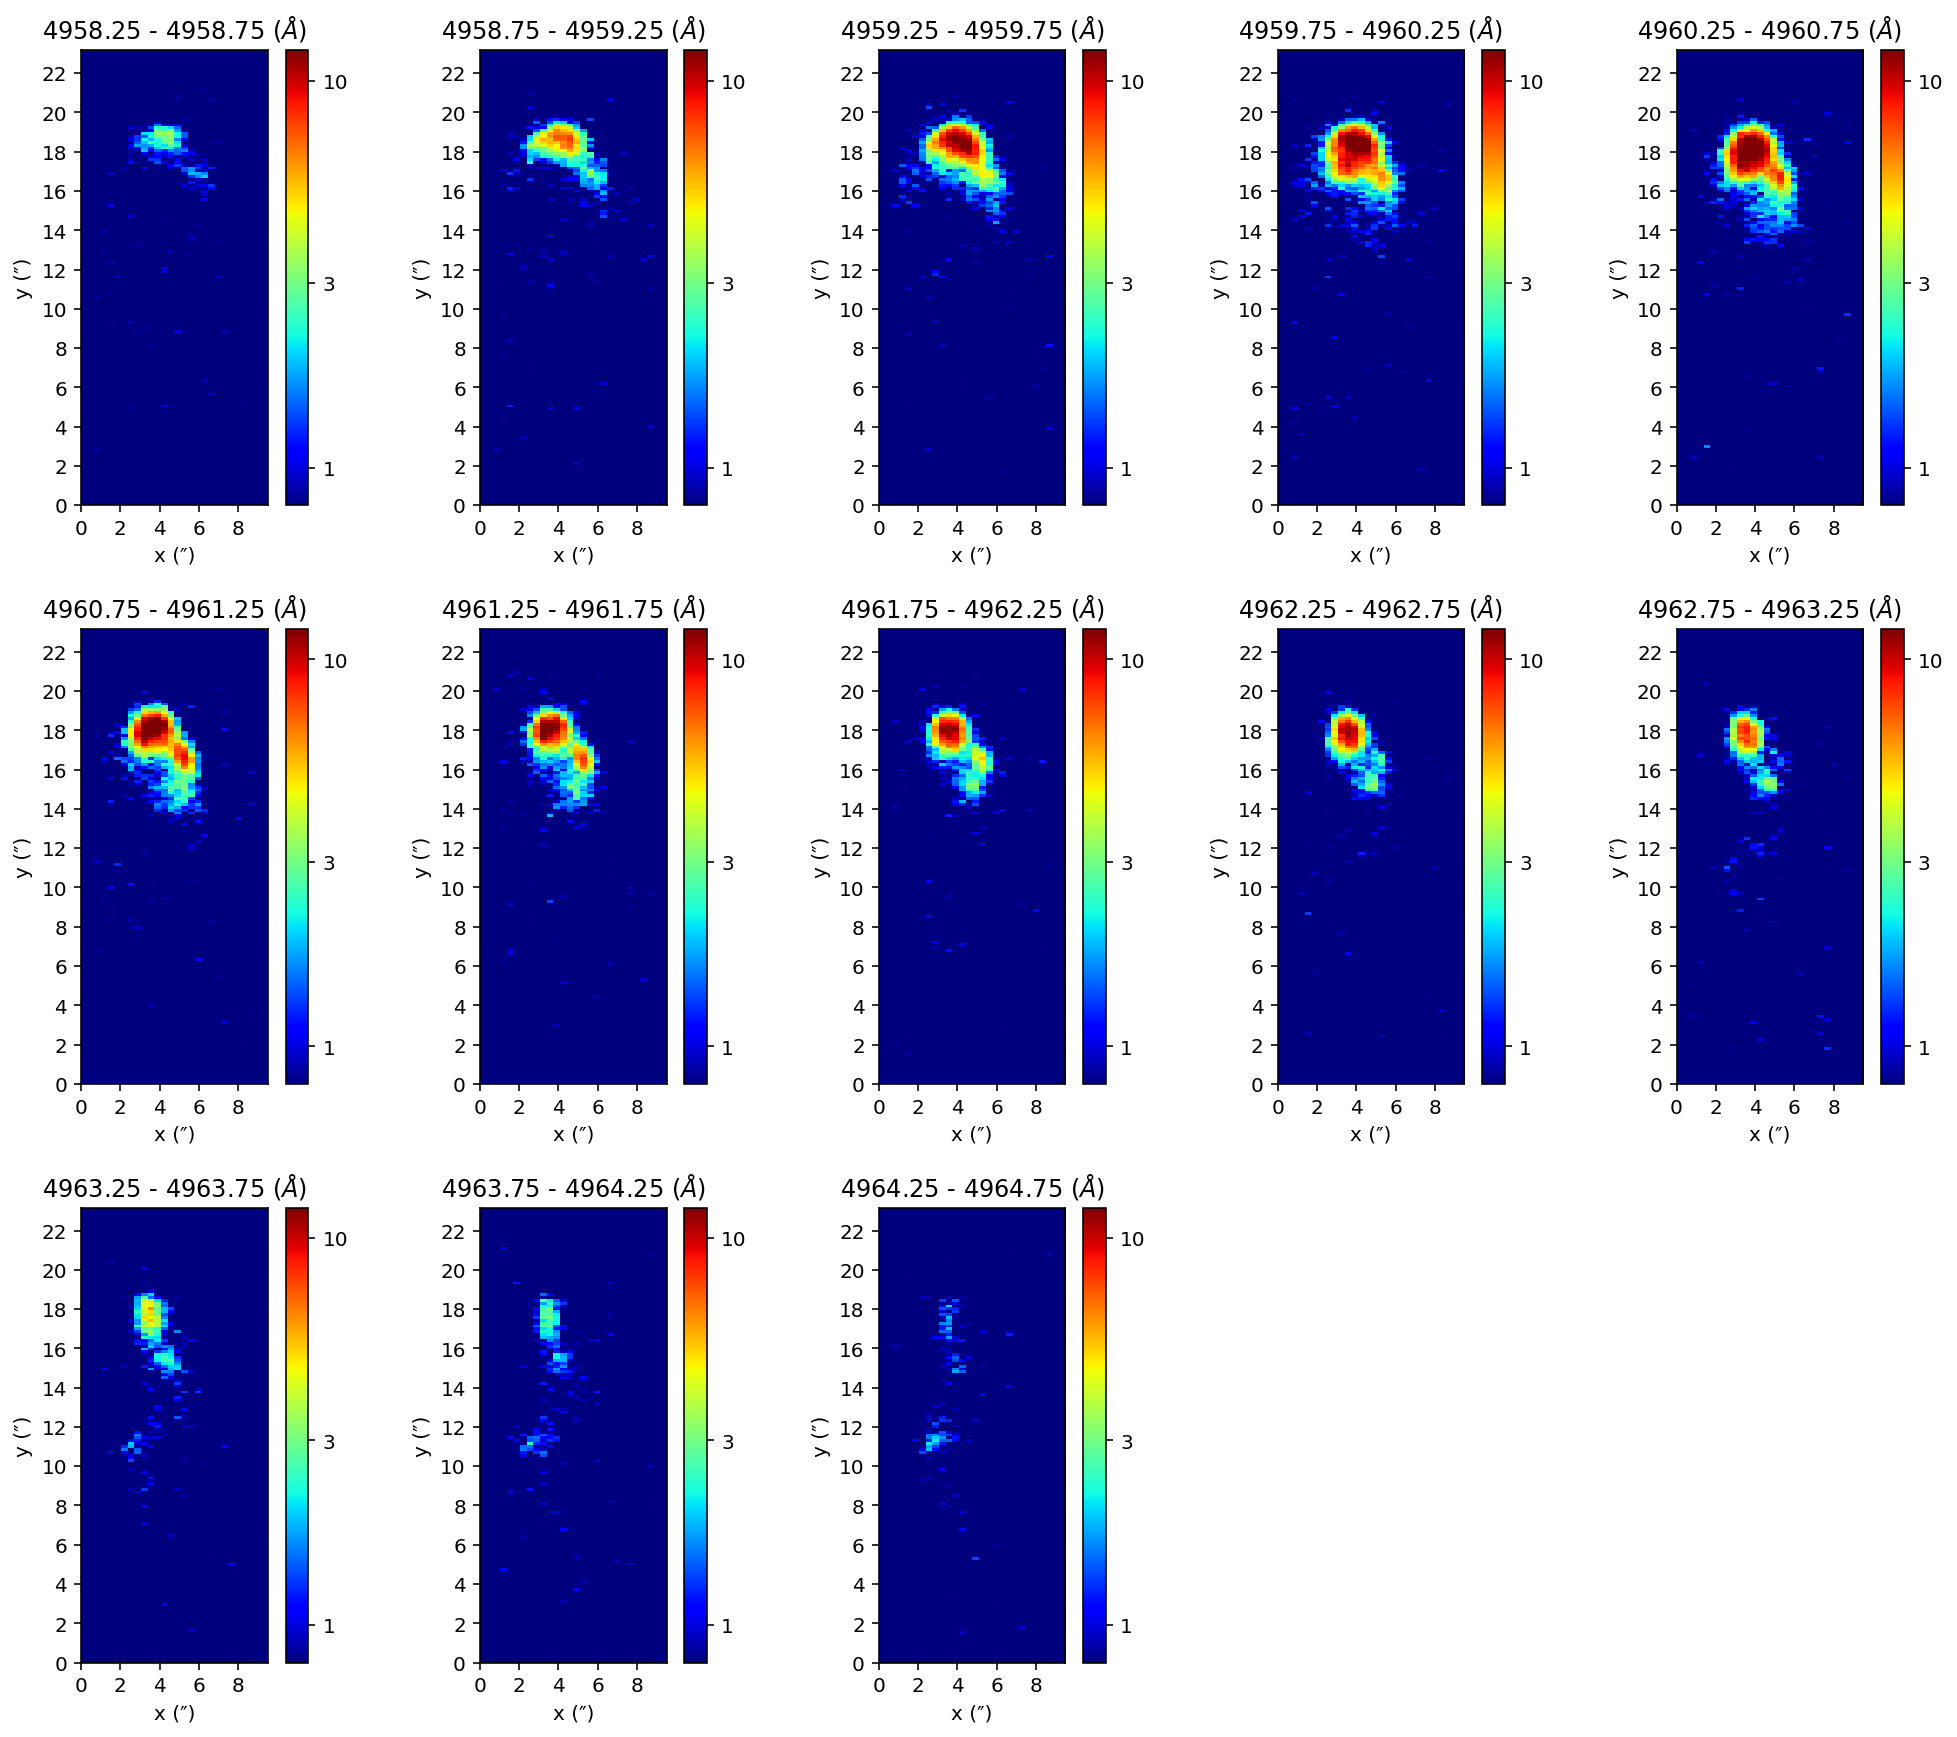

In [17]:
make_bin(4958.25, 4964.75, 0.5, "green", 0.8, 12, 5, (14, 60), [1, 3, 10, 35])

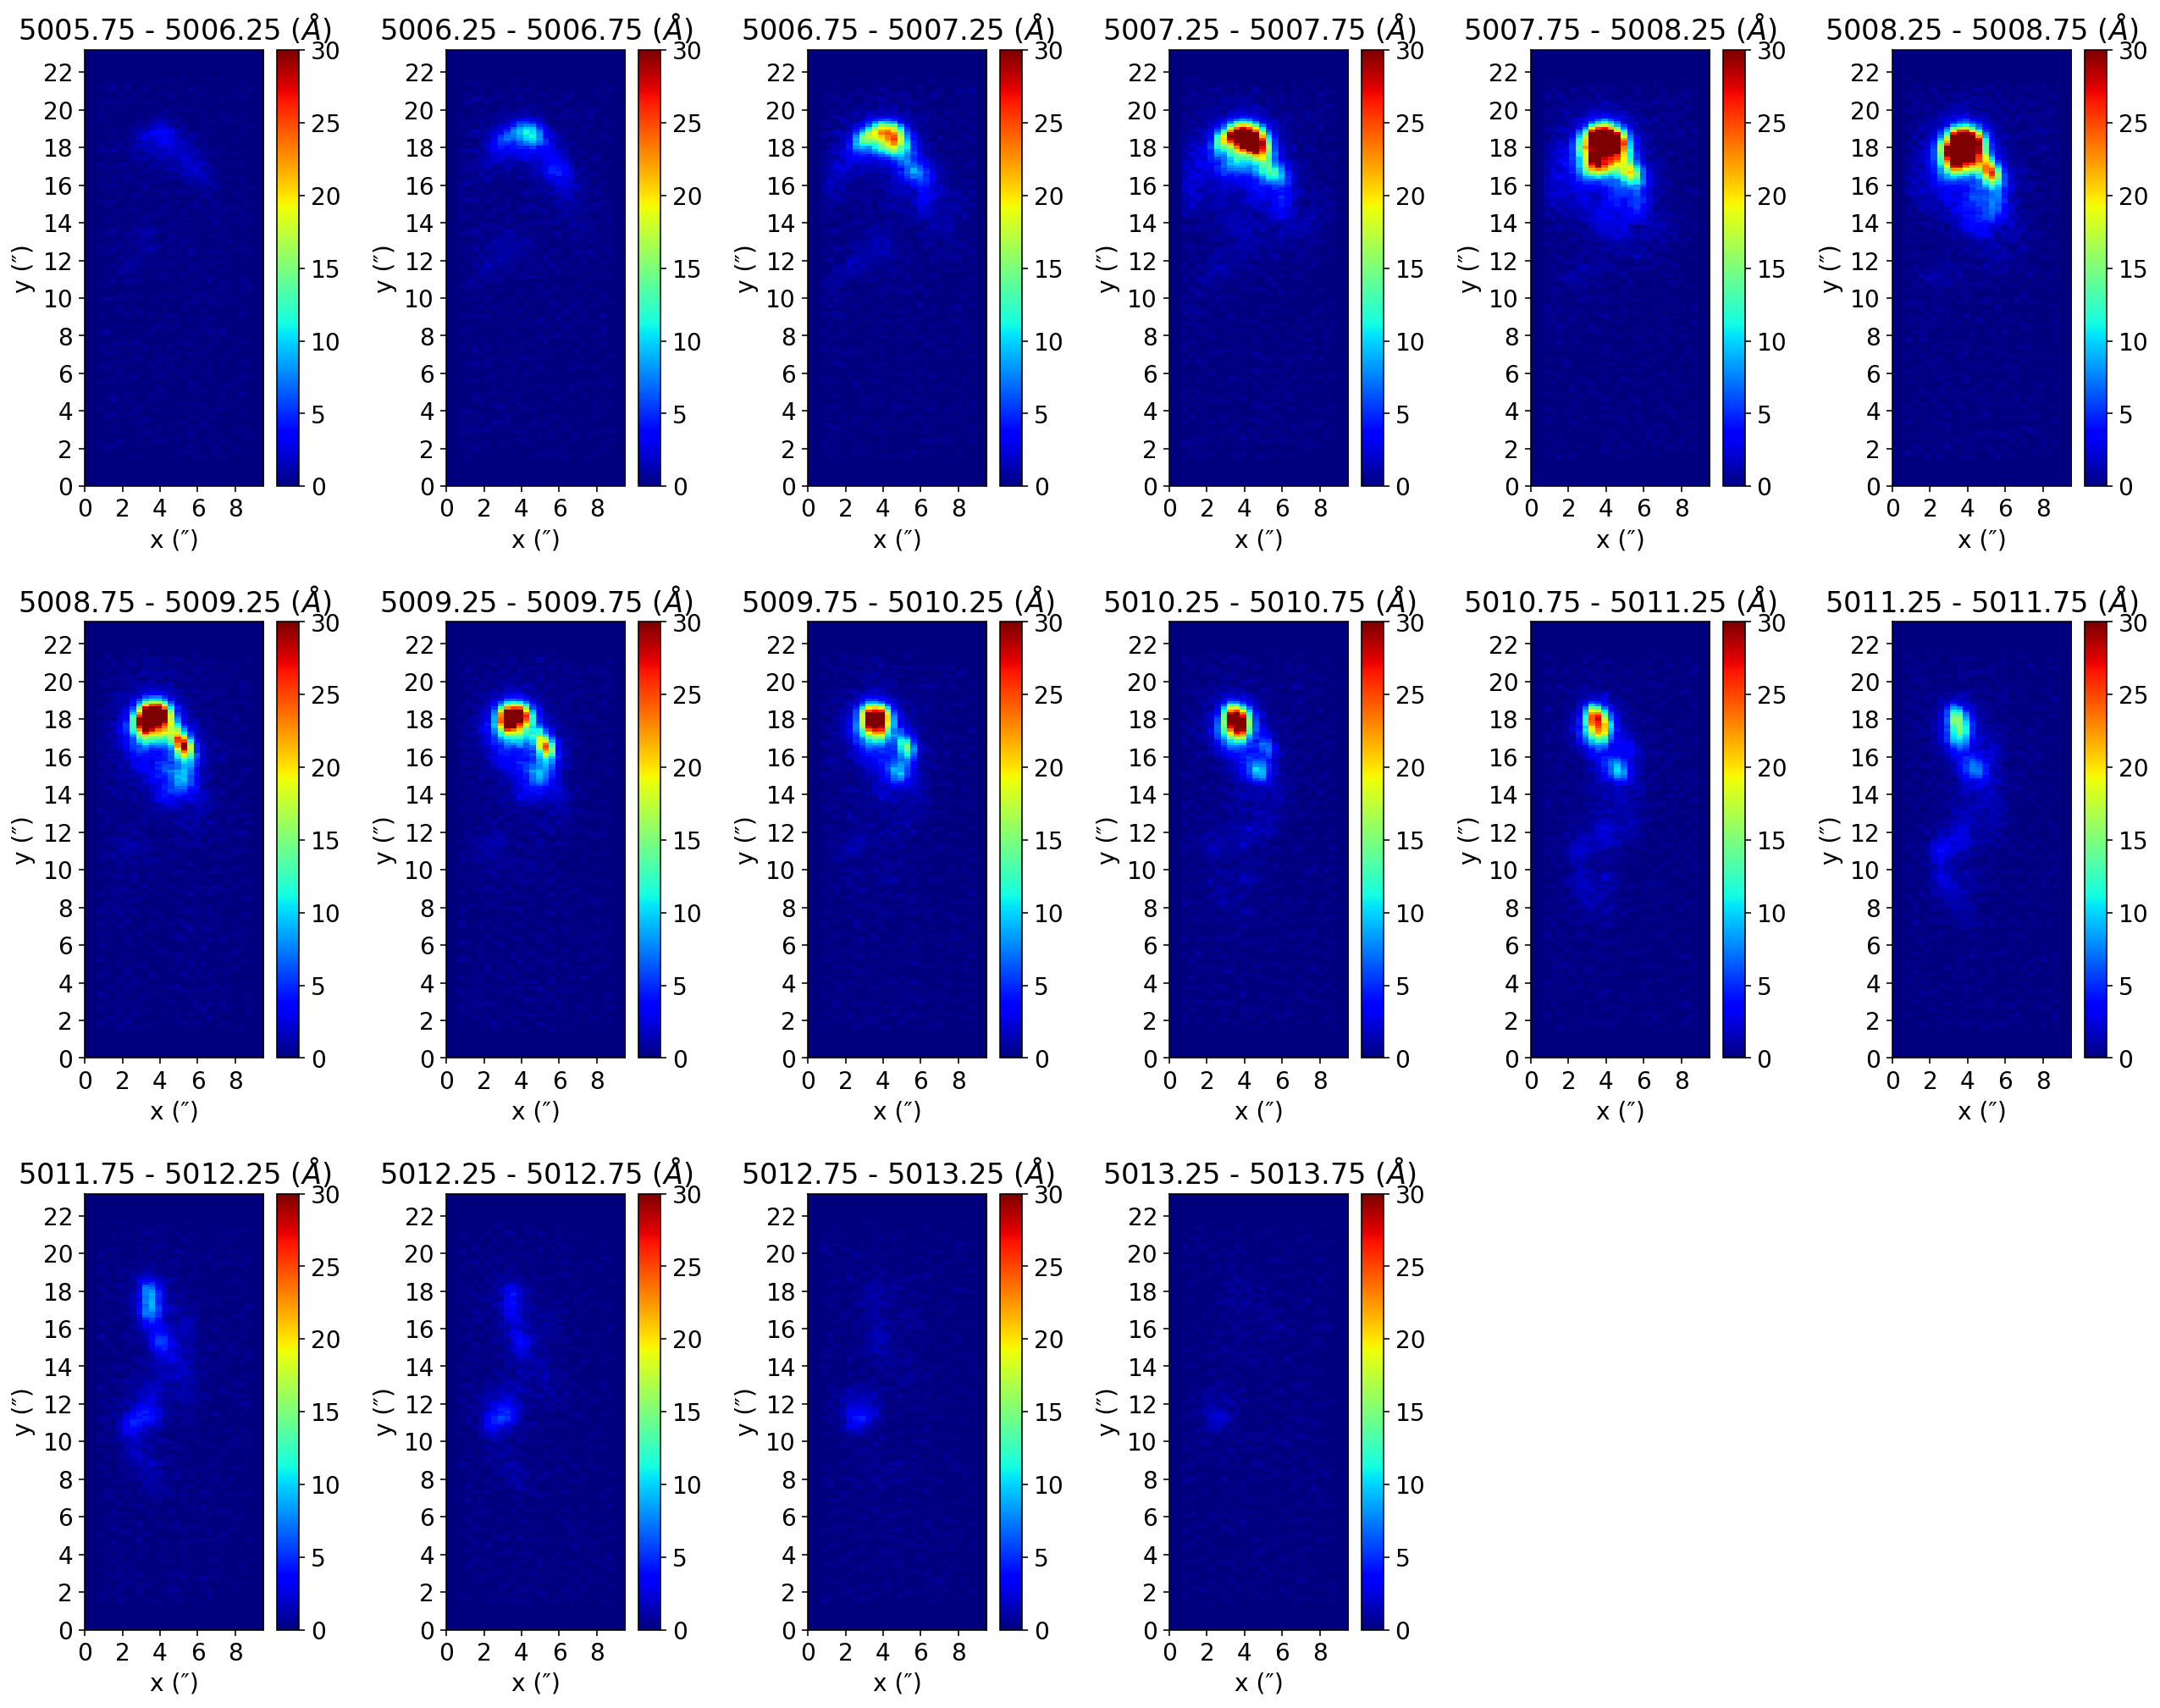

In [36]:
plt.rcParams.update({'font.size': 12})

make_bin(5005.75, 5013.50, 0.5, "green", 0, 30, 6, (18, 70))

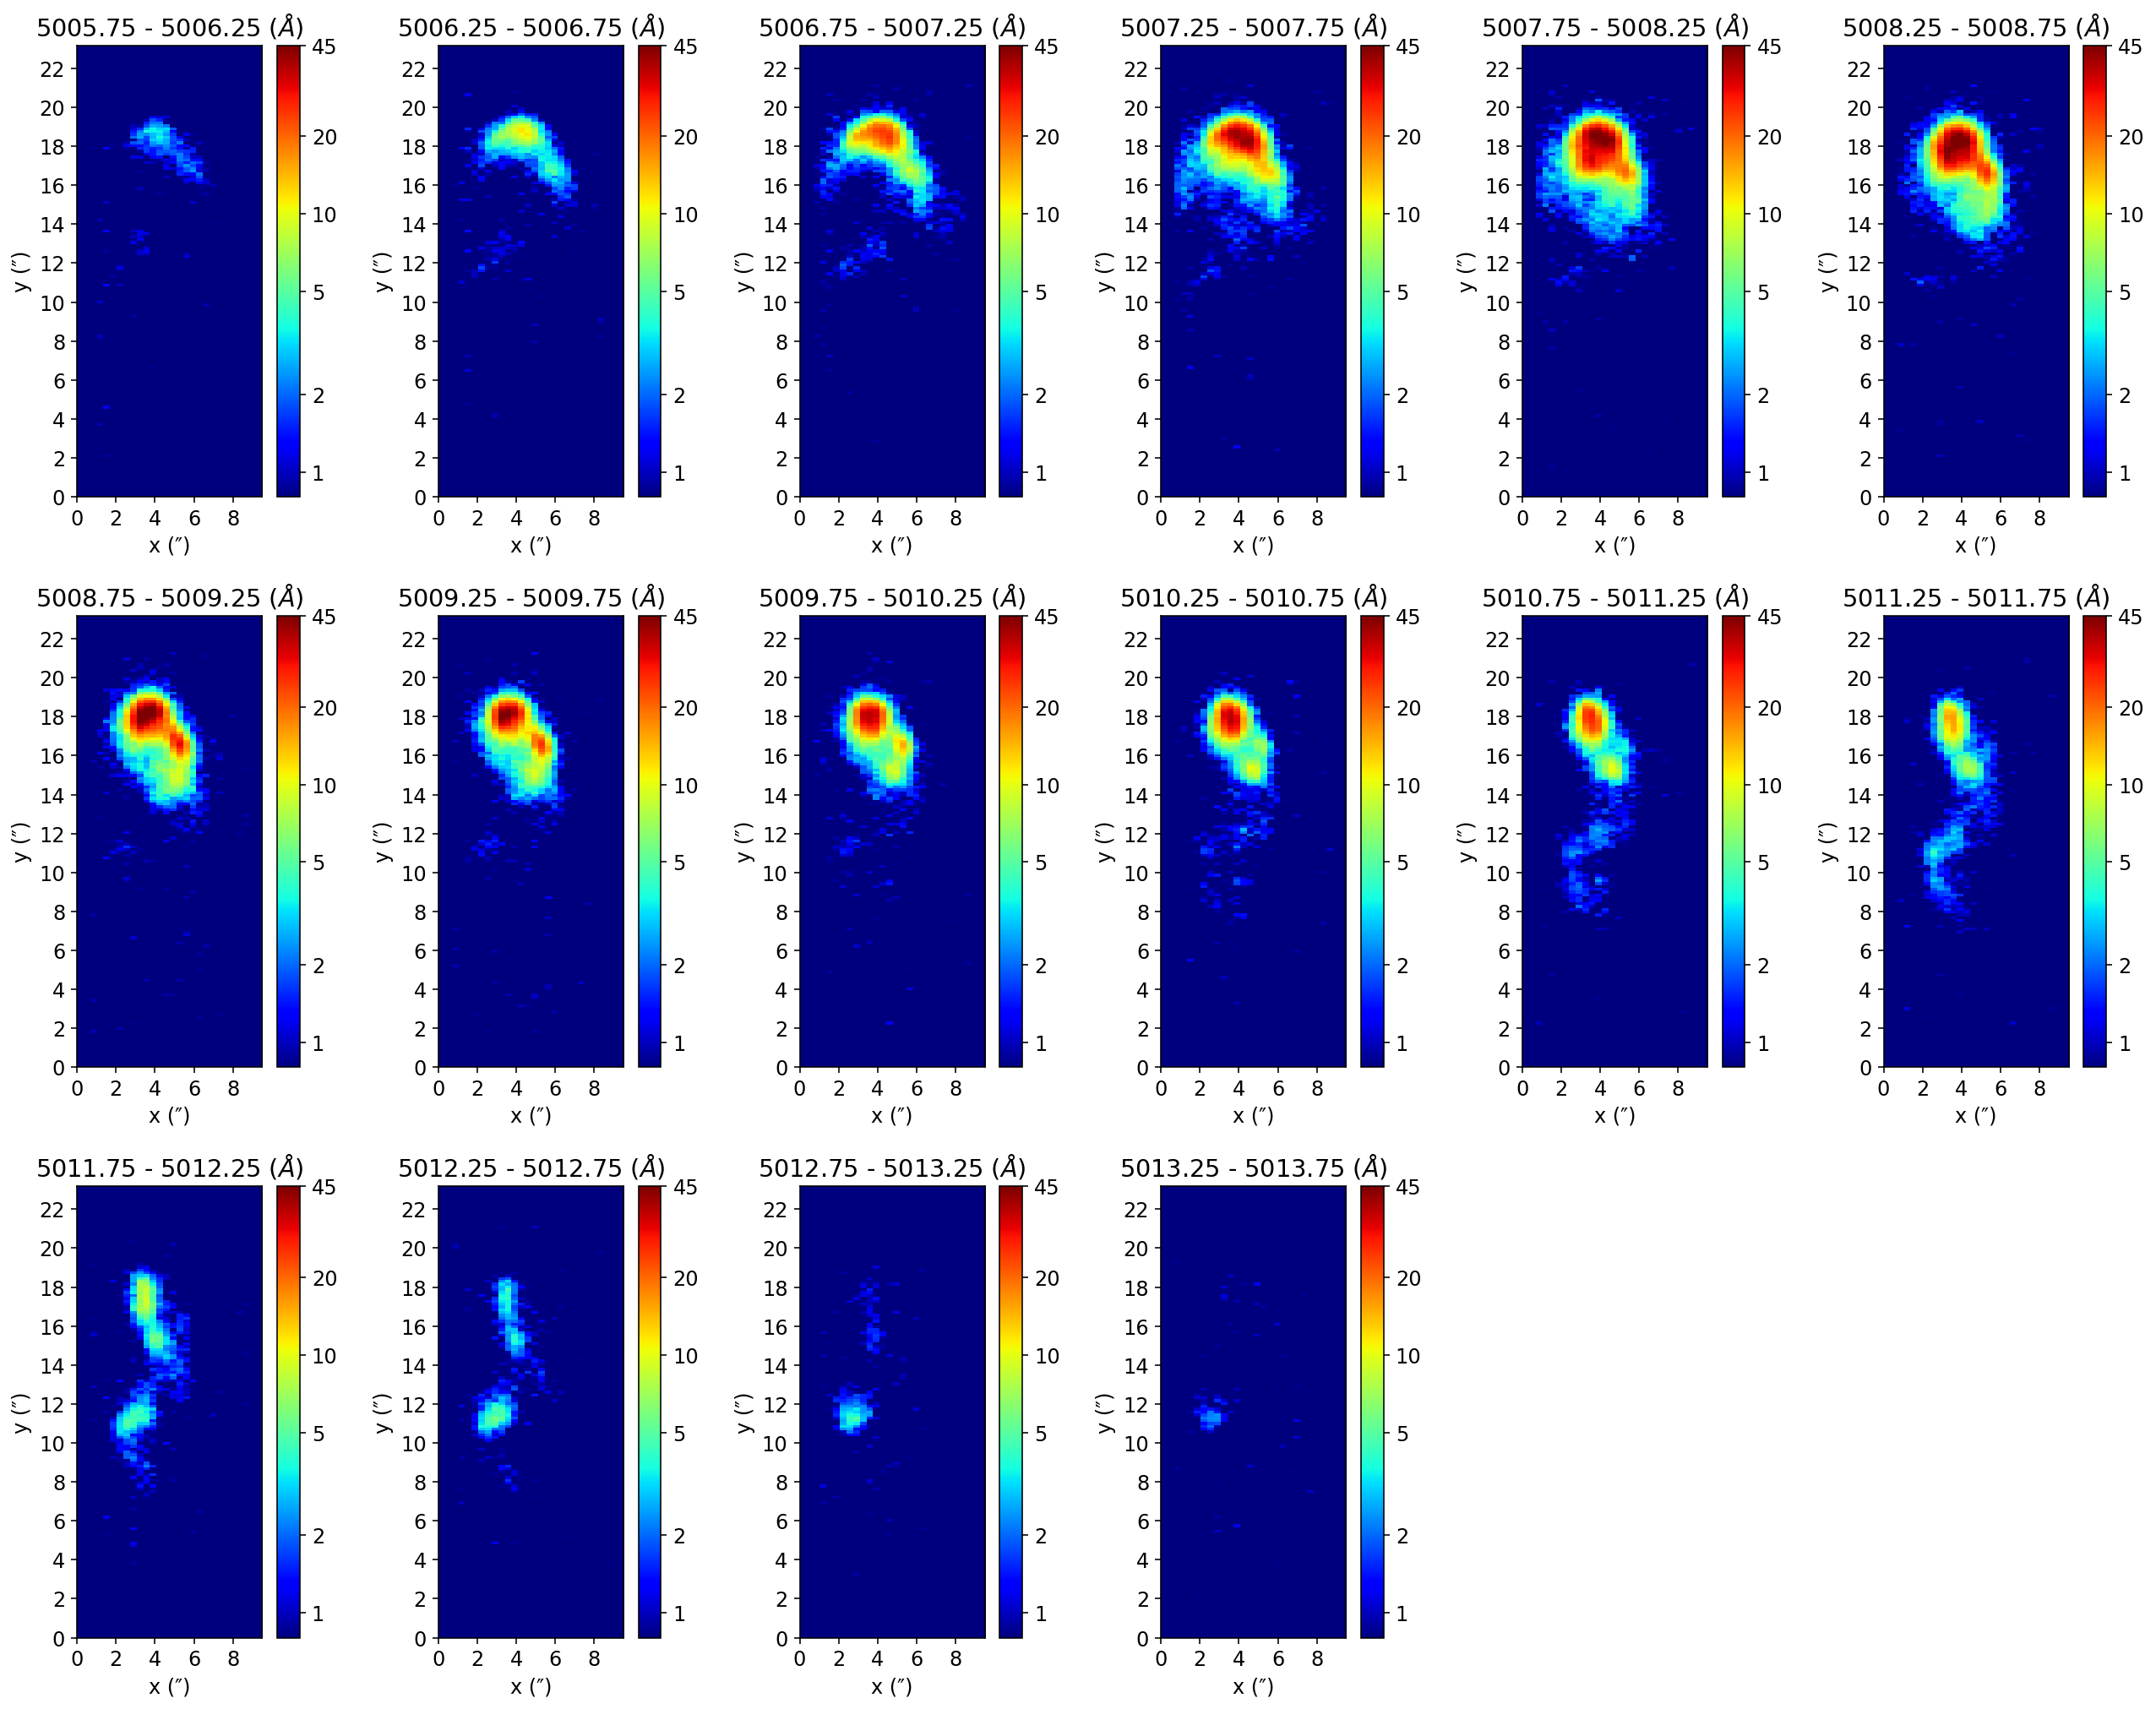

In [19]:
make_bin(5005.75, 5013.50, 0.5, "green", 0.8, 45, 6, (18, 70), [1, 2, 5, 10, 20, 45])

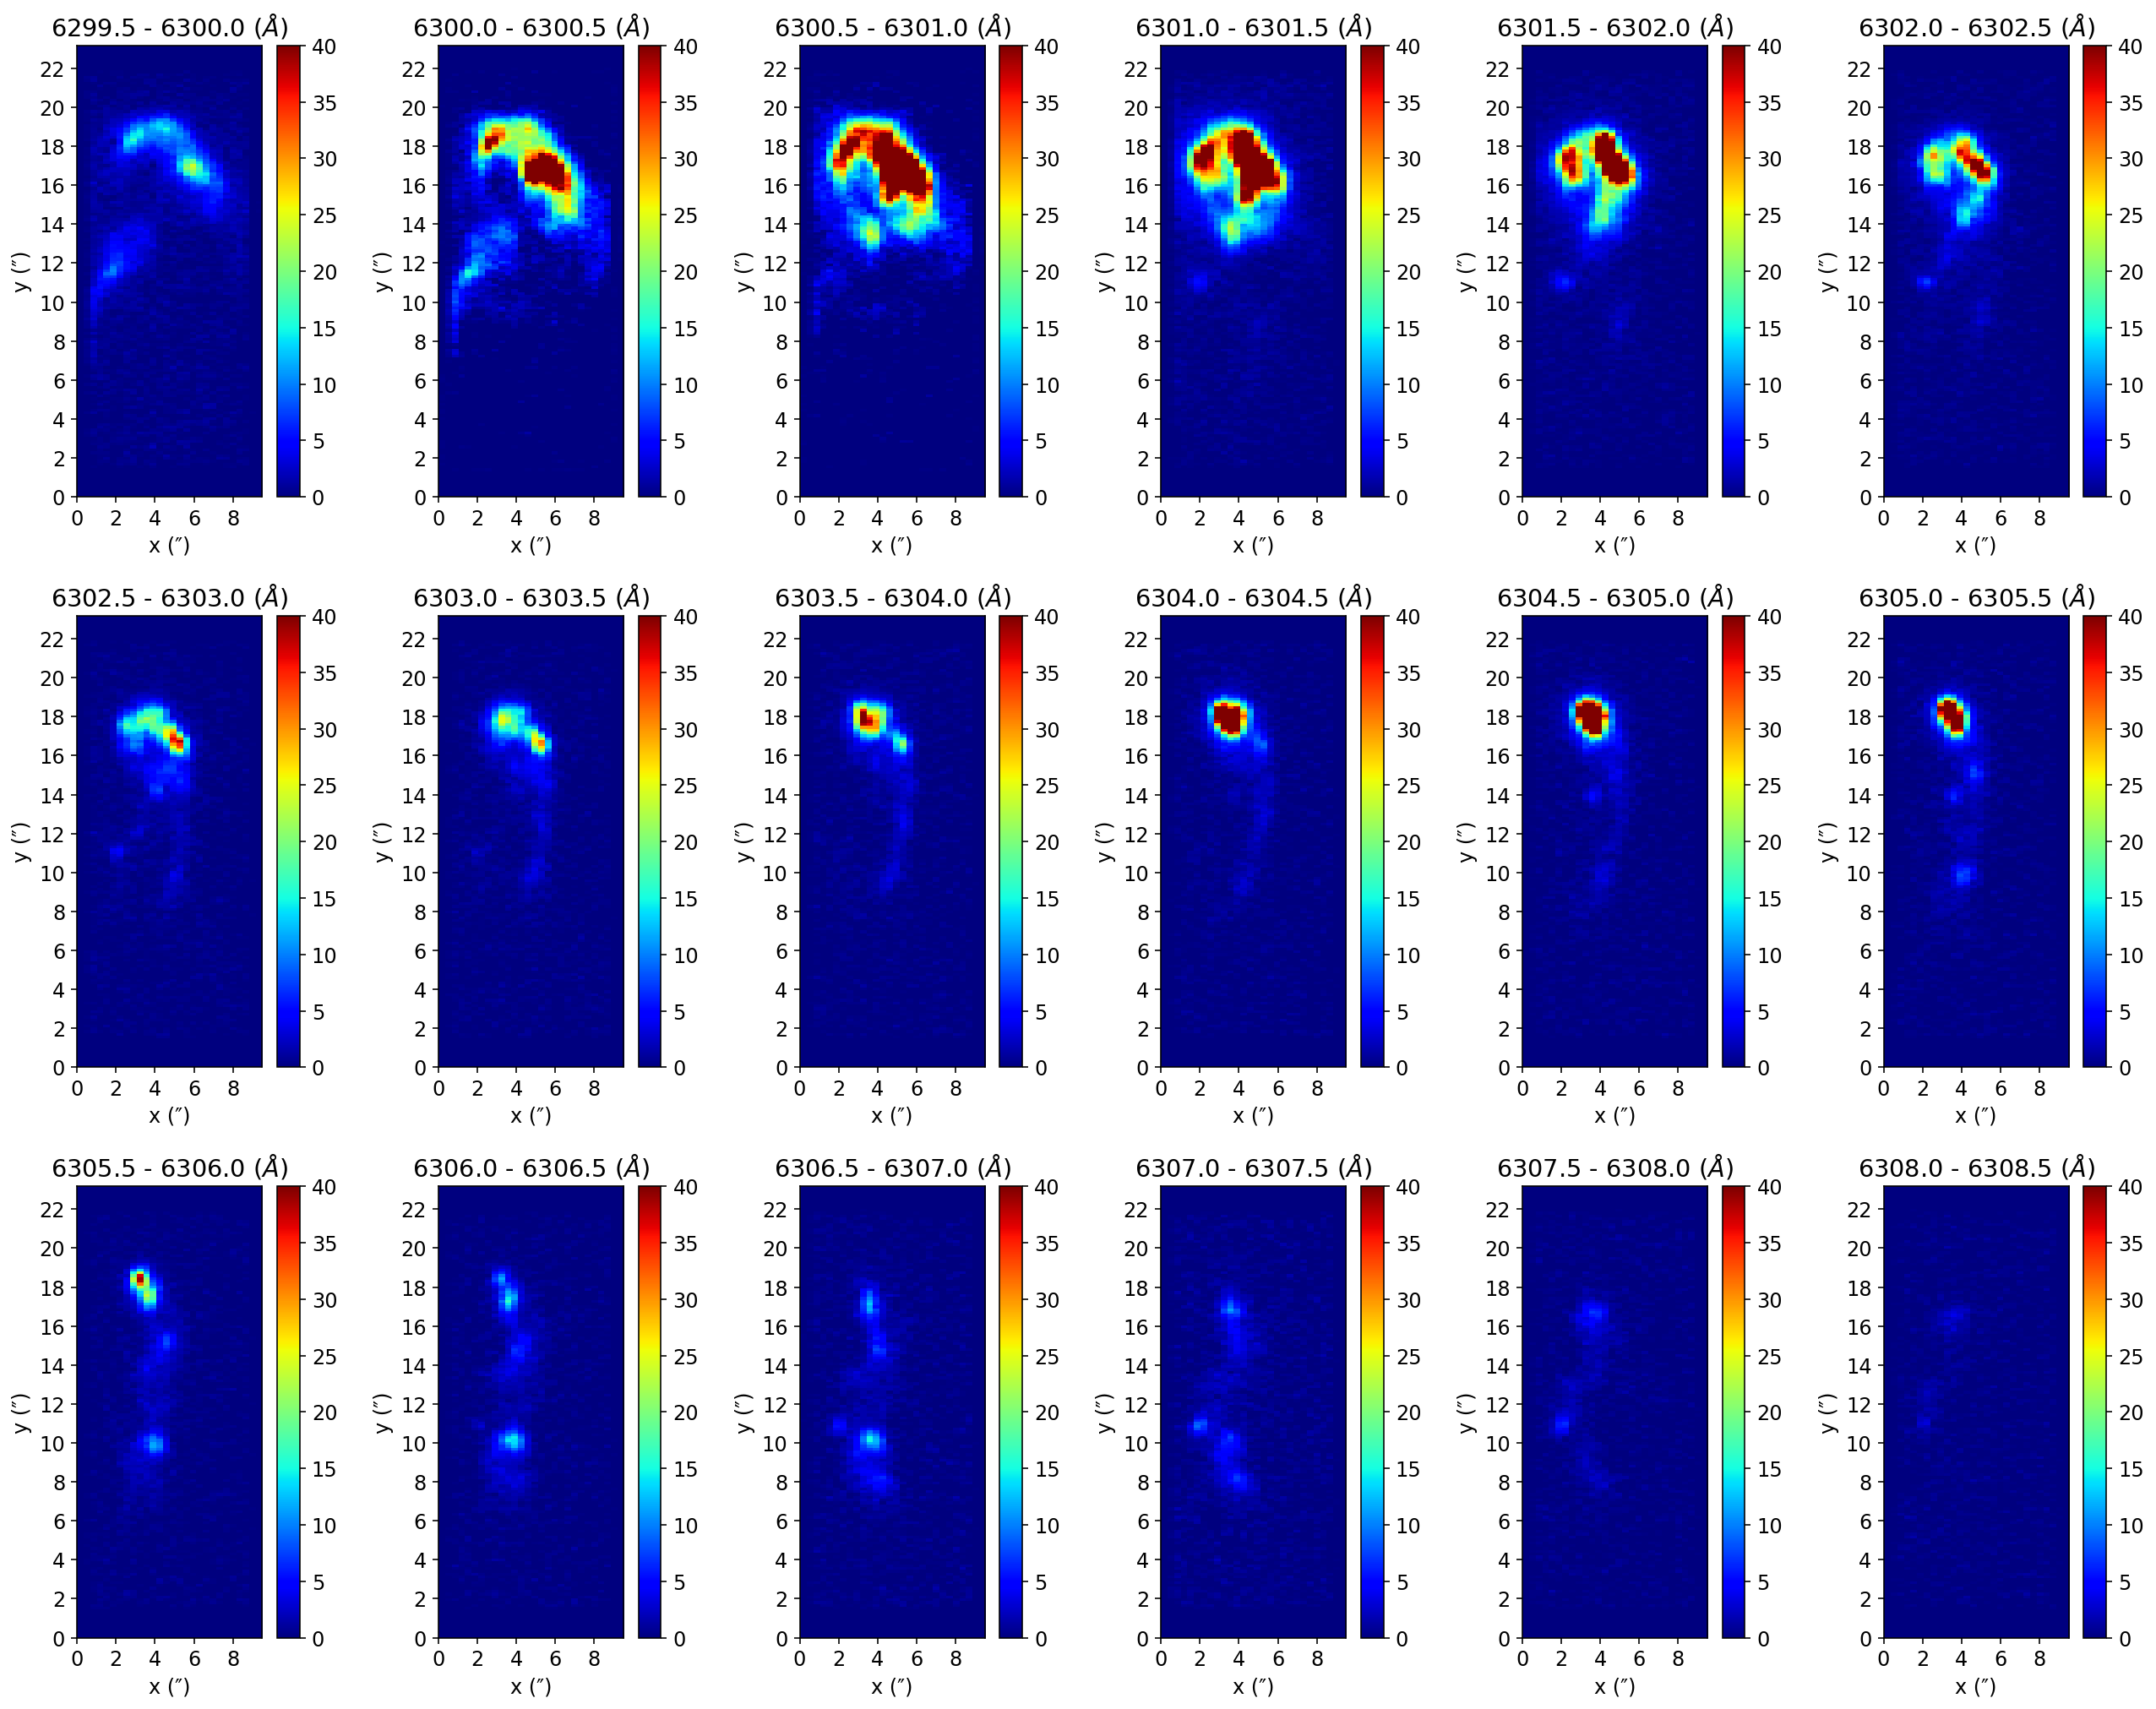

In [20]:
make_bin(6299.50, 6308.25, 0.5, "red", 0, 40, 6, (18, 70))

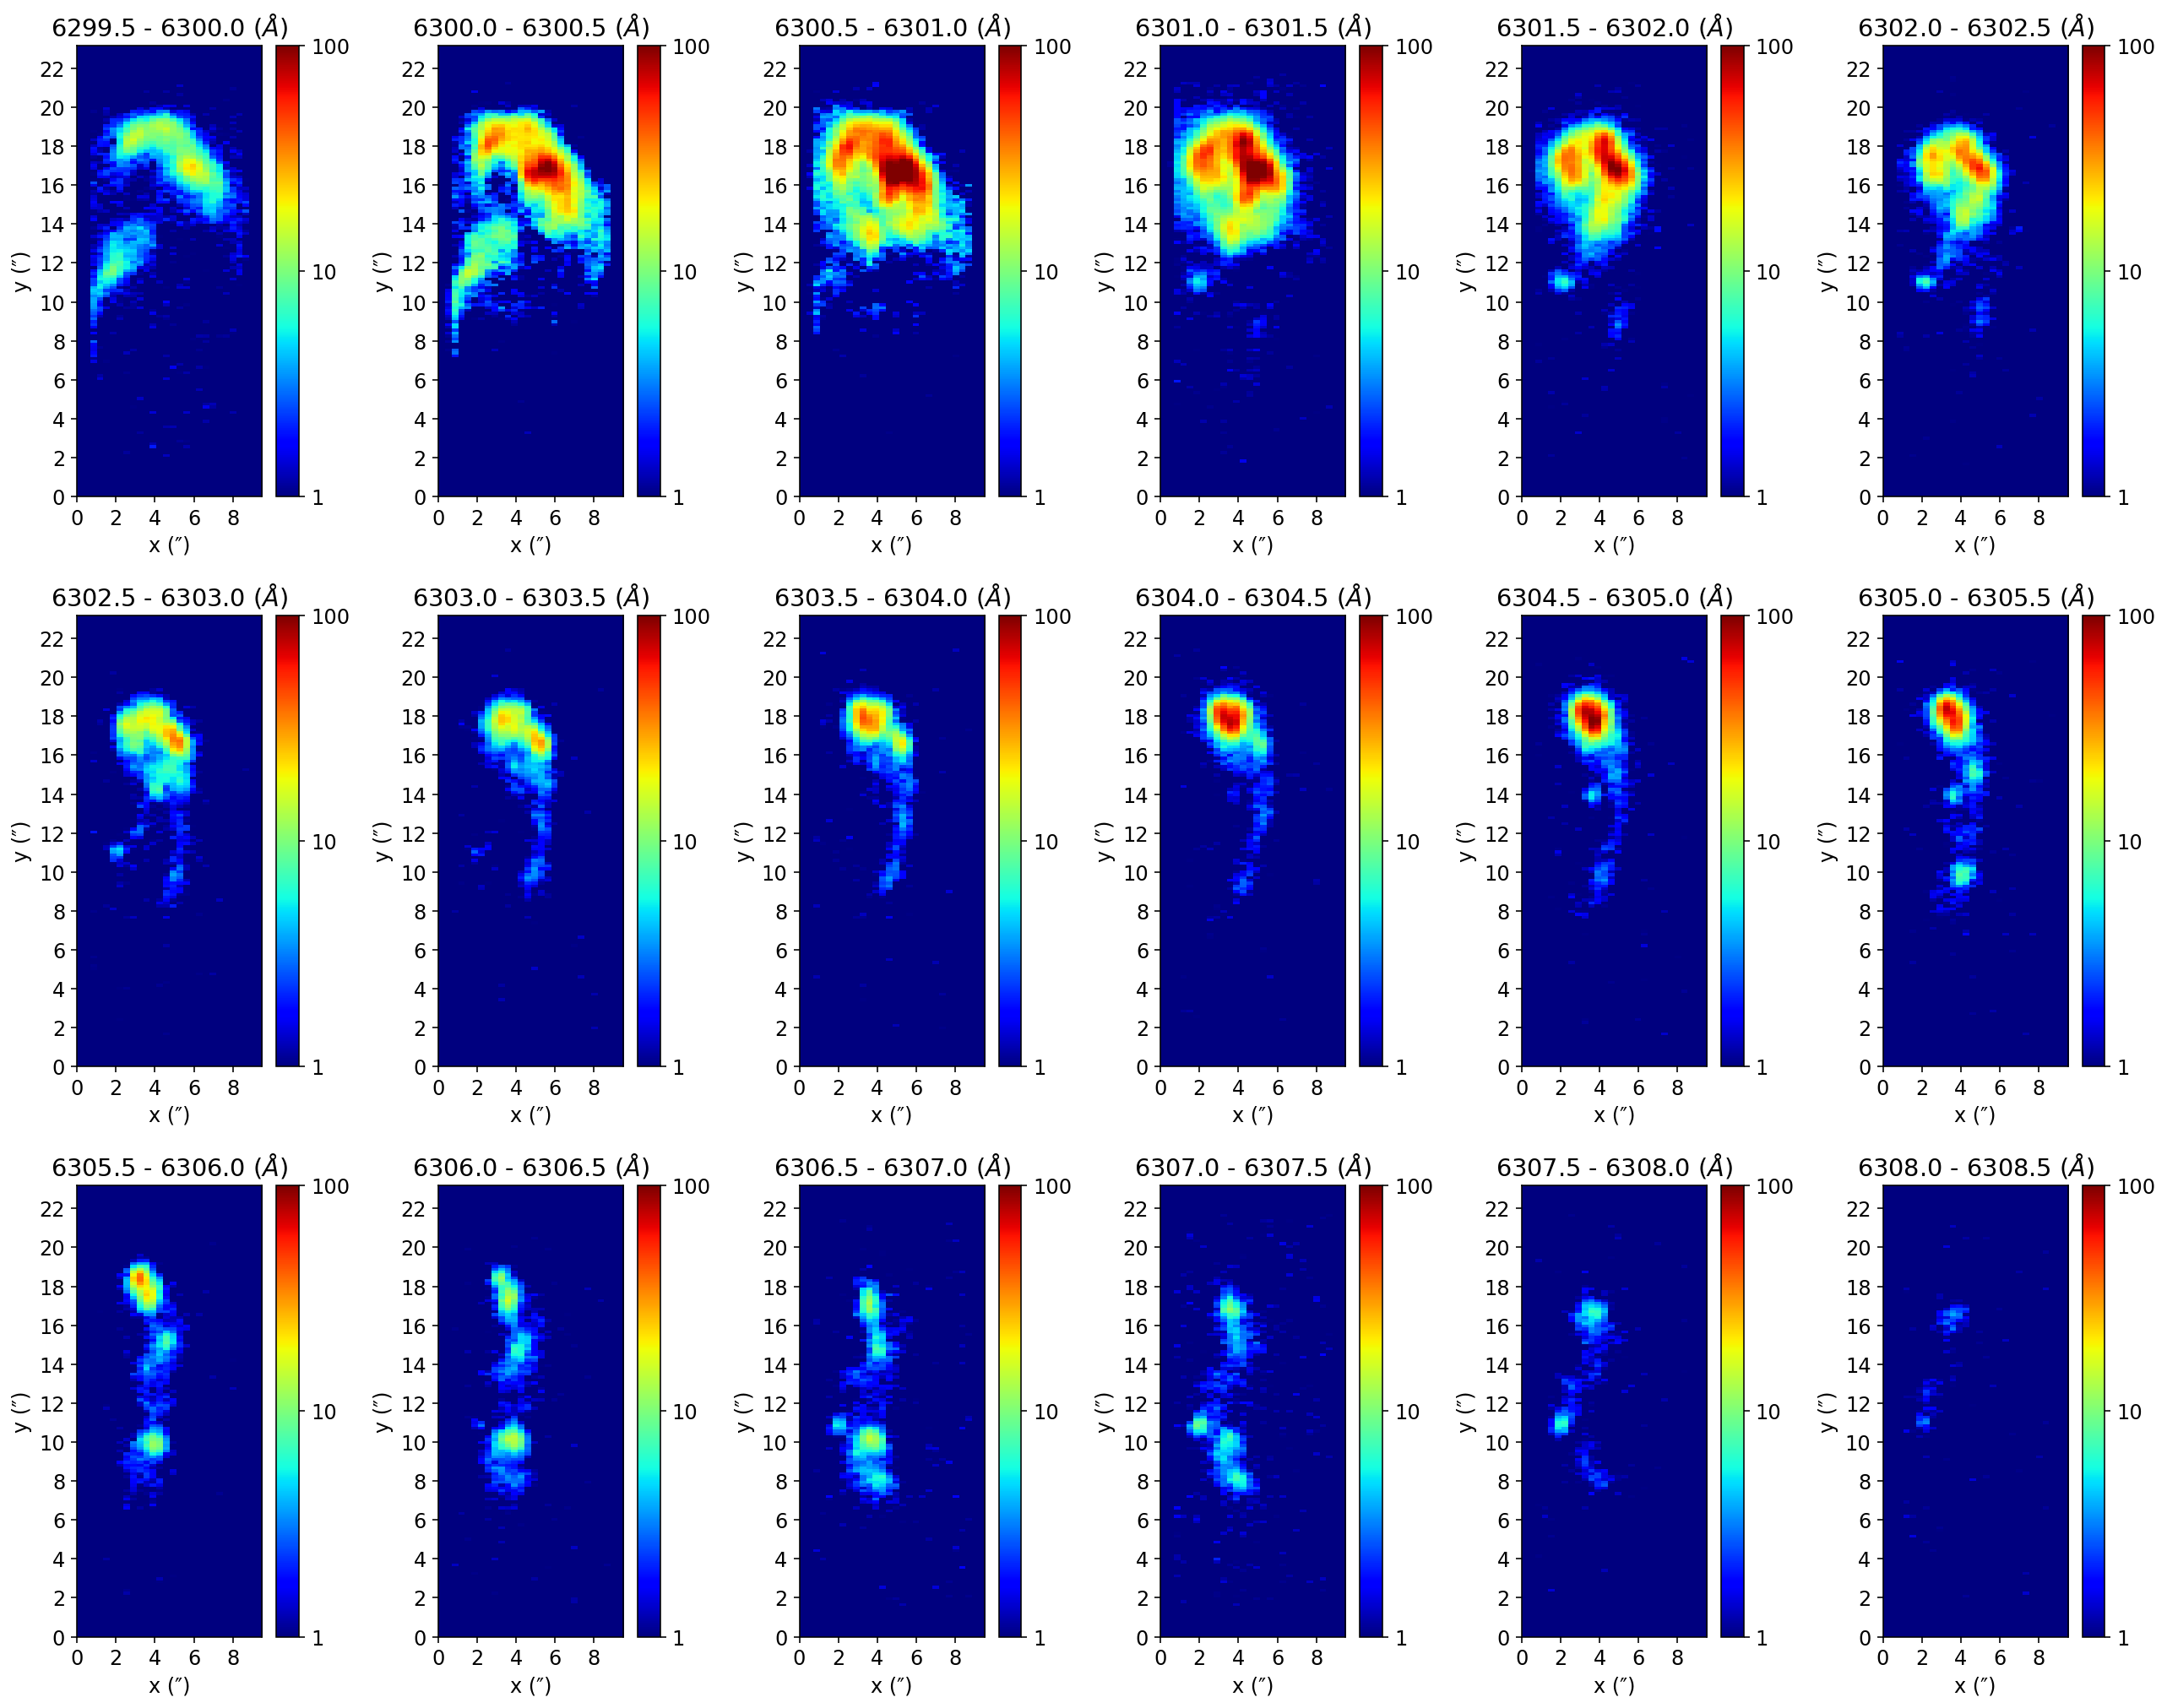

In [21]:
make_bin(6299.50, 6308.25, 0.5, "red", 1, 100, 6, (18, 70), [1, 10, 100])

In [22]:
plt.rcParams.update({'font.size': 10})

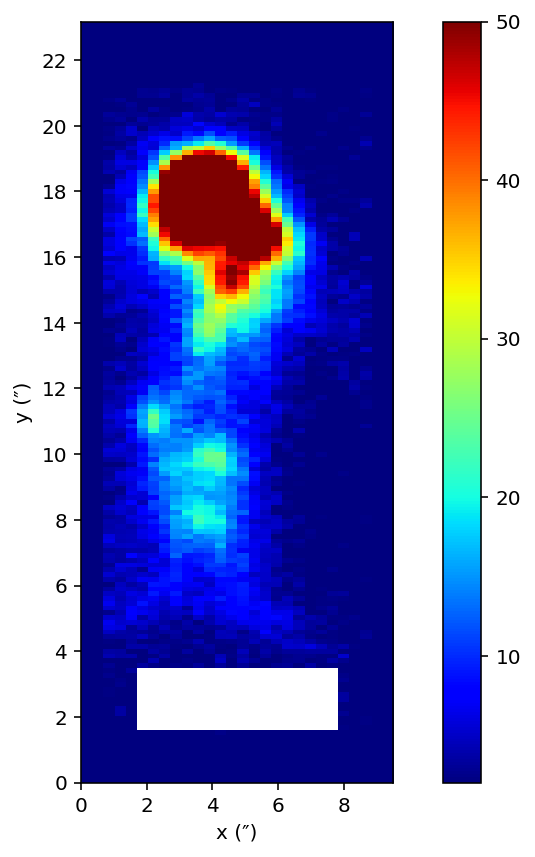

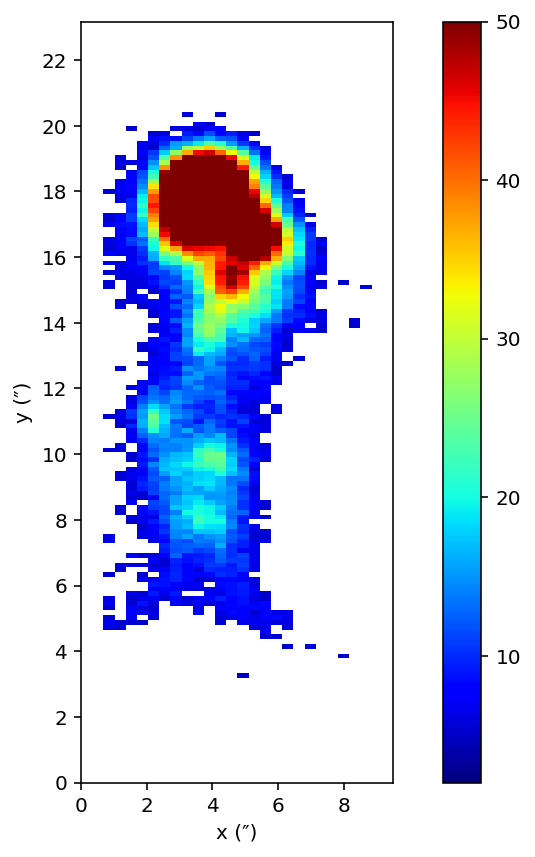

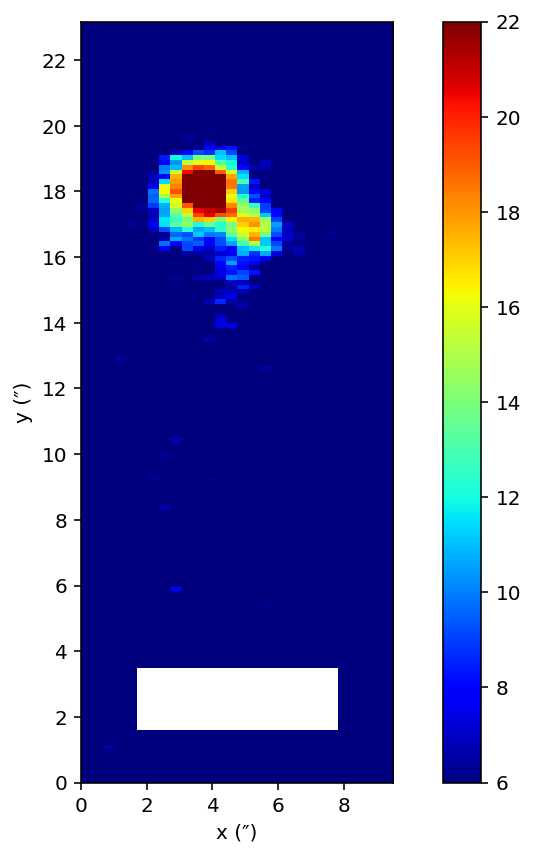

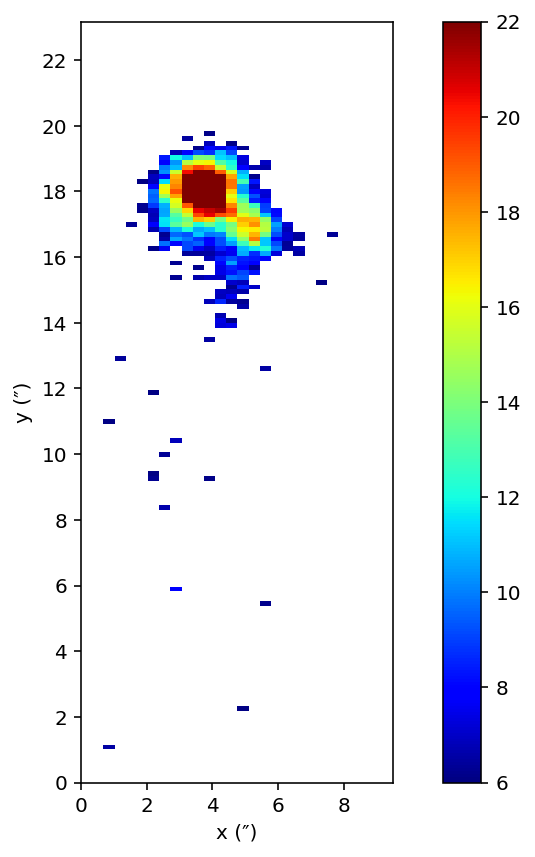

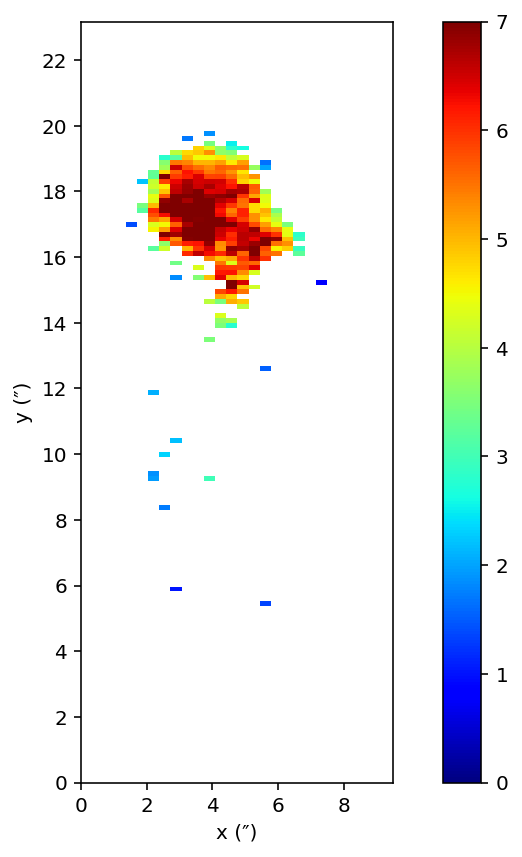

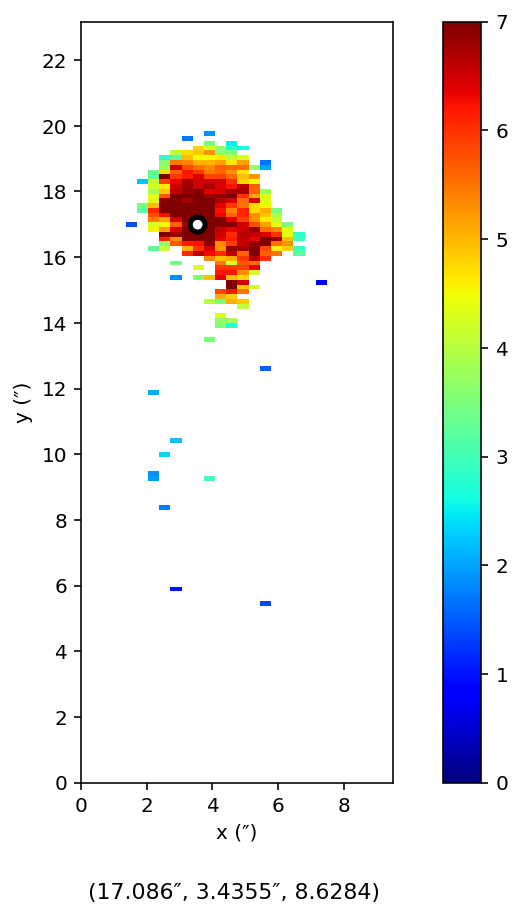

In [23]:
sum_4861 = make_sum(4860.25, 4867.50, "green")
sum_4861c = remove_noise(sum_4861, 2, 50, 3)

sum_4102 = make_sum(4101.25, 4105.5, "blue")
sum_4102c = remove_noise(sum_4102, 6, 22, 3)

hbeta_hdeltac = sum_4861c / sum_4102c
plot_sum(hbeta_hdeltac, 0, 7)
plt.show()

find_max_flux(hbeta_hdeltac, 0, 7)

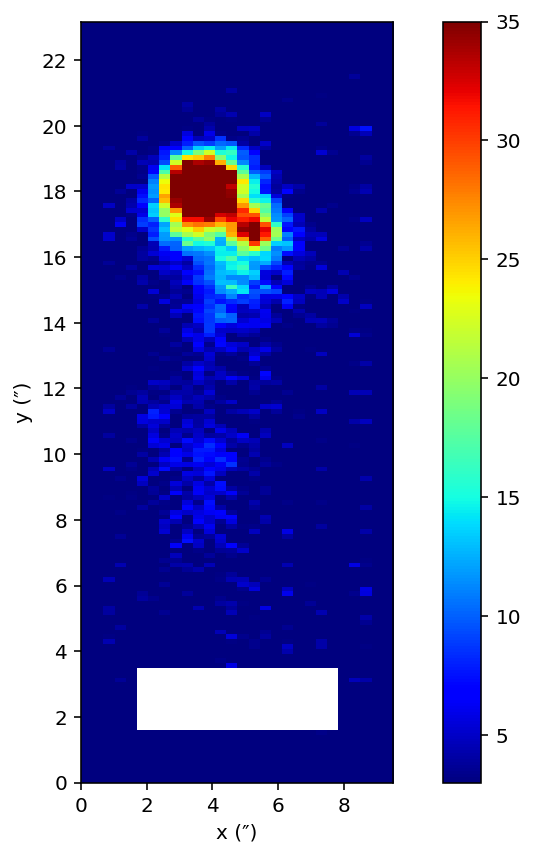

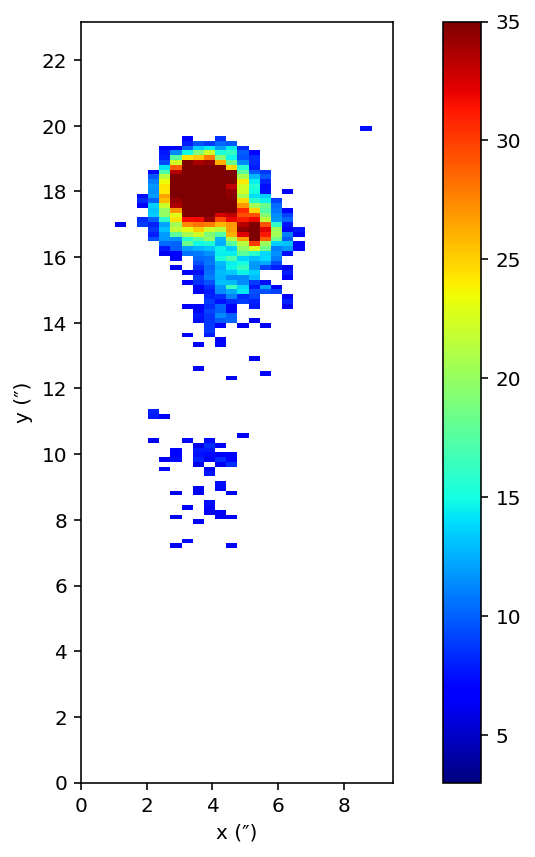

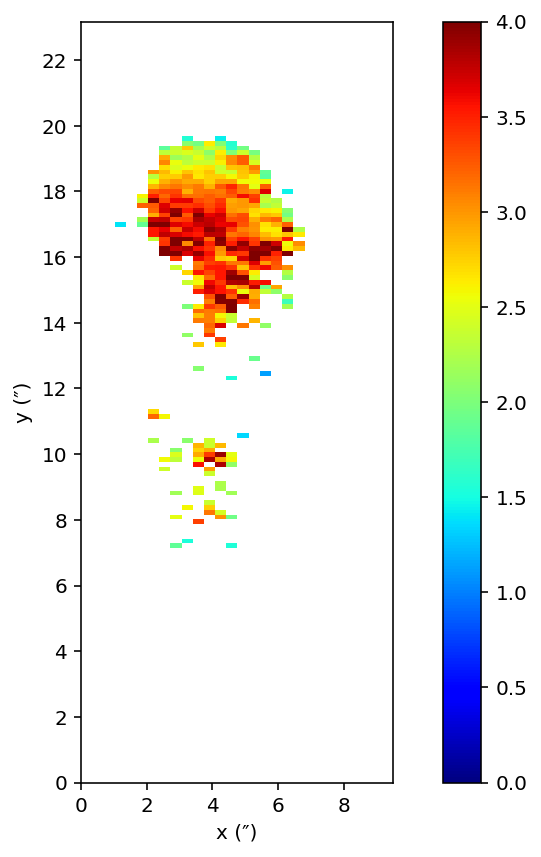

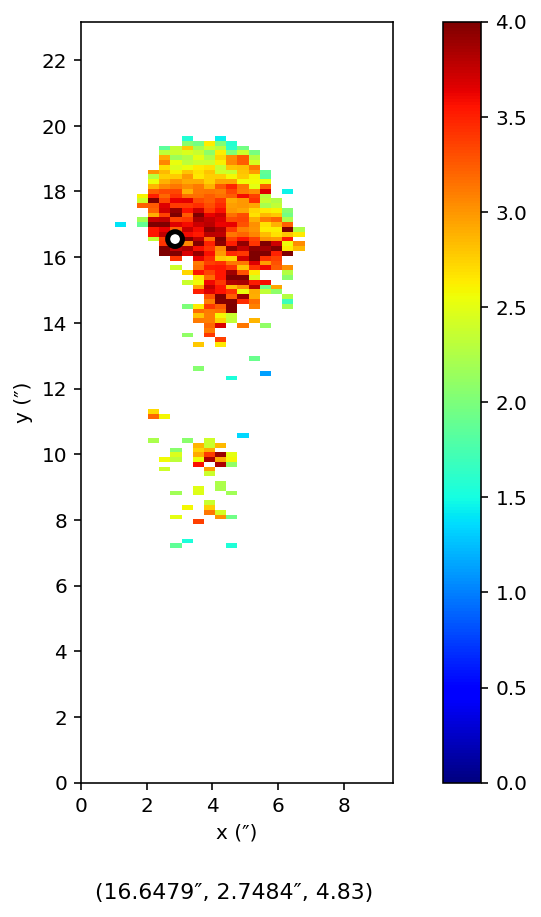

In [24]:
sum_4340 = make_sum(4339.75, 4345.25, "green")
sum_4340c = remove_noise(sum_4340, 3, 35, 3)

hbeta_hgammac = sum_4861c / sum_4340c
plot_sum(hbeta_hgammac, 0, 4)
plt.show()

find_max_flux(hbeta_hgammac, 0, 4)

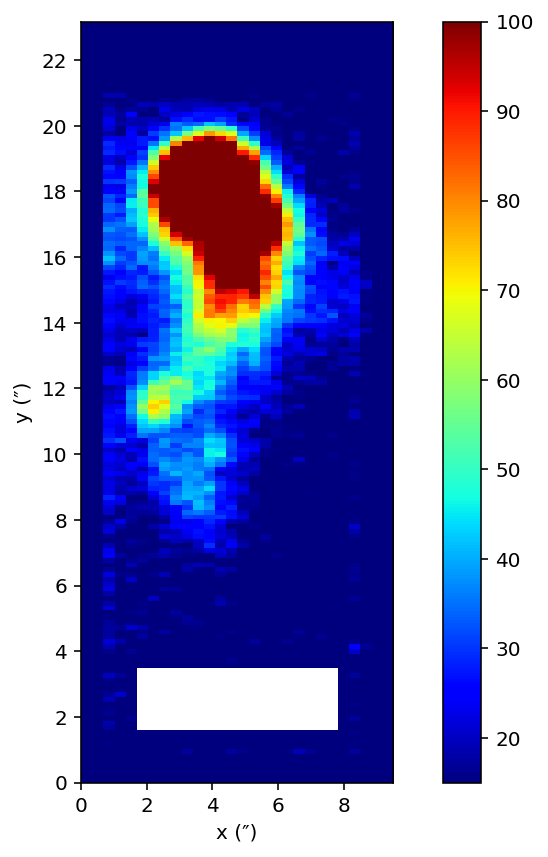

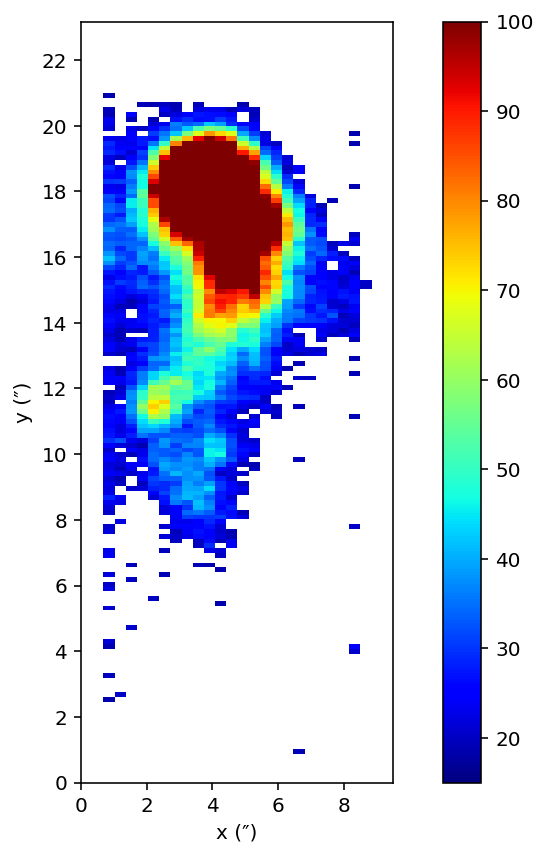

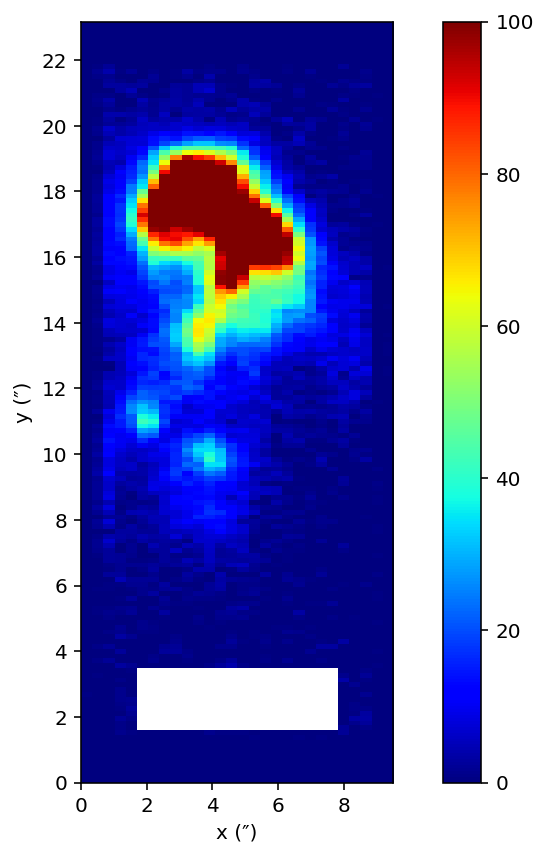

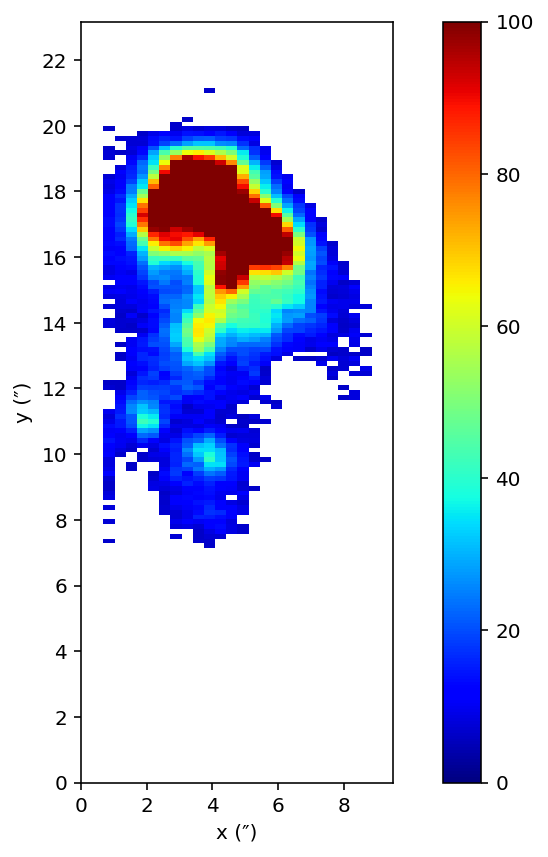

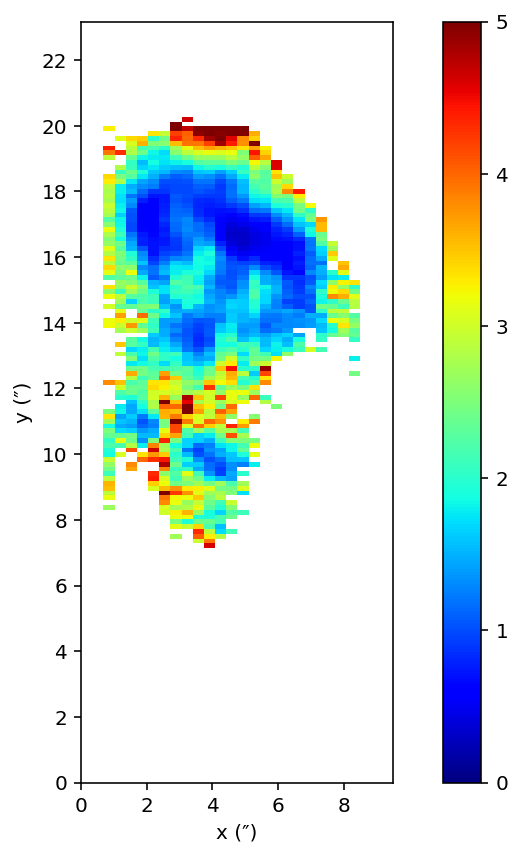

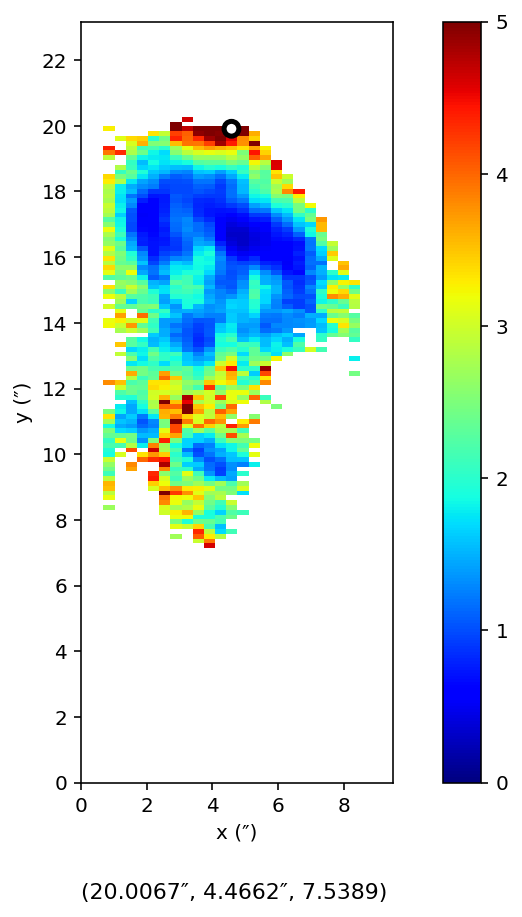

In [25]:
sum_3727 = make_sum(3725.25, 3733.75, "blue")
sum_3727c = remove_noise(sum_3727, 15, 100, 3)

sum_6300 = make_sum(6299.50, 6308.25, "red")
sum_6300c = remove_noise(sum_6300, 0, 100, 3)

oii_oic = sum_3727c / sum_6300c
plot_sum(oii_oic, 0, 5)
plt.show()

find_max_flux(oii_oic, 0, 5)

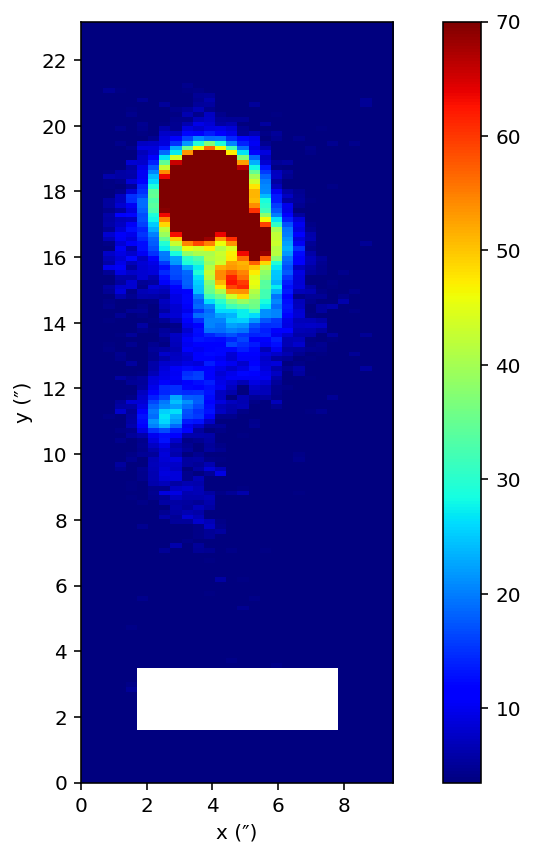

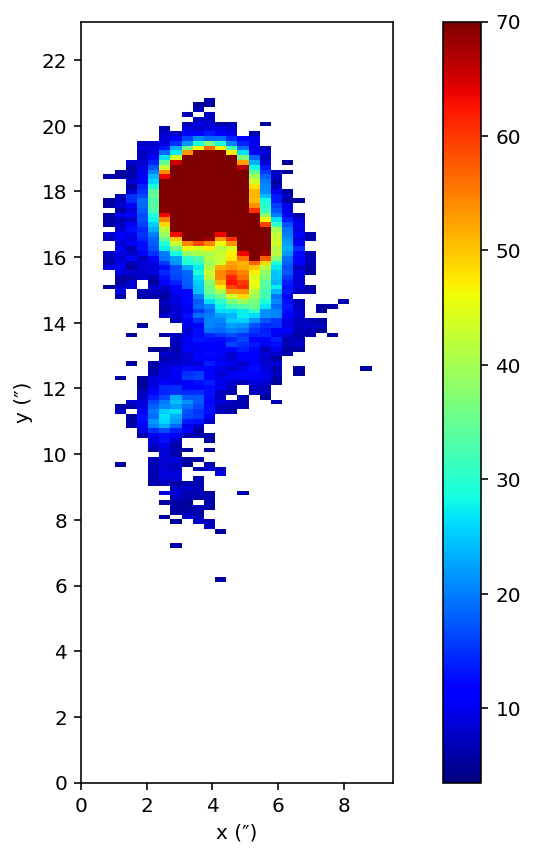

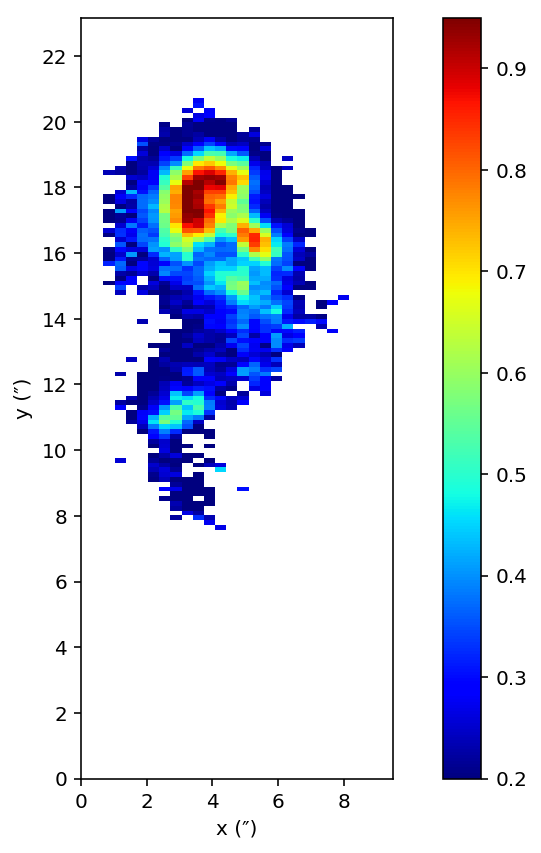

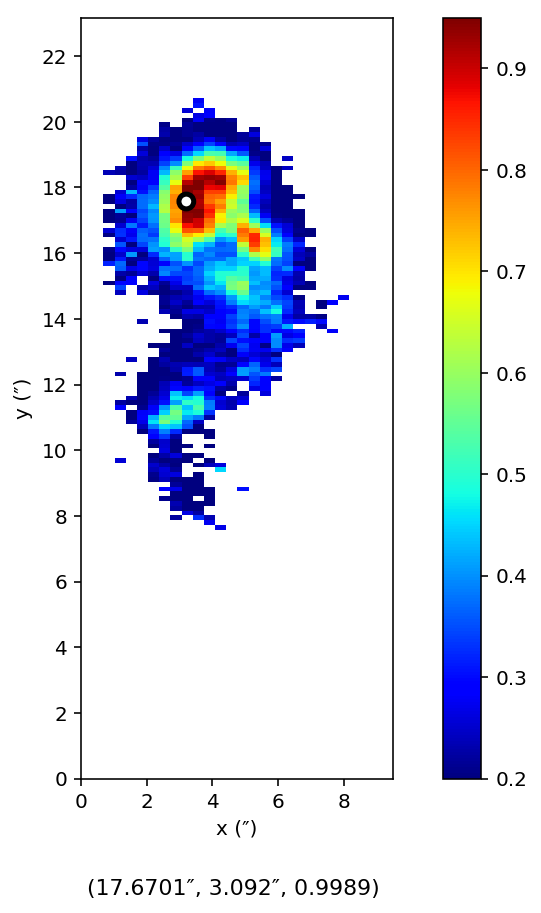

In [26]:
sum_4959 = make_sum(4958.25, 4964.75, "green")
sum_5007 = make_sum(5005.75, 5013.50, "green")
sum_oiii = np.copy(sum_4959 + sum_5007)
sum_oiiic = remove_noise(sum_oiii, 3.5, 70, 3)

oiii_oiic = sum_oiiic / sum_3727c
plot_sum(oiii_oiic, 0.2, 0.95)
plt.show()

find_max_flux(oiii_oiic, 0.2, 0.95)

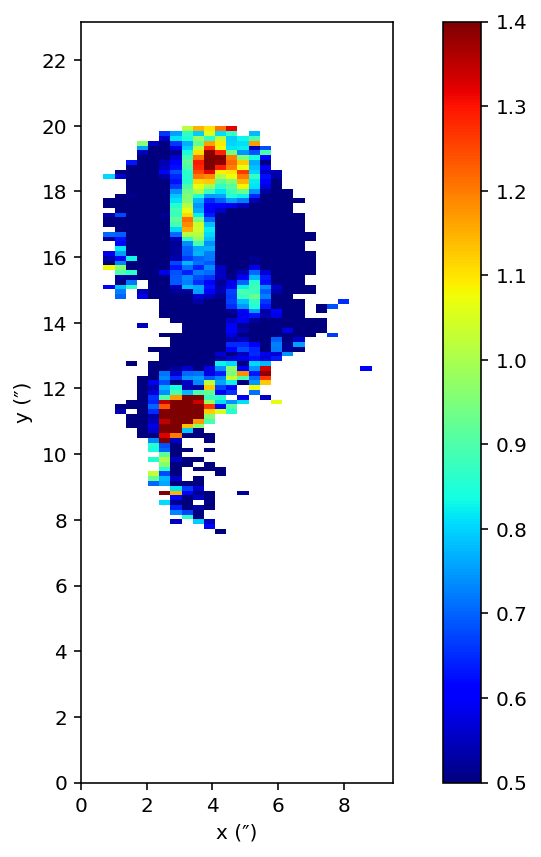

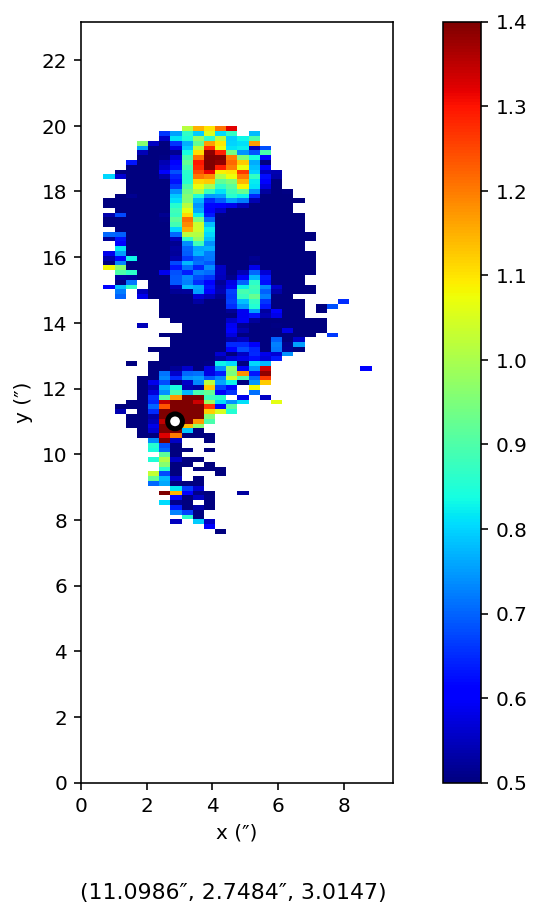

In [27]:
oiii_oic = sum_oiiic / sum_6300c
plot_sum(oiii_oic, 0.5, 1.4)
plt.show()

find_max_flux(oiii_oic, 0.5, 1.4)

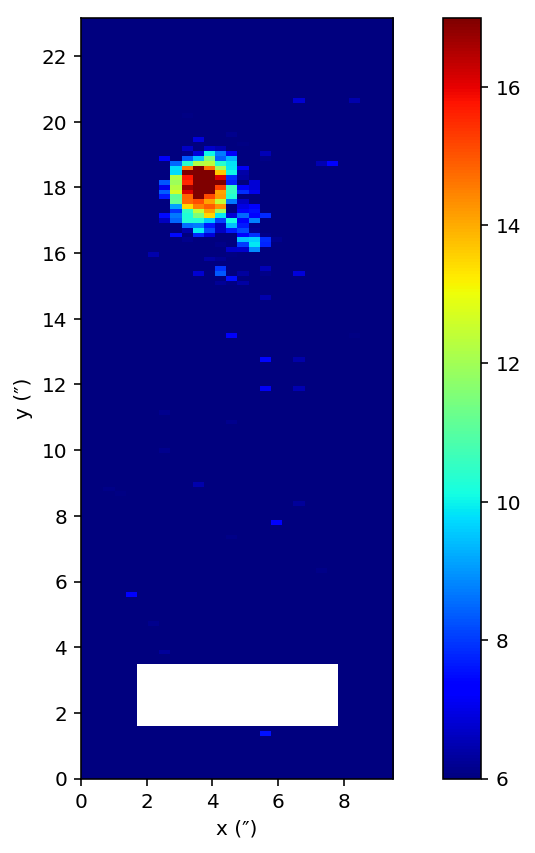

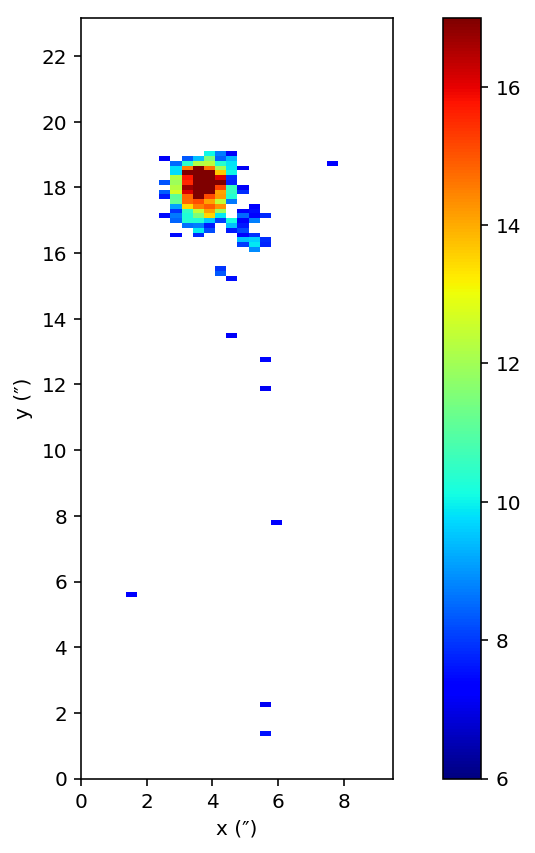

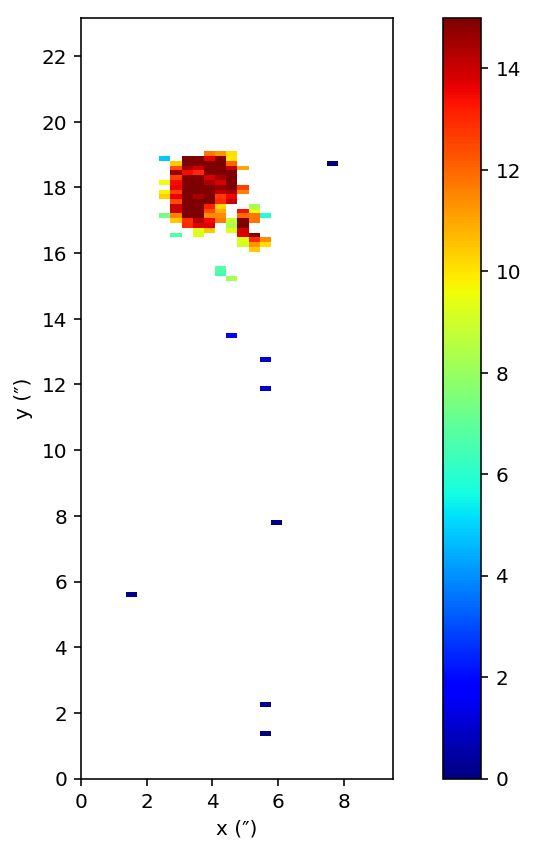

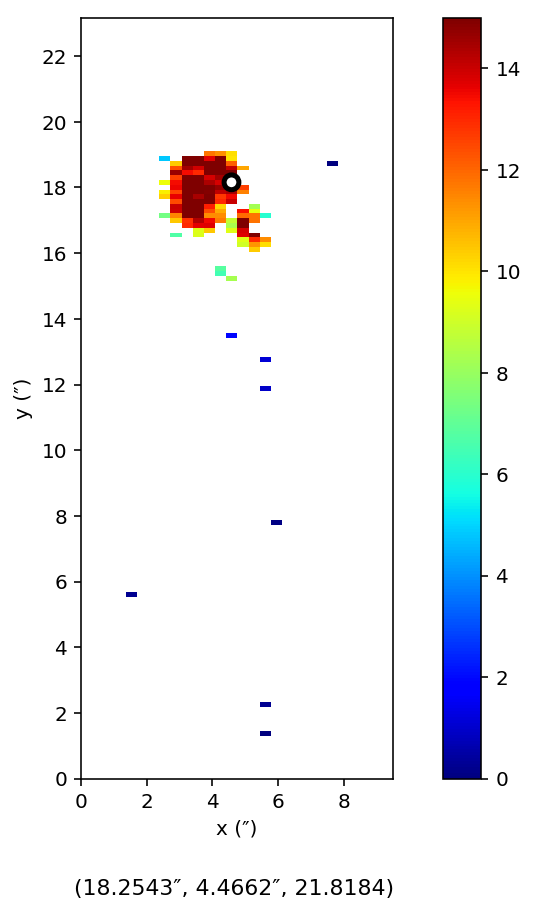

In [28]:
sum_4363 = make_sum(4362.00, 4366.75, "blue")
sum_4363c = remove_noise(sum_4363, 6, 17, 3)

oiii_oiiic = (sum_oiii) / sum_4363c
plot_sum(oiii_oiiic, 0, 15)
plt.show()

find_max_flux(oiii_oiiic, 0, 15)

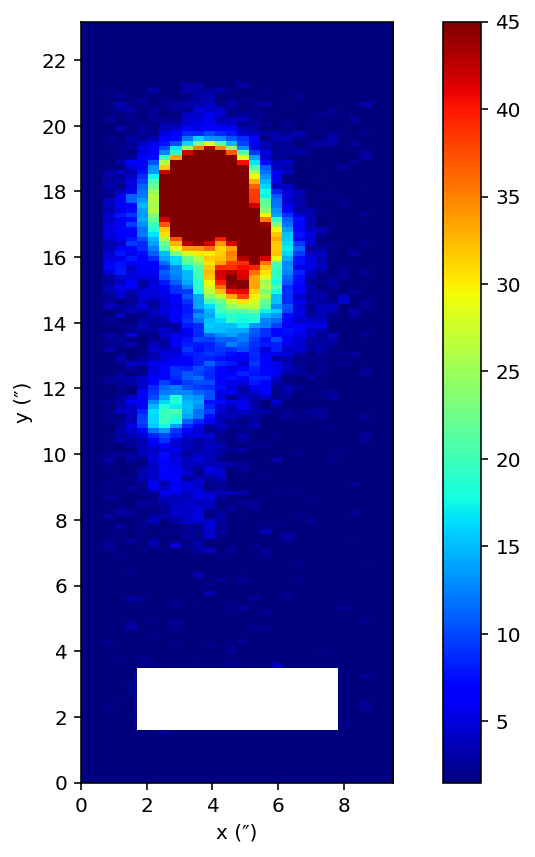

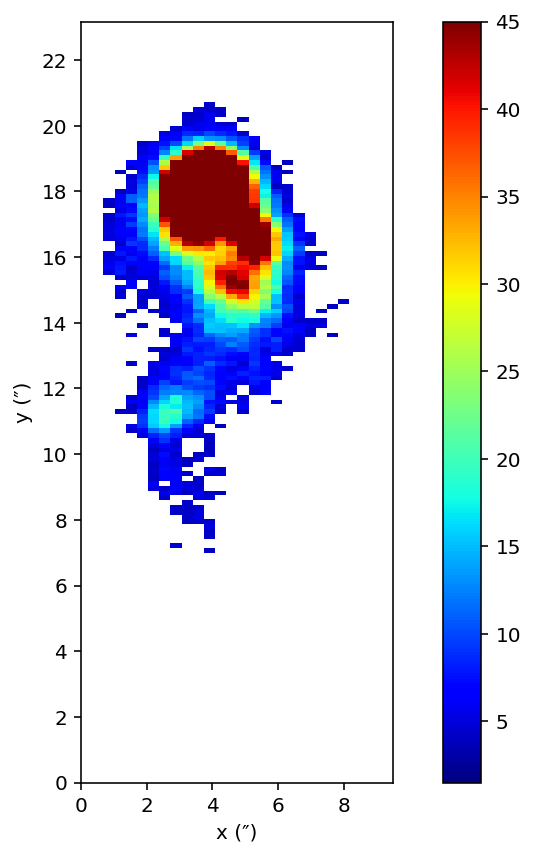

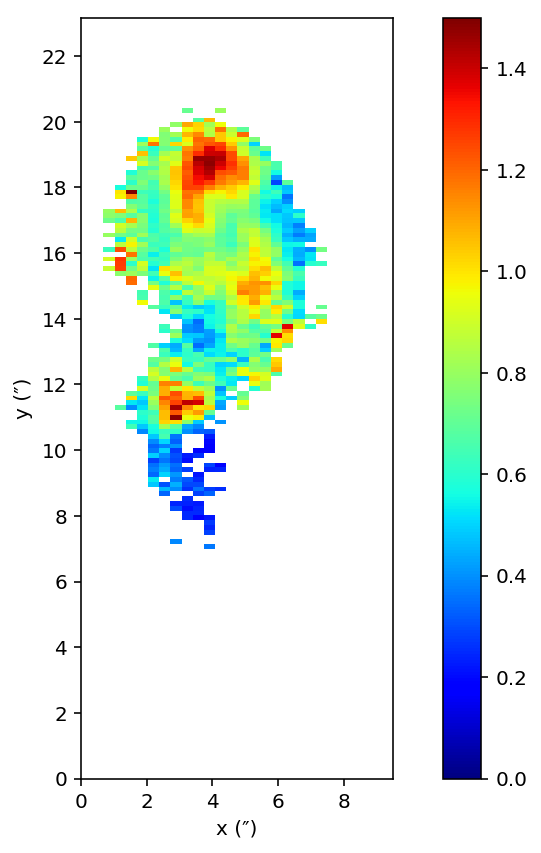

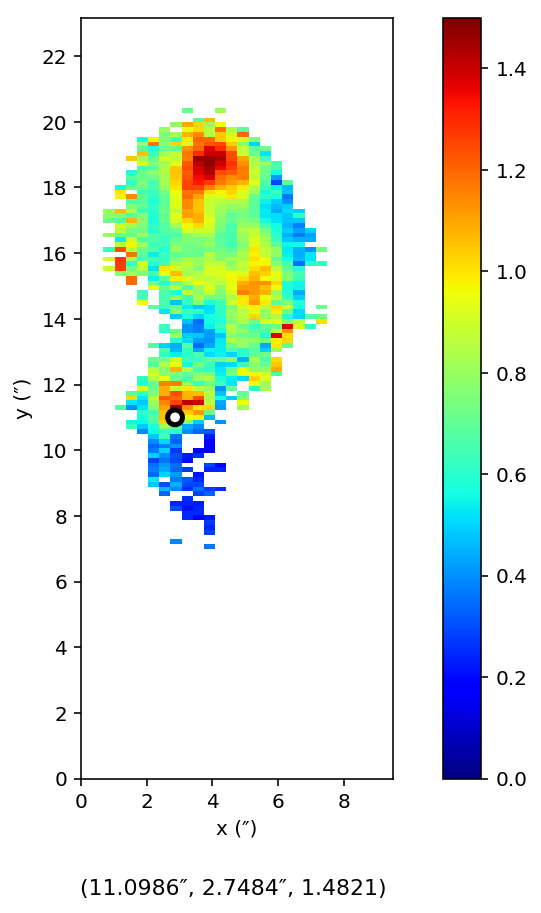

In [29]:
sum_5007c = remove_noise(sum_5007, 1.5, 45, 3)

oiii_hbetac = sum_5007c / sum_4861c
plot_sum(oiii_hbetac, 0, 1.5)
plt.show()

find_max_flux(oiii_hbetac, 0, 1.5, True)
plt.show()

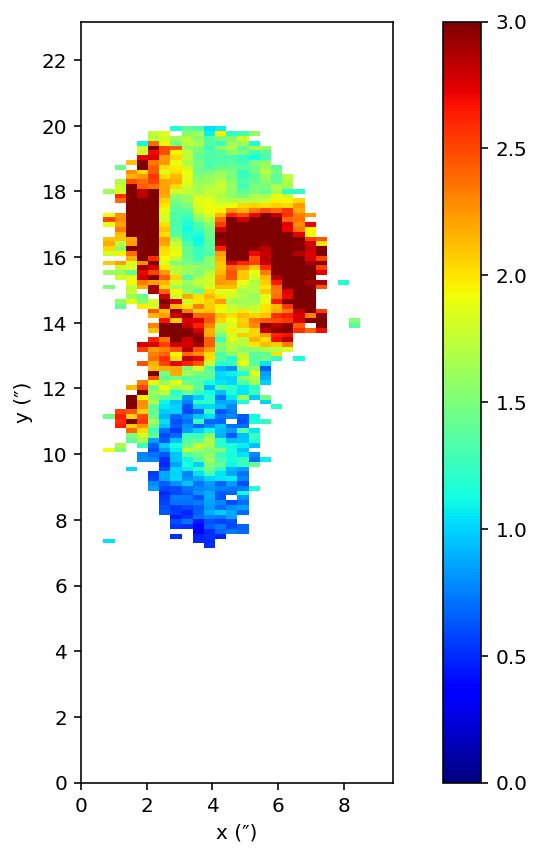

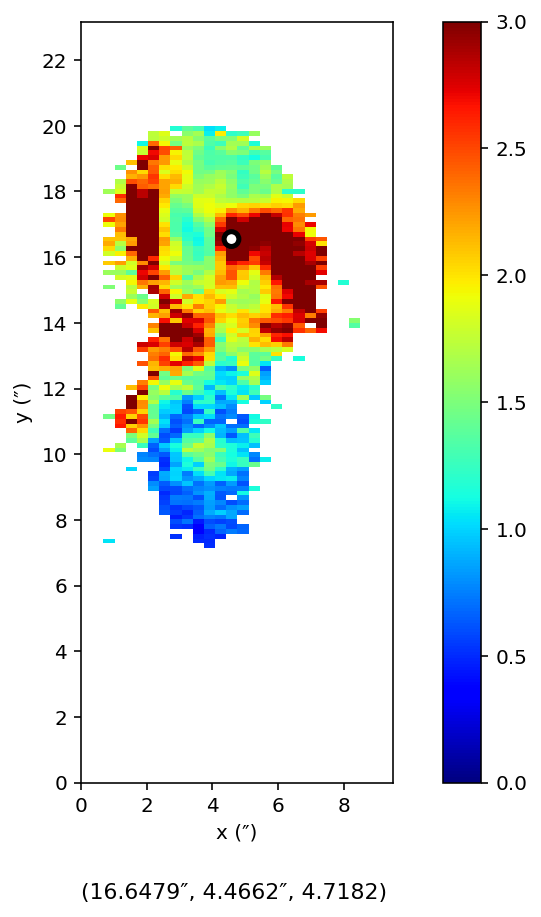

In [30]:
oi_hbetac = sum_6300c / sum_4861c
plot_sum(oi_hbetac, 0, 3)
plt.show()

find_max_flux(oi_hbetac, 0, 3)

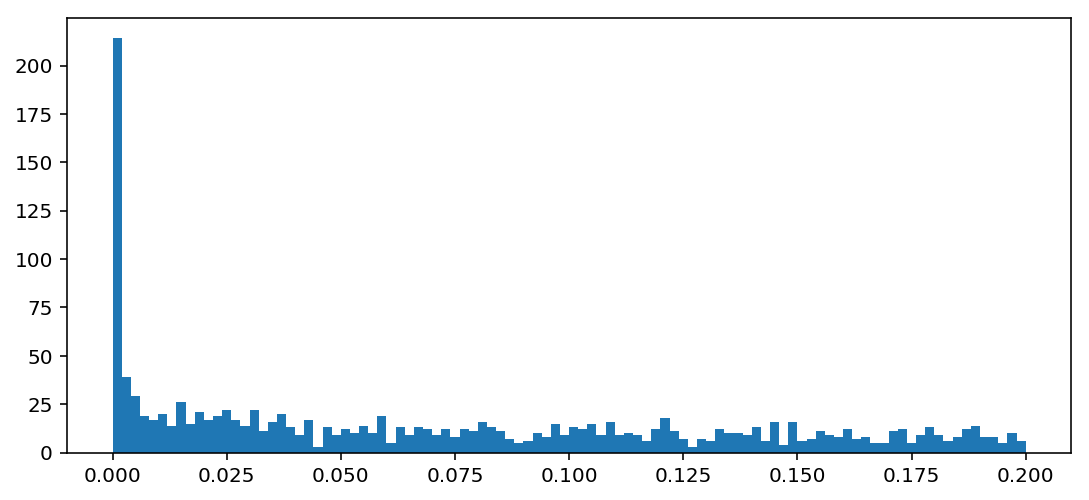

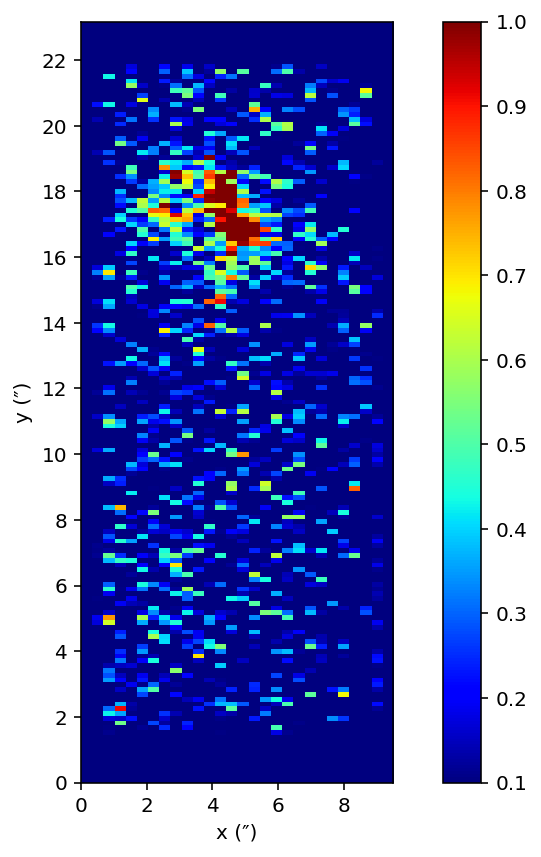

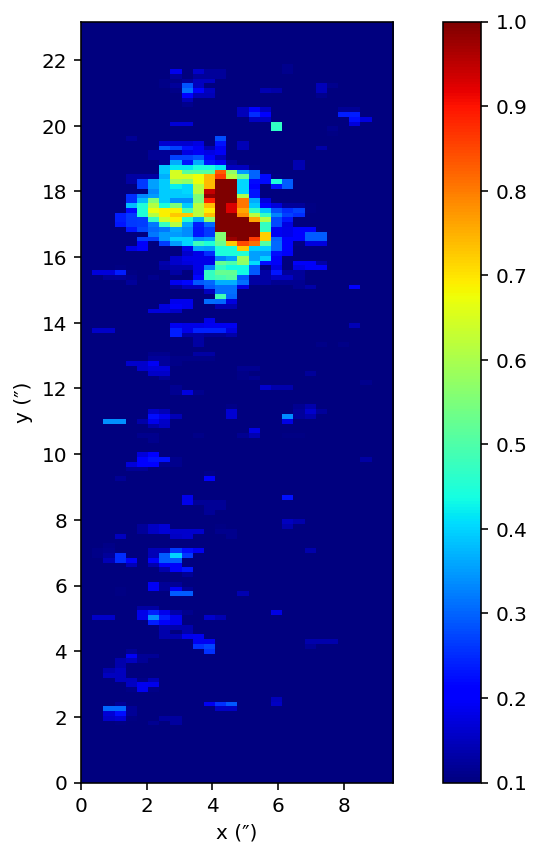

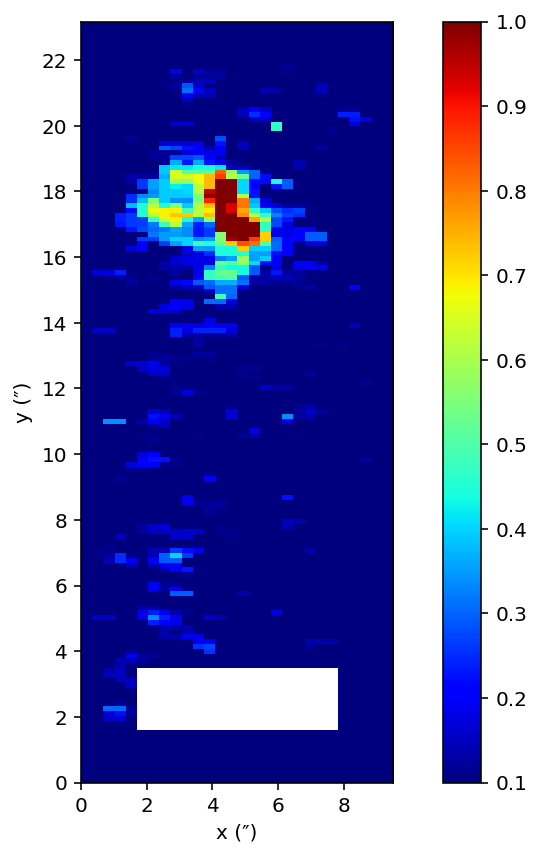

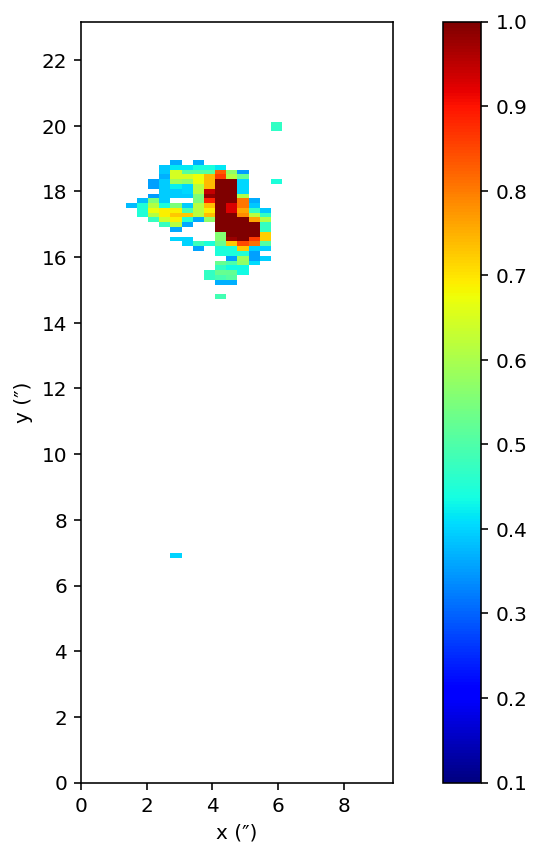

In [31]:
sum_5577 = make_sum(5578.00, 5578.50, "red")
plot_hist(sum_5577, [0, 0.2])
plot_sum(sum_5577, 0.1, 1)
plt.show()

sum_5577_med = ndimage.median_filter(sum_5577, 3)
plot_sum(sum_5577_med, 0.1, 1)
plt.show()

sum_5577c = remove_noise(sum_5577_med, 0.1, 1, 2)

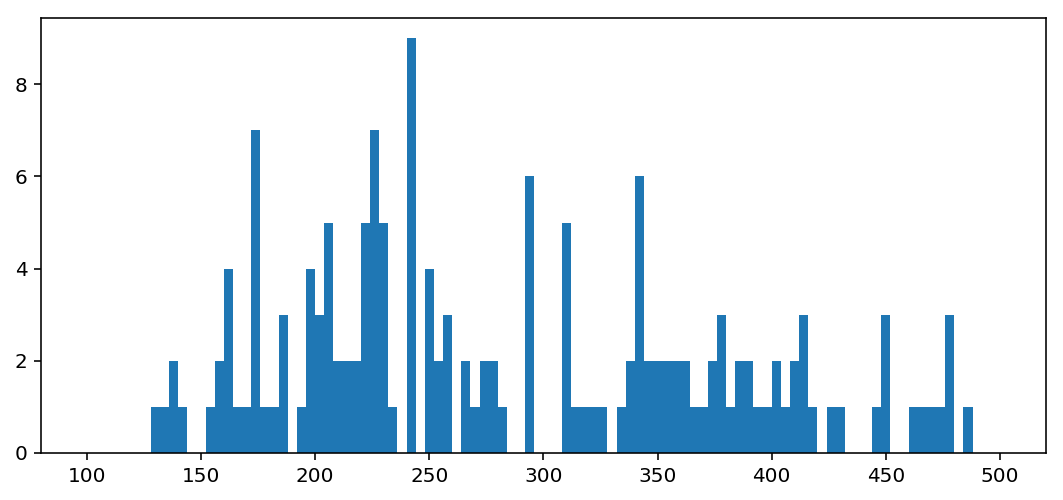

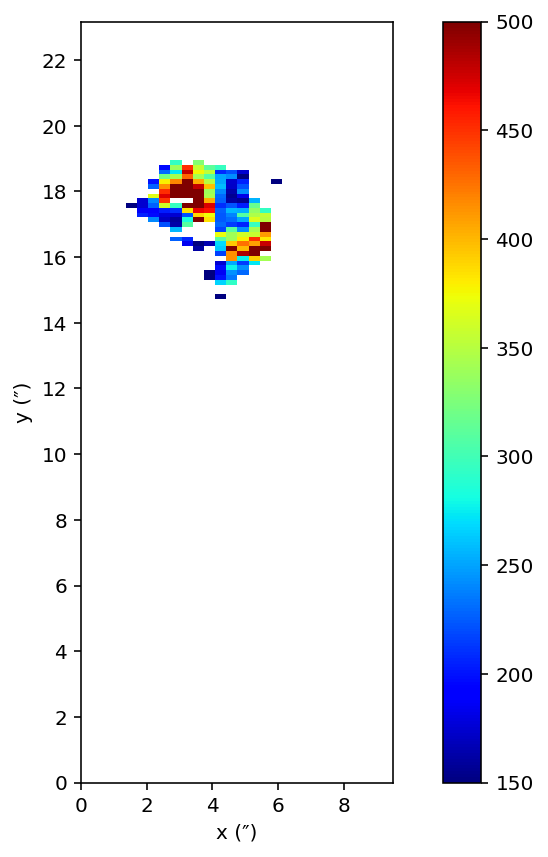

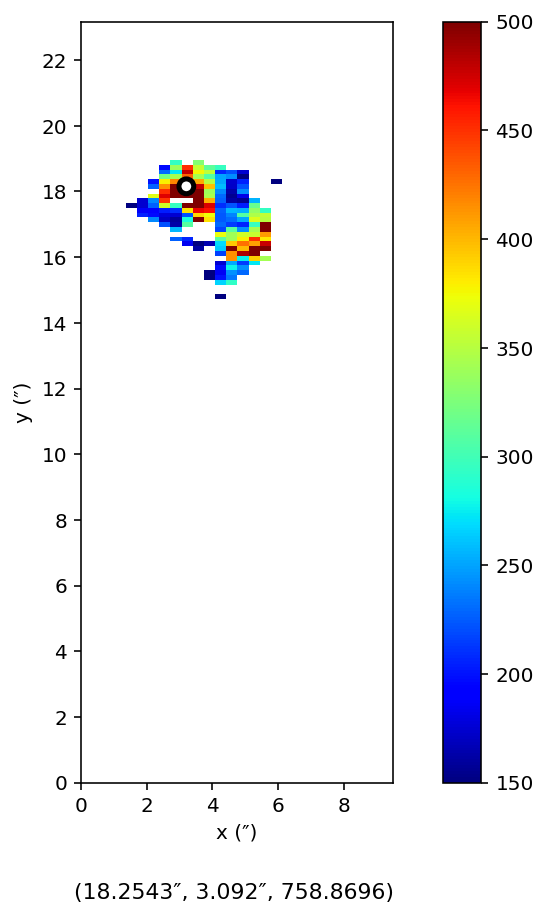

In [32]:
oi_oic = sum_6300c / sum_5577c
plot_hist(oi_oic[oi_oic == oi_oic], [100, 500])
plot_sum(oi_oic, 150, 500)
plt.show()

find_max_flux(oi_oic, 150, 500)

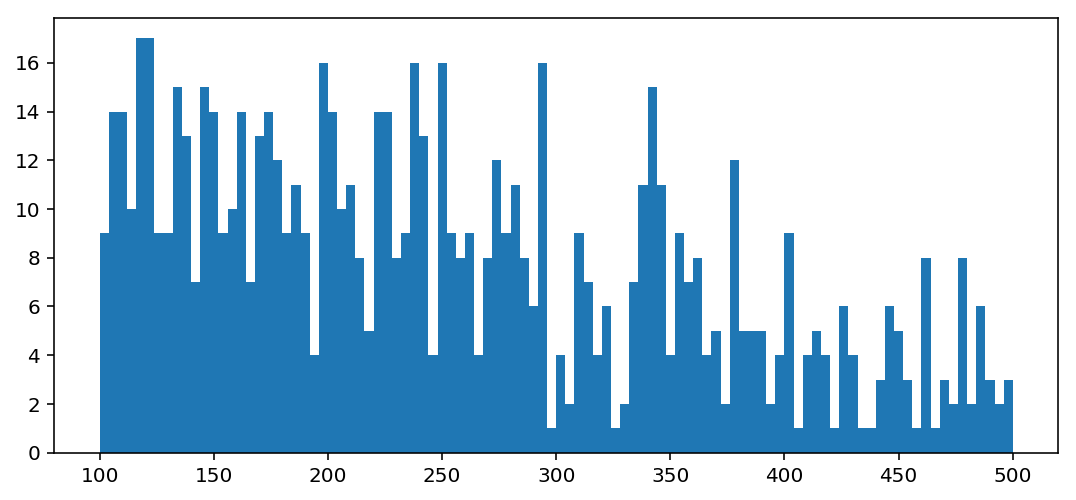

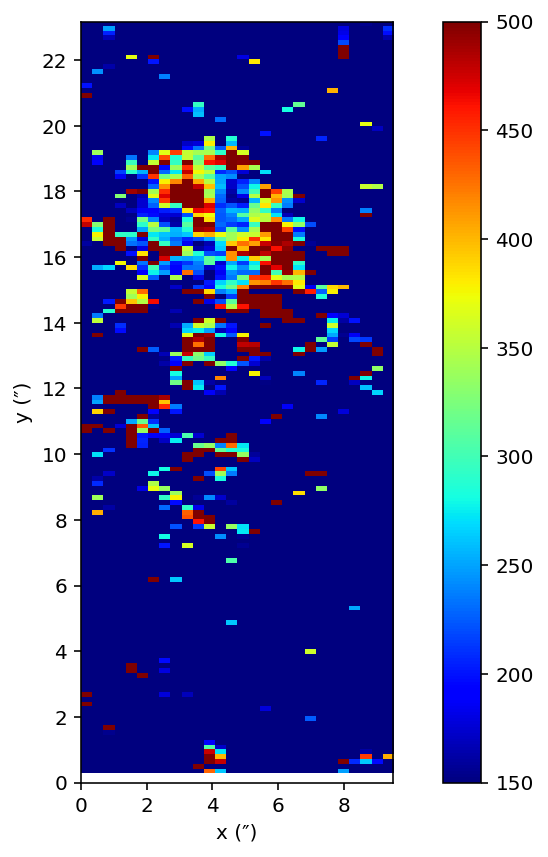

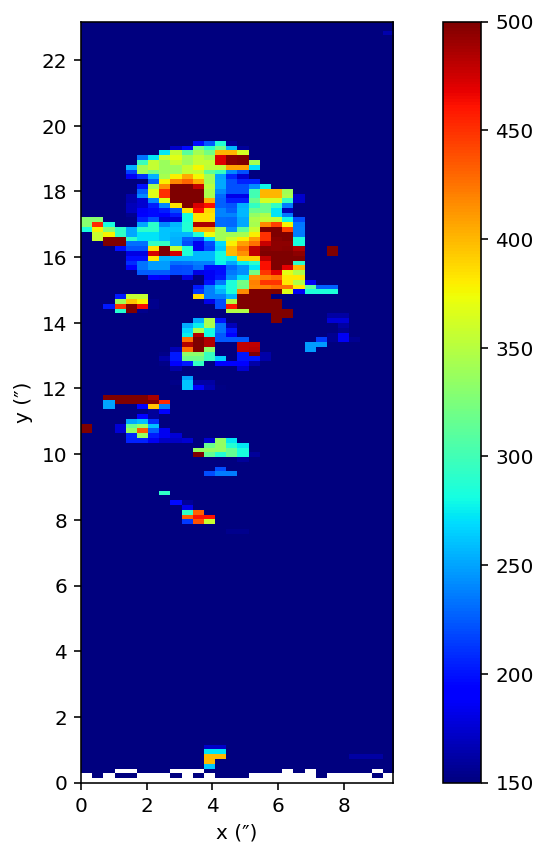

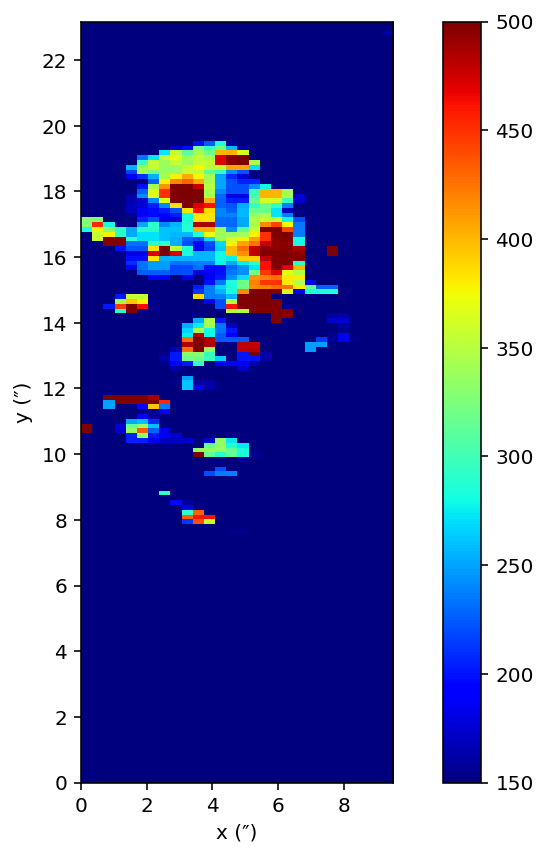

In [33]:
oi_oi = div0(sum_6300, sum_5577_med)
plot_hist(oi_oi[oi_oi == oi_oi], [100, 500])
plot_sum(oi_oi, 150, 500)
plt.show()

oi_oi_med = ndimage.median_filter(oi_oi, 3)
plot_sum(oi_oi_med, 150, 500)
plt.show()

for i in range(10): 
    for j in range(len(oi_oi_med[0])):
        oi_oi_med[-i][j] = 0   
        
plot_sum(oi_oi_med, 150, 500)
plt.show()

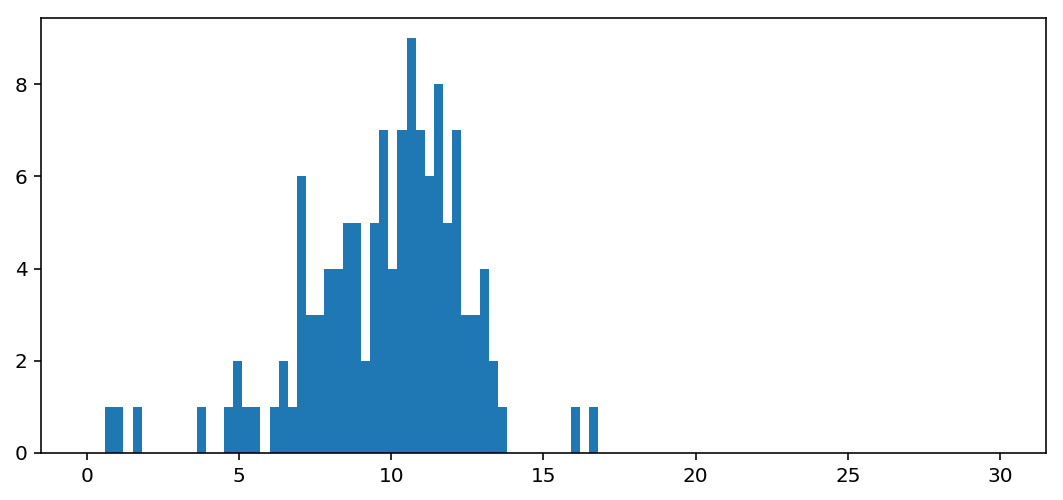

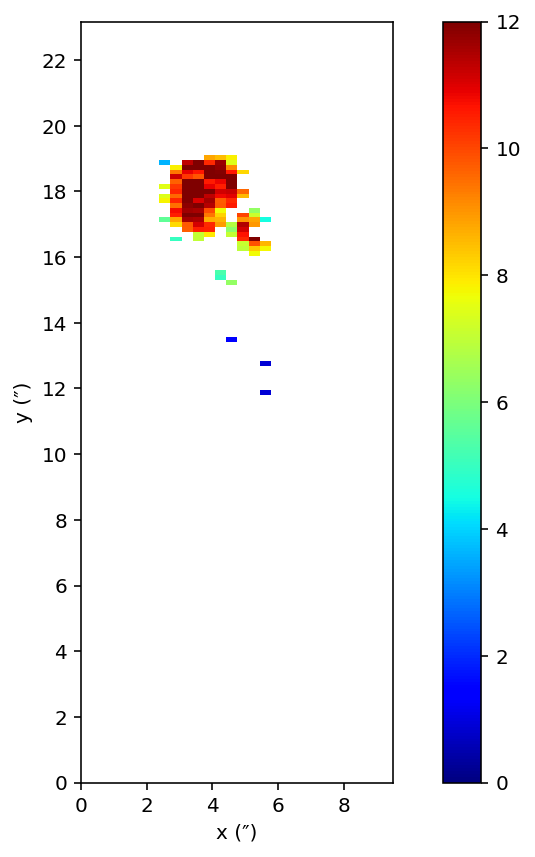

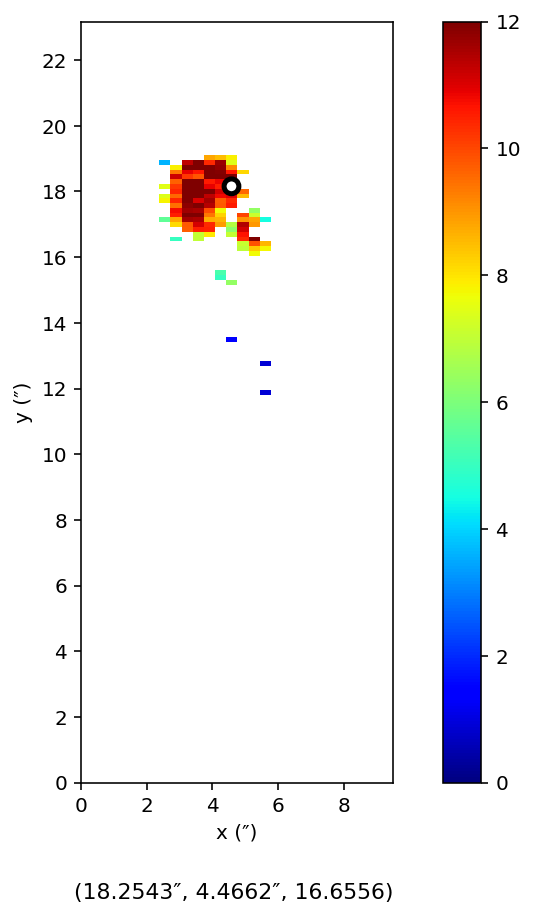

In [34]:
oiii_oiii2c = sum_5007c / sum_4363c
plot_hist(oiii_oiii2c[oiii_oiii2c == oiii_oiii2c], [0, 30])

plot_sum(oiii_oiii2c, 0, 12)
plt.show()

find_max_flux(oiii_oiii2c, 0, 12)

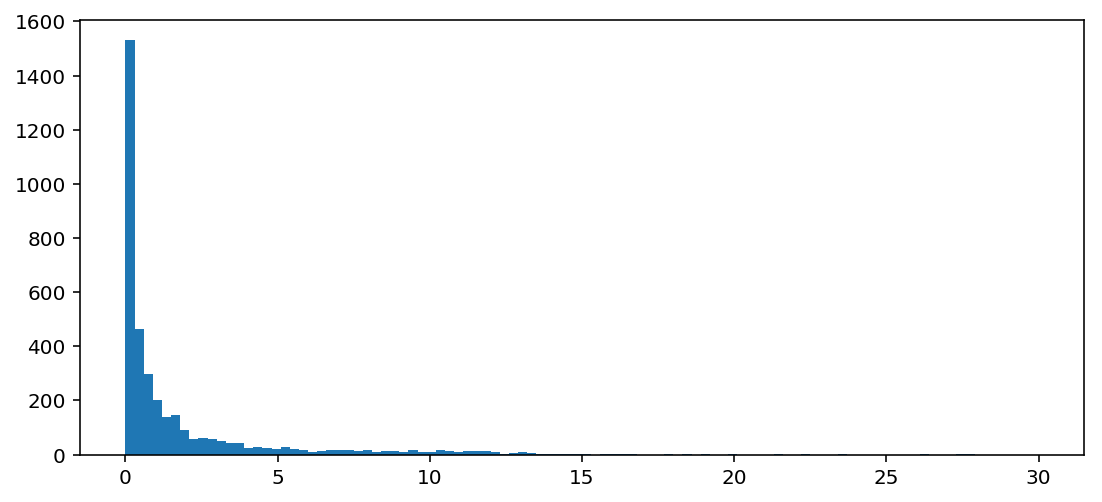

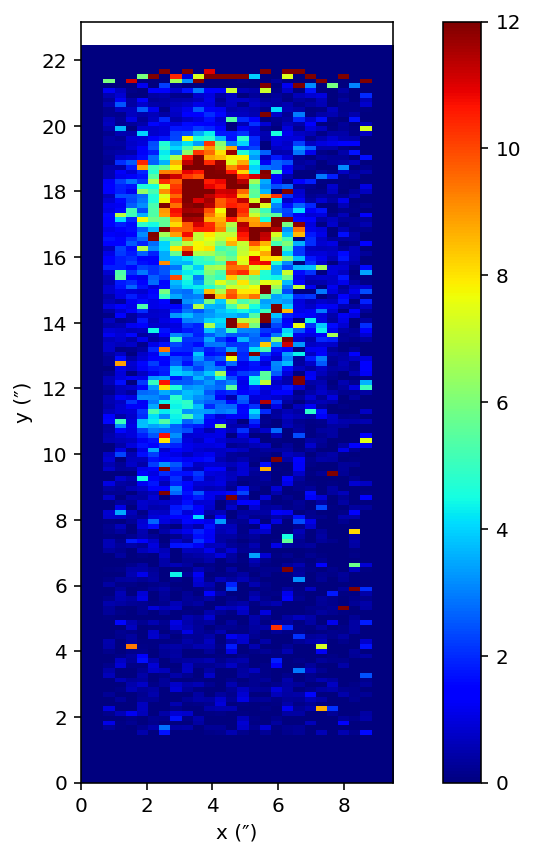

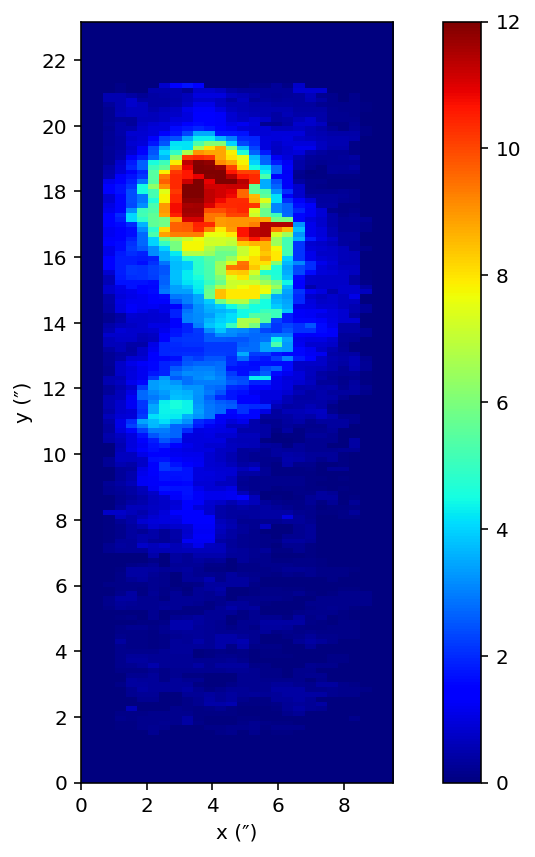

In [35]:
oiii_oiii2 = div0(sum_5007, sum_4363)
plot_hist(oiii_oiii2[oiii_oiii2 == oiii_oiii2], [0, 30])

plot_sum(oiii_oiii2, 0, 12)
plt.show()

oiii_oiii2_med = ndimage.median_filter(oiii_oiii2, 3)

for i in range(13): 
    for j in range(len(oiii_oiii2_med[0])):
        oiii_oiii2_med[i][j] = 0
        
plot_sum(oiii_oiii2_med, 0, 12)
plt.show()